### Data exploration and preprocessing for the [...] dataset

In [ ]:
"""
Load the source dataset and preprocess it

__ imgs
    |
    |__ fold_1
          |__ datasetname_id.png
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ ...
          |__ datasetname_id.png
          |__ ...

__ masks
    |
    |__ fold_1
          |__ datasetname_id.png  --> segmentation mask
          |__ datasetname_id.json --> segmentation box (COCO format)
          |__ ...
    |__ fold_2
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...
    |__ fold_3
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...
    |__ fold_4
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...
    |__ fold_5
          |__ datasetname_id.png
          |__ datasetname_id.json
          |__ ...

For segmentation masks --> 0 and 1 (if more than 2 labels --> use SimpleITK to encode integers in images)
For segmentation boxes --> use the COCO format to encode boxes
"""

In [1]:
import os
import zipfile
import random
import shutil
from PIL import Image
from tqdm import tqdm
import json 
from PIL import ImageDraw

import matplotlib.pyplot as plt
import numpy as np

from helpers import check_dir_consistency, visualize_images, get_all_dims, create_histograms_of_dims

Please follow the suggested of download order.

## 1. Train
### 1.1 Original images from DOTA v1
- Get the 'image' folder from https://drive.google.com/drive/folders/1gmeE3D7R62UAtuIFOB9j2M5cUPTwtsxK
- 3 zips in total (1411 images):
    - `part1.zip` (469 images)
    - `part2.zip` (474 images)
    - `part3.zip` (468 images)
- Note: do not take '~1/part1.zip' in addition to '~part1.zip'

### 1.2 Masks from isaid
- Get all folders from https://drive.google.com/drive/folders/19RPVhC0dWpLF9Y_DYjxjUrwLbKUBQZ2K
- 1 zip `train-20240131T084536Z-001.zip`


## 2. Valid
### 2.1. Original images from DOTA v1
- Get the 'image' folder from https://drive.google.com/drive/folders/1RV7Z5MM4nJJJPUs6m9wsxDOJxX6HmQqZ
- 1 zip file (458 images): 
    - `part1.zip` (458 images)
- If you have followed suggested download order, this file should be renamed by your operating system (e.g., `part1 (1).zip`)
### 2.2. Masks from isaid
- Get all folders from https://drive.google.com/drive/folders/17MErPhWQrwr92Ca1Maf4mwiarPS5rcWM
- 1 zip `val-20240131T084706Z-001.zip`

## 3. Test
Download is not needed given that annotations of the test set are not publicly available.

There are a total of 1869 images for which annotations are provided.
The remaining 937 images from the test set are not used.

## Prepare data

In [2]:
seed = 42
nb_folds = 5

### Directories

In [3]:
input_dir = '/home/rob/Documents/3_projects/bench/isaid/data' # <--- modify this
output_dir = '/home/rob/Documents/3_projects/bench/isaid/processed' # <--- modify this

file_names = os.listdir(input_dir)
file_names

['part1 (1).zip',
 'part2.zip',
 'part1.zip',
 'part3.zip',
 'val-20240131T084706Z-001.zip',
 'train-20240131T084536Z-001.zip']

In [4]:
data_sources = [os.path.join(input_dir, f) for f in file_names]
print(f'Data file location: {data_sources}')

Data file location: ['/home/rob/Documents/3_projects/bench/isaid/data/part1 (1).zip', '/home/rob/Documents/3_projects/bench/isaid/data/part2.zip', '/home/rob/Documents/3_projects/bench/isaid/data/part1.zip', '/home/rob/Documents/3_projects/bench/isaid/data/part3.zip', '/home/rob/Documents/3_projects/bench/isaid/data/val-20240131T084706Z-001.zip', '/home/rob/Documents/3_projects/bench/isaid/data/train-20240131T084536Z-001.zip']


In [5]:
tmp_data_dir = os.path.join(output_dir, 'tmp_data')
os.makedirs(tmp_data_dir, exist_ok=True)
print(tmp_data_dir)

/home/rob/Documents/3_projects/bench/isaid/processed/tmp_data


In [ ]:
def unzip_dirs(data_sources: str, tmp_data_dir: str) -> list:
    subdirs: list = []

    for data_source in tqdm(data_sources, desc='Unzip dir'):
        subdir_name = os.path.splitext(os.path.basename(data_source))[0]
        subdir_path = os.path.join(tmp_data_dir, subdir_name)
        subdirs.append(subdir_path)

        # Make destination dir
        os.makedirs(subdir_path, exist_ok=True)
        
        # Unzip
        with zipfile.ZipFile(data_source, 'r') as zip_file:
            print(f'Unzipping {data_source} into {subdir_path}')
            zip_file.extractall(subdir_path)

        # Clear new dir
        images_dir = os.path.join(subdir_path, 'images')
        if os.path.exists(images_dir):
            # Move all images one directory higher in dir tree
            for file_name in os.listdir(images_dir):
                shutil.move(os.path.join(images_dir, file_name), subdir_path)
            # Remove empty 'image' subdirectory
            os.rmdir(images_dir)
    return subdirs

subdirs = unzip_dirs(data_sources, tmp_data_dir)

###

## Unzip train & val masks

In [6]:
def unzip_masks(source, destination) -> int:
    result: int = 0
    print(f'Begin to unzip from {source} to {destination}')
    os.makedirs(destination, exist_ok=True)
    
    with zipfile.ZipFile(source, 'r') as zip_ref:
        zip_ref.extractall(destination)
    
    print(f'All Semantic masks extracted in {destination}')
    
    images_sub_dir = os.path.join(destination, 'images')
    if os.path.exists(images_sub_dir):
        for filename in os.listdir(images_sub_dir):
            shutil.move(os.path.join(images_sub_dir, filename), destination)
            result += 1
        os.rmdir(images_sub_dir)
        
    return result

In [7]:
train_masks_dir = os.path.join(tmp_data_dir, 'train-20240131T084536Z-001', 'train', 'Semantic_masks', 'images.zip')
mask_output_dir = os.path.join(tmp_data_dir, 'all_masks')

valid_masks_dir = os.path.join(tmp_data_dir, 'val-20240131T084706Z-001', 'val', 'Semantic_masks', 'images.zip')
valid_masks_new_dir = os.path.join(tmp_data_dir, 'all_masks')

unzip_masks(train_masks_dir, mask_output_dir)
unzip_masks(valid_masks_dir, mask_output_dir)


Begin to unzip from /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/train-20240131T084536Z-001/train/Semantic_masks/images.zip to /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/all_masks
All Semantic masks extracted in /home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/all_masks


Error: Destination path '/home/rob/Documents/3_projects/bench/isaid/processed/tmp_data/all_masks/P0535_instance_color_RGB.png' already exists

## Move all images

In [8]:
images_source_folders: list = ['part1', 'part1 (1)', 'part2', 'part3']
images_output_dir: str = os.path.join(tmp_data_dir, 'all_images')

In [ ]:
for folder in images_source_folders:
    # Get the absolute path of the source folder
    source_folder_path = os.path.join(tmp_data_dir, folder)
    # Check if the source folder exists
    if os.path.exists(source_folder_path):
        # Loop through each file in the source folder
        for filename in os.listdir(source_folder_path):
            # Get the full path of the file
            source_file_path = os.path.join(source_folder_path, filename)
            # Get the destination path in the output directory
            destination_file_path = os.path.join(images_output_dir, filename)
            # Move the file to the output directory
            shutil.move(source_file_path, destination_file_path)
    else:
        print(f"Source folder {source_folder_path} does not exist")

print(f"All images have been moved to {images_output_dir}")

## Create patches

In [11]:
def check_dir_consistency_info(img_folder: str, mask_folder: str):
    """
    Checks for consistency between image files and their corresponding mask files in two folders.

    This function verifies that the number of image files in img_folder is equal to the number of mask files 
    in mask_folder. It then checks that each image file has a corresponding mask file with the same name.

    Parameters:
    img_folder (str): Path to the folder containing images.
    mask_folder (str): Path to the folder containing masks.

    Raises:
    AssertionError: If the number of files in img_folder and mask_folder is not equal.
    ValueError: If an image file does not have a corresponding mask file with the same name in mask_folder.

    Returns:
    tuple: A tuple of two lists, the first being the image files and the second being the mask files.
    
    """
    missing_files = False
    img_files = os.listdir(img_folder)

    mask_files = os.listdir(mask_folder)

    assert len(img_files) == len(mask_files)

    # Verify that all images have a corresponding mask
    for img_file in img_files:
        mask_postfix = 'instance_color_RGB'
        img_file = img_file.split('.')[0] + '_' + mask_postfix + '.png'
        if img_file not in mask_files:
            print(f"Mask corresponding to image `{img_file}` was not found.")
            missing_files = True

    print(f"Missing files ? {missing_files}")

    return img_files, mask_files

In [12]:
img_dir, mask_dir = images_output_dir, mask_output_dir
img_files, mask_files = check_dir_consistency_info(img_dir, mask_dir)

Missing files ? False


### Visualize Data

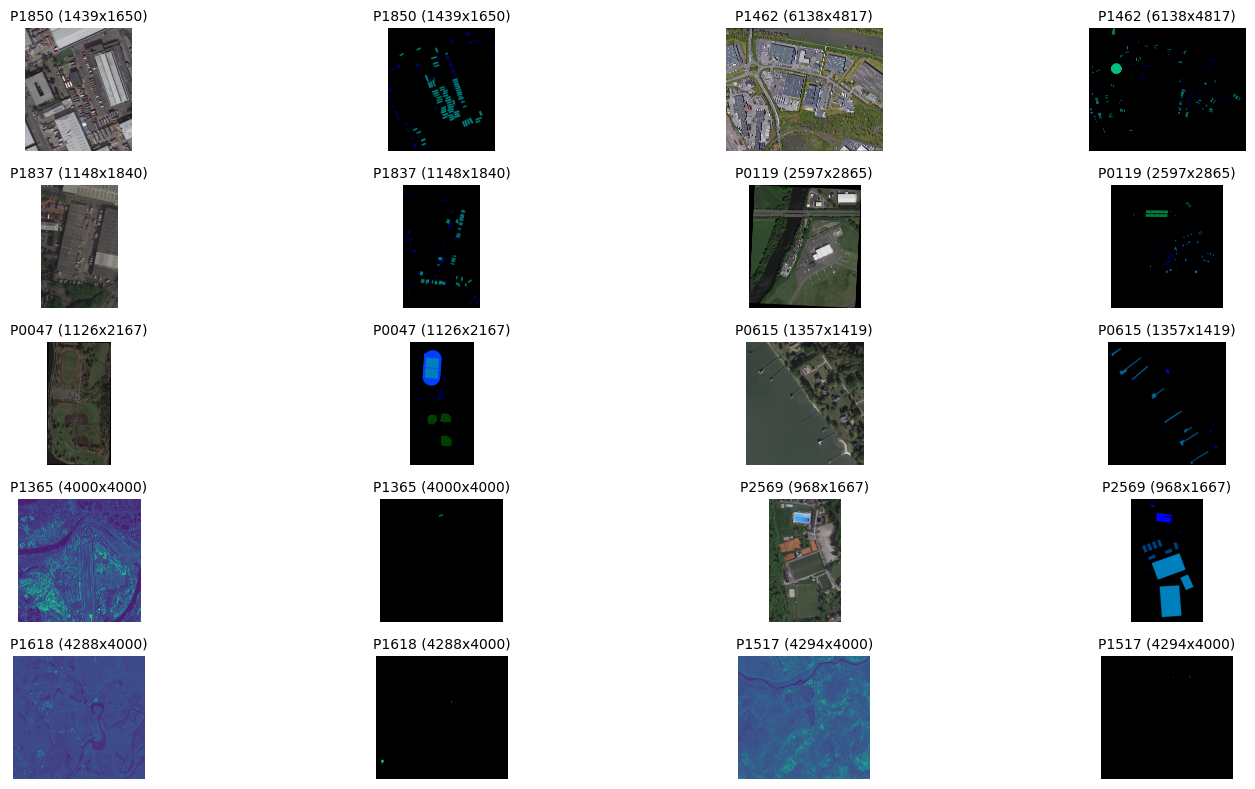

In [14]:
visualize_images(img_dir, mask_dir, seed=seed, mask_postfix='instance_color_RGB')

In [15]:
all_dims = get_all_dims(img_dir)

Number of unique dimensions in images: 1303


In [16]:
min_width = min(dim[0] for dim in all_dims)
min_height = min(dim[1] for dim in all_dims)
print(f"Minimum width: {min_width}")
print(f"Minimum height: {min_height}")

Minimum width: 801
Minimum height: 801


bin size: 40


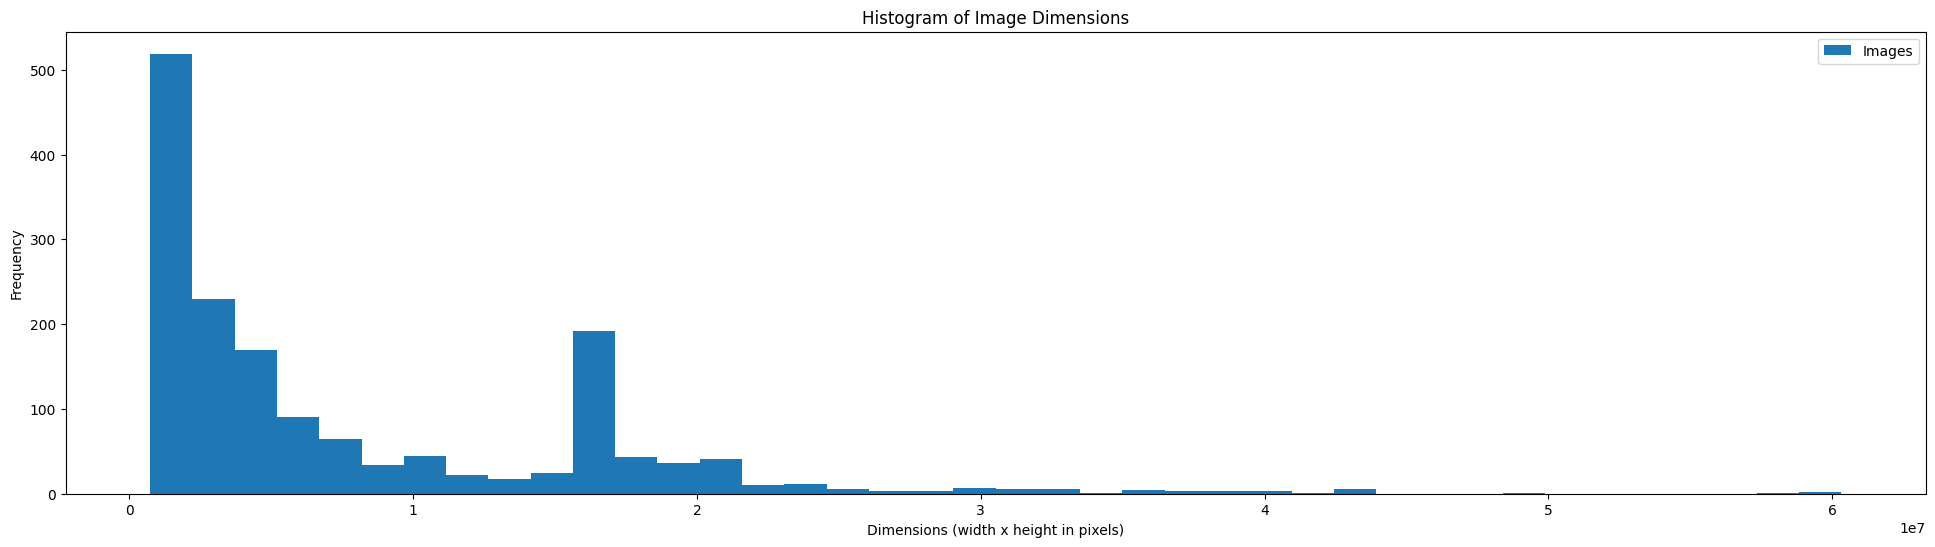

In [17]:
create_histograms_of_dims(img_dir, mult=True)

In [18]:
#create_histograms_of_dims(img_dir)

In [19]:
def count_images_below_threshold(img_dir, threshold: int = 448):
    count = 0
    images_too_small: list = []

    for img_file in os.listdir(img_dir):
        file_path = os.path.join(img_dir, img_file)

        # Open image and get dim
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                if width < threshold or height < threshold:
                    count += 1
                    images_too_small.append(file_path)
        except IOError:
            print(f"Cannot open the file: {file_path}")

    return count, images_too_small

patch_size = 448
num_images_too_small, img_too_small = count_images_below_threshold(img_dir, threshold=patch_size)
num_mask_too_small, mask_too_small = count_images_below_threshold(mask_dir, threshold=patch_size)
print(f'Found {num_images_too_small} images and {num_mask_too_small} masks below threhsold.')

# Remove images and masks
if num_images_too_small == num_images_too_small:
    [os.remove(img) for img in img_too_small]
    [os.remove(img) for img in mask_too_small]
else:
    raise Exception(f"There is a mismatch between your images and masks!")

Found 0 images and 0 masks below threhsold.


In [20]:
n_patches = 30
output_imgs = os.path.join(tmp_data_dir, 'imgs_patches')
output_masks = os.path.join(tmp_data_dir, 'masks_patches')

[os.makedirs(dir, exist_ok=True) for dir in [output_imgs, output_masks]]

[None, None]

## Create Splits

In [31]:
def create_folds_and_split_data(img_folder, mask_folder, 
                                output_dir, seed=42, n_folds=5,
                                mask_postfix='instance_color_RGB') -> tuple:
    # Set random seed
    np.random.seed(seed)
    
    # Create folder structure
    img_output_dir = os.path.join(output_dir, 'tmp_imgs')
    mask_output_dir = os.path.join(output_dir, 'tmp_masks')

    for i in range(n_folds):
        os.makedirs(os.path.join(img_output_dir, f'fold_{i}'), exist_ok=True)
        os.makedirs(os.path.join(mask_output_dir, f'fold_{i}'), exist_ok=True)

    # Shuffle and split images
    img_files = sorted(os.listdir(img_folder))
    np.random.shuffle(img_files)

    fold_size = len(img_files) // n_folds
    print(f'Size of fold: {fold_size}')

    for i, img_file in tqdm(enumerate(img_files), desc='files'):
        fold_num = min(i // fold_size, n_folds - 1)  # Avoid exceeding the number of folds

        # Copy image file
        img_src = os.path.join(img_folder, img_file)
        img_dst = os.path.join(img_output_dir, f'fold_{fold_num}', img_file)
        shutil.copy(img_src, img_dst)

        # Copy corresponding masks
        mask_file = img_file.split('.')[0] + '_' + mask_postfix + '.png'
        mask_src = os.path.join(mask_folder, mask_file)

        mask_dst = os.path.join(mask_output_dir, f'fold_{fold_num}', mask_file)
        shutil.copy(mask_src, mask_dst)
        

    return img_output_dir, mask_output_dir

img_output_dir, mask_output_dir = create_folds_and_split_data(img_dir, mask_dir, output_dir, seed, n_folds=nb_folds)

Size of fold: 320


files: 1600it [00:09, 168.24it/s]


In [32]:
def verify_image_mask_correspondence(output_dir, img_folder, mask_folder, mask_postfix='instance_color_RGB', n_folds=5):
    """
    Verify that every image in each fold has corresponding masks for each category and vice versa,
    and that the total count of images and masks matches the original dataset.

    Args:
    output_dir (str): The base directory where the 'imgs' and 'masks' subdirectories are located.
    img_folder (str): The directory containing the original images.
    mask_folder (str): The directory containing the original masks.
    n_categories (int): Number of categories for each image.
    n_folds (int): Number of folds to check for correspondence.

    Raises:
    Exception: If an image doesn't have corresponding masks, a mask doesn't have a corresponding image,
               or the total count of images and masks doesn't match the original dataset.

    Returns:
    bool: True if all tests pass, False otherwise.
    """
    img_output_dir = os.path.join(output_dir, 'tmp_imgs')
    mask_output_dir = os.path.join(output_dir, 'tmp_masks')
    original_img_count = len(os.listdir(img_folder))
    original_mask_count = len(os.listdir(mask_folder)) 
    
    total_img_count = 0
    total_mask_count = 0

    for i in range(n_folds):
        img_fold_dir = os.path.join(img_output_dir, f'fold_{i}')
        mask_fold_dir = os.path.join(mask_output_dir, f'fold_{i}')

        img_files = set(os.listdir(img_fold_dir))
        mask_files = set(os.listdir(mask_fold_dir))
        total_img_count += len(img_files)
        total_mask_count += len(mask_files)

        # Test 1: Each image has corresponding masks
        for img_file in img_files:
            base_name = os.path.splitext(img_file)[0]
            mask_file = f"{base_name}_{mask_postfix}.png"
            if mask_file not in mask_files:
                raise Exception(f"Image {img_file} in fold_{i} does not have a corresponding mask.")

        # Test 2: Each mask has a corresponding image
        for mask_file in mask_files:
            base_name = mask_file.split('_')[0]
            img_file = f"{base_name}.png"
            if img_file not in img_files:
                raise Exception(f"Mask {mask_file} in fold_{i} does not have a corresponding image.")

    # Test 3: Total count of images and masks matches the original dataset
    if total_img_count != original_img_count or total_mask_count != original_mask_count:
        raise Exception("The total count of images or masks does not match the original dataset.")

    return True

In [33]:
try:
    tests_passed = verify_image_mask_correspondence(output_dir, img_dir, mask_dir, n_folds=nb_folds)
    if tests_passed:
        print("All tests passed successfully.")
except Exception as e:
    print(f"Error: {e}")

All tests passed successfully.


In [34]:
images_patches_dir = os.path.join(output_dir, 'imgs')
masks_patches_dir = os.path.join(output_dir, 'masks')
os.makedirs(images_patches_dir, exist_ok=True)
os.makedirs(masks_patches_dir, exist_ok=True)

In [36]:
def extract_and_save_patches(img_dir, mask_dir, output_imgs_dir, 
                             output_masks_dir, num_patches=30, 
                             patch_size=(256, 256), seed=42, mask_postfix='instance_color_RGB'):
    random.seed(seed)

    # Get all image names
    img_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    for img_file in tqdm(img_files, desc='Extracting patches'):
        img_path = os.path.join(img_dir, img_file)
        base_name, _ = os.path.splitext(img_file)
        mask_file = img_file.split('.')[0] + '_' + mask_postfix + '.png'
        print(f'mask_file: {mask_file}')
        mask_path = os.path.join(mask_dir, mask_file)
        print(f'mask_path: {mask_path}')
        
        with Image.open(img_path) as img:
            for i in range(num_patches):
                # Generate random position for cropping
                x = random.randint(0, img.width - patch_size[0])
                y = random.randint(0, img.height - patch_size[1])

                # Extract and save image patch
                img_patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
                img_patch_file_name = f"{base_name}_patch_{i}.png"
                img_patch.save(os.path.join(output_imgs_dir, img_patch_file_name))

                # Extract and save mask patches 

                if os.path.exists(mask_path):
                    with Image.open(mask_path) as mask:
                        mask_patch = mask.crop((x, y, x + patch_size[0], y + patch_size[1]))
                        mask_patch_file_name = f"{base_name}_patch_{i}.png"
                        mask_patch.save(os.path.join(output_masks_dir, mask_patch_file_name))

In [37]:
def create_patches(src_img_root_dir, src_masks_root_dir, output_imgs_root_dir, output_masks_root_dir, patch_size, nb_folds: int = 5):
    for i in range(nb_folds):
        fold = f'fold_{i}'
        img_dir = os.path.join(src_img_root_dir, fold)
        mask_dir = os.path.join(src_masks_root_dir, fold)

        # Prepare dir to store final data
        output_imgs_dir = os.path.join(output_imgs_root_dir, fold)
        output_masks_dir = os.path.join(output_masks_root_dir, fold)
        os.makedirs(output_imgs_dir, exist_ok=True)
        os.makedirs(output_masks_dir, exist_ok=True)

        extract_and_save_patches(img_dir, mask_dir, output_imgs_dir, output_masks_dir, num_patches=30, patch_size=(patch_size, patch_size), seed=42)

In [38]:
create_patches(img_output_dir, mask_output_dir, images_patches_dir, masks_patches_dir, patch_size, nb_folds=nb_folds)

Extracting patches:   0%|          | 0/320 [00:00<?, ?it/s]

mask_file: P1022_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1022_instance_color_RGB.png


Extracting patches:   0%|          | 1/320 [00:03<18:18,  3.44s/it]

mask_file: P1343_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1343_instance_color_RGB.png


Extracting patches:   1%|          | 2/320 [00:07<20:50,  3.93s/it]

mask_file: P2800_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2800_instance_color_RGB.png


Extracting patches:   1%|          | 3/320 [00:13<26:21,  4.99s/it]

mask_file: P1534_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1534_instance_color_RGB.png


Extracting patches:   1%|▏         | 4/320 [00:18<24:46,  4.70s/it]

mask_file: P0188_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0188_instance_color_RGB.png


Extracting patches:   2%|▏         | 5/320 [00:22<23:10,  4.41s/it]

mask_file: P1652_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1652_instance_color_RGB.png


Extracting patches:   2%|▏         | 6/320 [00:26<22:55,  4.38s/it]

mask_file: P0315_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0315_instance_color_RGB.png


Extracting patches:   2%|▏         | 7/320 [00:29<20:43,  3.97s/it]

mask_file: P0124_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0124_instance_color_RGB.png


Extracting patches:   2%|▎         | 8/320 [00:33<20:34,  3.96s/it]

mask_file: P0488_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0488_instance_color_RGB.png


Extracting patches:   3%|▎         | 9/320 [00:36<19:20,  3.73s/it]

mask_file: P0036_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0036_instance_color_RGB.png


Extracting patches:   3%|▎         | 10/320 [00:44<26:14,  5.08s/it]

mask_file: P0111_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0111_instance_color_RGB.png


Extracting patches:   3%|▎         | 11/320 [00:48<24:26,  4.74s/it]

mask_file: P2196_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2196_instance_color_RGB.png


Extracting patches:   4%|▍         | 12/320 [00:51<20:59,  4.09s/it]

mask_file: P1030_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1030_instance_color_RGB.png


Extracting patches:   4%|▍         | 13/320 [00:55<21:23,  4.18s/it]

mask_file: P1656_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1656_instance_color_RGB.png


Extracting patches:   4%|▍         | 14/320 [01:00<22:31,  4.42s/it]

mask_file: P0204_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0204_instance_color_RGB.png


Extracting patches:   5%|▍         | 15/320 [01:04<21:13,  4.18s/it]

mask_file: P0626_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0626_instance_color_RGB.png


Extracting patches:   5%|▌         | 16/320 [01:08<20:28,  4.04s/it]

mask_file: P2479_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2479_instance_color_RGB.png


Extracting patches:   5%|▌         | 17/320 [01:11<20:01,  3.97s/it]

mask_file: P0440_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0440_instance_color_RGB.png


Extracting patches:   6%|▌         | 18/320 [01:15<18:50,  3.74s/it]

mask_file: P1103_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1103_instance_color_RGB.png


Extracting patches:   6%|▌         | 19/320 [01:18<18:10,  3.62s/it]

mask_file: P0897_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0897_instance_color_RGB.png


Extracting patches:   6%|▋         | 20/320 [01:25<22:56,  4.59s/it]

mask_file: P0538_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0538_instance_color_RGB.png


Extracting patches:   7%|▋         | 21/320 [01:28<21:08,  4.24s/it]

mask_file: P1486_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1486_instance_color_RGB.png


Extracting patches:   7%|▋         | 22/320 [01:32<19:36,  3.95s/it]

mask_file: P2380_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2380_instance_color_RGB.png


Extracting patches:   7%|▋         | 23/320 [01:36<20:14,  4.09s/it]

mask_file: P1707_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1707_instance_color_RGB.png


Extracting patches:   8%|▊         | 24/320 [01:40<20:10,  4.09s/it]

mask_file: P1057_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1057_instance_color_RGB.png


Extracting patches:   8%|▊         | 25/320 [01:47<24:37,  5.01s/it]

mask_file: P0947_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0947_instance_color_RGB.png


Extracting patches:   8%|▊         | 26/320 [01:53<25:31,  5.21s/it]

mask_file: P0946_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0946_instance_color_RGB.png


Extracting patches:   8%|▊         | 27/320 [01:58<25:04,  5.13s/it]

mask_file: P1459_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1459_instance_color_RGB.png


Extracting patches:   9%|▉         | 28/320 [02:07<30:57,  6.36s/it]

mask_file: P1562_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1562_instance_color_RGB.png


Extracting patches:   9%|▉         | 29/320 [02:11<27:58,  5.77s/it]

mask_file: P0944_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0944_instance_color_RGB.png


Extracting patches:   9%|▉         | 30/320 [02:16<26:01,  5.38s/it]

mask_file: P0978_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0978_instance_color_RGB.png


Extracting patches:  10%|▉         | 31/320 [02:19<23:21,  4.85s/it]

mask_file: P0299_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0299_instance_color_RGB.png


Extracting patches:  10%|█         | 32/320 [02:23<20:37,  4.30s/it]

mask_file: P1133_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1133_instance_color_RGB.png


Extracting patches:  10%|█         | 33/320 [02:26<19:16,  4.03s/it]

mask_file: P0936_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0936_instance_color_RGB.png


Extracting patches:  11%|█         | 34/320 [02:30<19:22,  4.06s/it]

mask_file: P2368_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2368_instance_color_RGB.png


Extracting patches:  11%|█         | 35/320 [02:36<21:46,  4.58s/it]

mask_file: P0428_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0428_instance_color_RGB.png


Extracting patches:  11%|█▏        | 36/320 [02:38<18:45,  3.96s/it]

mask_file: P2522_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2522_instance_color_RGB.png


Extracting patches:  12%|█▏        | 37/320 [02:43<19:26,  4.12s/it]

mask_file: P1872_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1872_instance_color_RGB.png


Extracting patches:  12%|█▏        | 38/320 [02:54<28:54,  6.15s/it]

mask_file: P1714_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1714_instance_color_RGB.png


Extracting patches:  12%|█▏        | 39/320 [02:59<26:53,  5.74s/it]

mask_file: P2507_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2507_instance_color_RGB.png


Extracting patches:  12%|█▎        | 40/320 [03:03<24:46,  5.31s/it]

mask_file: P2641_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2641_instance_color_RGB.png


Extracting patches:  13%|█▎        | 41/320 [03:22<43:52,  9.44s/it]

mask_file: P1141_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1141_instance_color_RGB.png


Extracting patches:  13%|█▎        | 42/320 [03:30<42:24,  9.15s/it]

mask_file: P0999_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0999_instance_color_RGB.png


Extracting patches:  13%|█▎        | 43/320 [03:34<34:11,  7.41s/it]

mask_file: P0541_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0541_instance_color_RGB.png


Extracting patches:  14%|█▍        | 44/320 [03:37<28:19,  6.16s/it]

mask_file: P2394_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2394_instance_color_RGB.png


Extracting patches:  14%|█▍        | 45/320 [03:41<25:26,  5.55s/it]

mask_file: P2226_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2226_instance_color_RGB.png


Extracting patches:  14%|█▍        | 46/320 [03:46<24:19,  5.33s/it]

mask_file: P0445_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0445_instance_color_RGB.png


Extracting patches:  15%|█▍        | 47/320 [03:49<21:50,  4.80s/it]

mask_file: P2590_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2590_instance_color_RGB.png


Extracting patches:  15%|█▌        | 48/320 [03:53<20:10,  4.45s/it]

mask_file: P1364_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1364_instance_color_RGB.png


Extracting patches:  15%|█▌        | 49/320 [03:57<18:43,  4.14s/it]

mask_file: P0610_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0610_instance_color_RGB.png


Extracting patches:  16%|█▌        | 50/320 [04:00<17:39,  3.92s/it]

mask_file: P1934_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1934_instance_color_RGB.png


Extracting patches:  16%|█▌        | 51/320 [04:03<16:22,  3.65s/it]

mask_file: P2514_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2514_instance_color_RGB.png


Extracting patches:  16%|█▋        | 52/320 [04:07<16:49,  3.77s/it]

mask_file: P1816_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1816_instance_color_RGB.png


Extracting patches:  17%|█▋        | 53/320 [04:11<17:01,  3.83s/it]

mask_file: P0723_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0723_instance_color_RGB.png


Extracting patches:  17%|█▋        | 54/320 [04:15<16:39,  3.76s/it]

mask_file: P1164_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1164_instance_color_RGB.png


Extracting patches:  17%|█▋        | 55/320 [04:21<19:40,  4.45s/it]

mask_file: P2095_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2095_instance_color_RGB.png


Extracting patches:  18%|█▊        | 56/320 [04:24<18:38,  4.24s/it]

mask_file: P1940_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1940_instance_color_RGB.png


Extracting patches:  18%|█▊        | 57/320 [04:28<17:13,  3.93s/it]

mask_file: P0613_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0613_instance_color_RGB.png


Extracting patches:  18%|█▊        | 58/320 [04:30<15:45,  3.61s/it]

mask_file: P1094_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1094_instance_color_RGB.png


Extracting patches:  18%|█▊        | 59/320 [04:34<15:59,  3.68s/it]

mask_file: P2458_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2458_instance_color_RGB.png


Extracting patches:  19%|█▉        | 60/320 [04:38<16:00,  3.70s/it]

mask_file: P1751_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1751_instance_color_RGB.png


Extracting patches:  19%|█▉        | 61/320 [04:42<16:45,  3.88s/it]

mask_file: P1607_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1607_instance_color_RGB.png


Extracting patches:  19%|█▉        | 62/320 [04:47<17:04,  3.97s/it]

mask_file: P0349_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0349_instance_color_RGB.png


Extracting patches:  20%|█▉        | 63/320 [04:53<19:59,  4.67s/it]

mask_file: P1336_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1336_instance_color_RGB.png


Extracting patches:  20%|██        | 64/320 [04:58<20:42,  4.86s/it]

mask_file: P2646_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2646_instance_color_RGB.png


Extracting patches:  20%|██        | 65/320 [05:02<19:23,  4.56s/it]

mask_file: P1839_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1839_instance_color_RGB.png


Extracting patches:  21%|██        | 66/320 [05:06<18:17,  4.32s/it]

mask_file: P0431_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0431_instance_color_RGB.png


Extracting patches:  21%|██        | 67/320 [05:09<16:56,  4.02s/it]

mask_file: P2541_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2541_instance_color_RGB.png


Extracting patches:  21%|██▏       | 68/320 [05:14<18:28,  4.40s/it]

mask_file: P0391_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0391_instance_color_RGB.png


Extracting patches:  22%|██▏       | 69/320 [05:18<17:28,  4.18s/it]

mask_file: P0049_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0049_instance_color_RGB.png


Extracting patches:  22%|██▏       | 70/320 [05:22<17:11,  4.12s/it]

mask_file: P1208_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1208_instance_color_RGB.png


Extracting patches:  22%|██▏       | 71/320 [05:26<17:11,  4.14s/it]

mask_file: P0363_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0363_instance_color_RGB.png


Extracting patches:  22%|██▎       | 72/320 [05:30<16:17,  3.94s/it]

mask_file: P2001_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2001_instance_color_RGB.png


Extracting patches:  23%|██▎       | 73/320 [05:33<15:10,  3.69s/it]

mask_file: P0021_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0021_instance_color_RGB.png


Extracting patches:  23%|██▎       | 74/320 [05:38<17:31,  4.27s/it]

mask_file: P0872_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0872_instance_color_RGB.png


Extracting patches:  23%|██▎       | 75/320 [05:42<17:01,  4.17s/it]

mask_file: P1052_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1052_instance_color_RGB.png


Extracting patches:  24%|██▍       | 76/320 [05:46<15:48,  3.89s/it]

mask_file: P2337_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2337_instance_color_RGB.png


Extracting patches:  24%|██▍       | 77/320 [05:51<17:02,  4.21s/it]

mask_file: P2494_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2494_instance_color_RGB.png


Extracting patches:  24%|██▍       | 78/320 [05:54<16:42,  4.14s/it]

mask_file: P1131_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1131_instance_color_RGB.png


Extracting patches:  25%|██▍       | 79/320 [06:03<22:12,  5.53s/it]

mask_file: P2099_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2099_instance_color_RGB.png


Extracting patches:  25%|██▌       | 80/320 [06:07<19:43,  4.93s/it]

mask_file: P1258_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1258_instance_color_RGB.png


Extracting patches:  25%|██▌       | 81/320 [06:12<19:46,  4.97s/it]

mask_file: P0227_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0227_instance_color_RGB.png


Extracting patches:  26%|██▌       | 82/320 [06:15<17:21,  4.38s/it]

mask_file: P0878_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0878_instance_color_RGB.png


Extracting patches:  26%|██▌       | 83/320 [06:21<18:51,  4.78s/it]

mask_file: P2343_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2343_instance_color_RGB.png


Extracting patches:  26%|██▋       | 84/320 [06:25<18:57,  4.82s/it]

mask_file: P0869_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0869_instance_color_RGB.png


Extracting patches:  27%|██▋       | 85/320 [06:29<17:09,  4.38s/it]

mask_file: P1923_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1923_instance_color_RGB.png


Extracting patches:  27%|██▋       | 86/320 [06:32<15:41,  4.02s/it]

mask_file: P2359_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2359_instance_color_RGB.png


Extracting patches:  27%|██▋       | 87/320 [06:36<15:44,  4.05s/it]

mask_file: P0103_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0103_instance_color_RGB.png


Extracting patches:  28%|██▊       | 88/320 [06:39<14:23,  3.72s/it]

mask_file: P0340_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0340_instance_color_RGB.png


Extracting patches:  28%|██▊       | 89/320 [06:44<15:18,  3.98s/it]

mask_file: P2523_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2523_instance_color_RGB.png


Extracting patches:  28%|██▊       | 90/320 [06:48<16:00,  4.17s/it]

mask_file: P0437_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0437_instance_color_RGB.png


Extracting patches:  28%|██▊       | 91/320 [06:51<14:09,  3.71s/it]

mask_file: P2194_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2194_instance_color_RGB.png


Extracting patches:  29%|██▉       | 92/320 [06:55<14:16,  3.76s/it]

mask_file: P1238_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1238_instance_color_RGB.png


Extracting patches:  29%|██▉       | 93/320 [06:59<14:39,  3.87s/it]

mask_file: P0358_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0358_instance_color_RGB.png


Extracting patches:  29%|██▉       | 94/320 [07:02<14:11,  3.77s/it]

mask_file: P1416_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1416_instance_color_RGB.png


Extracting patches:  30%|██▉       | 95/320 [07:07<14:55,  3.98s/it]

mask_file: P1005_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1005_instance_color_RGB.png


Extracting patches:  30%|███       | 96/320 [07:12<15:50,  4.24s/it]

mask_file: P2716_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2716_instance_color_RGB.png


Extracting patches:  30%|███       | 97/320 [07:17<16:22,  4.41s/it]

mask_file: P0070_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0070_instance_color_RGB.png


Extracting patches:  31%|███       | 98/320 [07:20<14:58,  4.05s/it]

mask_file: P0475_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0475_instance_color_RGB.png


Extracting patches:  31%|███       | 99/320 [07:24<14:46,  4.01s/it]

mask_file: P0920_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0920_instance_color_RGB.png


Extracting patches:  31%|███▏      | 100/320 [07:28<14:37,  3.99s/it]

mask_file: P2349_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2349_instance_color_RGB.png


Extracting patches:  32%|███▏      | 101/320 [07:32<14:34,  3.99s/it]

mask_file: P1088_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1088_instance_color_RGB.png


Extracting patches:  32%|███▏      | 102/320 [07:35<14:06,  3.89s/it]

mask_file: P2790_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2790_instance_color_RGB.png


Extracting patches:  32%|███▏      | 103/320 [07:42<17:13,  4.76s/it]

mask_file: P0615_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0615_instance_color_RGB.png


Extracting patches:  32%|███▎      | 104/320 [07:45<15:27,  4.29s/it]

mask_file: P1673_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1673_instance_color_RGB.png


Extracting patches:  33%|███▎      | 105/320 [07:50<15:42,  4.38s/it]

mask_file: P1457_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1457_instance_color_RGB.png


Extracting patches:  33%|███▎      | 106/320 [07:59<21:10,  5.94s/it]

mask_file: P0367_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0367_instance_color_RGB.png


Extracting patches:  33%|███▎      | 107/320 [08:03<18:22,  5.18s/it]

mask_file: P2129_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2129_instance_color_RGB.png


Extracting patches:  34%|███▍      | 108/320 [08:06<16:17,  4.61s/it]

mask_file: P0625_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0625_instance_color_RGB.png


Extracting patches:  34%|███▍      | 109/320 [08:09<14:35,  4.15s/it]

mask_file: P1277_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1277_instance_color_RGB.png


Extracting patches:  34%|███▍      | 110/320 [08:13<14:23,  4.11s/it]

mask_file: P1297_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1297_instance_color_RGB.png


Extracting patches:  35%|███▍      | 111/320 [08:17<13:54,  3.99s/it]

mask_file: P1272_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1272_instance_color_RGB.png


Extracting patches:  35%|███▌      | 112/320 [08:21<13:59,  4.04s/it]

mask_file: P0067_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0067_instance_color_RGB.png


Extracting patches:  35%|███▌      | 113/320 [08:25<13:19,  3.86s/it]

mask_file: P1745_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1745_instance_color_RGB.png


Extracting patches:  36%|███▌      | 114/320 [08:29<13:35,  3.96s/it]

mask_file: P1482_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1482_instance_color_RGB.png


Extracting patches:  36%|███▌      | 115/320 [08:33<14:02,  4.11s/it]

mask_file: P0091_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0091_instance_color_RGB.png


Extracting patches:  36%|███▋      | 116/320 [08:37<13:39,  4.02s/it]

mask_file: P0190_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0190_instance_color_RGB.png


Extracting patches:  37%|███▋      | 117/320 [08:41<13:40,  4.04s/it]

mask_file: P0987_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0987_instance_color_RGB.png


Extracting patches:  37%|███▋      | 118/320 [08:45<13:10,  3.91s/it]

mask_file: P0047_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0047_instance_color_RGB.png


Extracting patches:  37%|███▋      | 119/320 [08:48<12:49,  3.83s/it]

mask_file: P2492_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2492_instance_color_RGB.png


Extracting patches:  38%|███▊      | 120/320 [08:52<12:43,  3.82s/it]

mask_file: P2696_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2696_instance_color_RGB.png


Extracting patches:  38%|███▊      | 121/320 [08:58<14:22,  4.33s/it]

mask_file: P2478_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2478_instance_color_RGB.png


Extracting patches:  38%|███▊      | 122/320 [09:01<13:28,  4.08s/it]

mask_file: P0848_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0848_instance_color_RGB.png


Extracting patches:  38%|███▊      | 123/320 [09:05<12:41,  3.87s/it]

mask_file: P0689_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0689_instance_color_RGB.png


Extracting patches:  39%|███▉      | 124/320 [09:08<12:20,  3.78s/it]

mask_file: P1557_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1557_instance_color_RGB.png


Extracting patches:  39%|███▉      | 125/320 [09:13<13:00,  4.00s/it]

mask_file: P2517_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2517_instance_color_RGB.png


Extracting patches:  39%|███▉      | 126/320 [09:16<12:42,  3.93s/it]

mask_file: P2777_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2777_instance_color_RGB.png


Extracting patches:  40%|███▉      | 127/320 [09:22<14:20,  4.46s/it]

mask_file: P0789_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0789_instance_color_RGB.png


Extracting patches:  40%|████      | 128/320 [09:26<13:24,  4.19s/it]

mask_file: P2240_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2240_instance_color_RGB.png


Extracting patches:  40%|████      | 129/320 [09:29<12:59,  4.08s/it]

mask_file: P1075_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1075_instance_color_RGB.png


Extracting patches:  41%|████      | 130/320 [09:35<13:59,  4.42s/it]

mask_file: P1907_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1907_instance_color_RGB.png


Extracting patches:  41%|████      | 131/320 [09:38<12:38,  4.01s/it]

mask_file: P0146_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0146_instance_color_RGB.png


Extracting patches:  41%|████▏     | 132/320 [09:43<13:22,  4.27s/it]

mask_file: P0857_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0857_instance_color_RGB.png


Extracting patches:  42%|████▏     | 133/320 [09:47<13:08,  4.21s/it]

mask_file: P1686_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1686_instance_color_RGB.png


Extracting patches:  42%|████▏     | 134/320 [09:51<13:04,  4.22s/it]

mask_file: P1016_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1016_instance_color_RGB.png


Extracting patches:  42%|████▏     | 135/320 [09:54<12:22,  4.01s/it]

mask_file: P2755_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2755_instance_color_RGB.png


Extracting patches:  42%|████▎     | 136/320 [10:00<13:48,  4.50s/it]

mask_file: P1861_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1861_instance_color_RGB.png


Extracting patches:  43%|████▎     | 137/320 [10:05<14:20,  4.70s/it]

mask_file: P1092_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1092_instance_color_RGB.png


Extracting patches:  43%|████▎     | 138/320 [10:09<13:21,  4.40s/it]

mask_file: P0218_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0218_instance_color_RGB.png


Extracting patches:  43%|████▎     | 139/320 [10:14<13:51,  4.60s/it]

mask_file: P1561_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1561_instance_color_RGB.png


Extracting patches:  44%|████▍     | 140/320 [10:18<13:12,  4.40s/it]

mask_file: P0339_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0339_instance_color_RGB.png


Extracting patches:  44%|████▍     | 141/320 [10:22<13:01,  4.36s/it]

mask_file: P1996_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1996_instance_color_RGB.png


Extracting patches:  44%|████▍     | 142/320 [10:26<12:21,  4.16s/it]

mask_file: P2389_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2389_instance_color_RGB.png


Extracting patches:  45%|████▍     | 143/320 [10:30<12:08,  4.12s/it]

mask_file: P2743_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2743_instance_color_RGB.png


Extracting patches:  45%|████▌     | 144/320 [10:36<13:56,  4.76s/it]

mask_file: P0465_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0465_instance_color_RGB.png


Extracting patches:  45%|████▌     | 145/320 [10:40<12:58,  4.45s/it]

mask_file: P0432_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0432_instance_color_RGB.png


Extracting patches:  46%|████▌     | 146/320 [10:42<11:14,  3.88s/it]

mask_file: P2067_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2067_instance_color_RGB.png


Extracting patches:  46%|████▌     | 147/320 [10:46<11:07,  3.86s/it]

mask_file: P0052_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0052_instance_color_RGB.png


Extracting patches:  46%|████▋     | 148/320 [10:50<11:08,  3.89s/it]

mask_file: P1753_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1753_instance_color_RGB.png


Extracting patches:  47%|████▋     | 149/320 [10:55<11:39,  4.09s/it]

mask_file: P1353_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1353_instance_color_RGB.png


Extracting patches:  47%|████▋     | 150/320 [10:59<11:50,  4.18s/it]

mask_file: P1473_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1473_instance_color_RGB.png


Extracting patches:  47%|████▋     | 151/320 [11:03<11:07,  3.95s/it]

mask_file: P0952_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0952_instance_color_RGB.png


Extracting patches:  48%|████▊     | 152/320 [11:08<12:30,  4.47s/it]

mask_file: P0554_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0554_instance_color_RGB.png


Extracting patches:  48%|████▊     | 153/320 [11:11<11:16,  4.05s/it]

mask_file: P2063_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2063_instance_color_RGB.png


Extracting patches:  48%|████▊     | 154/320 [11:14<10:19,  3.73s/it]

mask_file: P0461_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0461_instance_color_RGB.png


Extracting patches:  48%|████▊     | 155/320 [11:18<10:01,  3.65s/it]

mask_file: P2608_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2608_instance_color_RGB.png


Extracting patches:  49%|████▉     | 156/320 [11:22<10:44,  3.93s/it]

mask_file: P0738_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0738_instance_color_RGB.png


Extracting patches:  49%|████▉     | 157/320 [11:26<10:38,  3.92s/it]

mask_file: P0518_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0518_instance_color_RGB.png


Extracting patches:  49%|████▉     | 158/320 [11:29<09:54,  3.67s/it]

mask_file: P0780_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0780_instance_color_RGB.png


Extracting patches:  50%|████▉     | 159/320 [11:34<10:13,  3.81s/it]

mask_file: P0888_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0888_instance_color_RGB.png


Extracting patches:  50%|█████     | 160/320 [11:40<11:55,  4.47s/it]

mask_file: P1386_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1386_instance_color_RGB.png


Extracting patches:  50%|█████     | 161/320 [11:45<12:31,  4.73s/it]

mask_file: P1599_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1599_instance_color_RGB.png


Extracting patches:  51%|█████     | 162/320 [11:50<12:40,  4.81s/it]

mask_file: P0207_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0207_instance_color_RGB.png


Extracting patches:  51%|█████     | 163/320 [11:53<11:20,  4.34s/it]

mask_file: P2082_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2082_instance_color_RGB.png


Extracting patches:  51%|█████▏    | 164/320 [11:56<10:27,  4.02s/it]

mask_file: P2770_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2770_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 165/320 [12:00<10:09,  3.93s/it]

mask_file: P1418_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1418_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 166/320 [12:05<10:57,  4.27s/it]

mask_file: P1866_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1866_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 167/320 [12:12<12:36,  4.94s/it]

mask_file: P2563_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2563_instance_color_RGB.png


Extracting patches:  52%|█████▎    | 168/320 [12:16<11:51,  4.68s/it]

mask_file: P1859_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1859_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 169/320 [12:19<10:40,  4.24s/it]

mask_file: P1078_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1078_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 170/320 [12:23<10:23,  4.16s/it]

mask_file: P0825_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0825_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 171/320 [12:27<10:05,  4.06s/it]

mask_file: P1938_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1938_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 172/320 [12:30<09:47,  3.97s/it]

mask_file: P0572_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0572_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 173/320 [12:34<09:14,  3.77s/it]

mask_file: P2638_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2638_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 174/320 [12:37<08:57,  3.68s/it]

mask_file: P1565_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1565_instance_color_RGB.png


Extracting patches:  55%|█████▍    | 175/320 [12:41<09:13,  3.81s/it]

mask_file: P1247_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1247_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 176/320 [12:46<09:37,  4.01s/it]

mask_file: P0396_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0396_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 177/320 [12:50<09:19,  3.91s/it]

mask_file: P0785_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0785_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 178/320 [12:55<10:00,  4.23s/it]

mask_file: P2585_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2585_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 179/320 [12:58<09:35,  4.08s/it]

mask_file: P1249_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1249_instance_color_RGB.png


Extracting patches:  56%|█████▋    | 180/320 [13:02<09:26,  4.04s/it]

mask_file: P0194_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0194_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 181/320 [13:06<09:04,  3.92s/it]

mask_file: P0522_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0522_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 182/320 [13:09<08:26,  3.67s/it]

mask_file: P1841_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1841_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 183/320 [13:13<08:43,  3.82s/it]

mask_file: P0945_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0945_instance_color_RGB.png


Extracting patches:  57%|█████▊    | 184/320 [13:17<08:31,  3.76s/it]

mask_file: P0702_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0702_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 185/320 [13:20<08:13,  3.66s/it]

mask_file: P1497_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1497_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 186/320 [13:27<10:22,  4.65s/it]

mask_file: P0098_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0098_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 187/320 [13:30<09:13,  4.16s/it]

mask_file: P2708_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2708_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 188/320 [13:34<09:16,  4.22s/it]

mask_file: P0327_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0327_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 189/320 [13:38<08:56,  4.09s/it]

mask_file: P2019_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2019_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 190/320 [13:42<08:27,  3.90s/it]

mask_file: P0799_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0799_instance_color_RGB.png


Extracting patches:  60%|█████▉    | 191/320 [13:46<08:18,  3.86s/it]

mask_file: P1558_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1558_instance_color_RGB.png


Extracting patches:  60%|██████    | 192/320 [13:49<08:16,  3.88s/it]

mask_file: P1213_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1213_instance_color_RGB.png


Extracting patches:  60%|██████    | 193/320 [13:54<08:45,  4.14s/it]

mask_file: P2733_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2733_instance_color_RGB.png


Extracting patches:  61%|██████    | 194/320 [14:00<09:40,  4.61s/it]

mask_file: P2002_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2002_instance_color_RGB.png


Extracting patches:  61%|██████    | 195/320 [14:03<08:51,  4.25s/it]

mask_file: P1851_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1851_instance_color_RGB.png


Extracting patches:  61%|██████▏   | 196/320 [14:07<08:38,  4.18s/it]

mask_file: P0874_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0874_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 197/320 [14:11<08:23,  4.09s/it]

mask_file: P0665_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0665_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 198/320 [14:15<08:03,  3.96s/it]

mask_file: P1283_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1283_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 199/320 [14:19<07:52,  3.91s/it]

mask_file: P1221_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1221_instance_color_RGB.png


Extracting patches:  62%|██████▎   | 200/320 [14:22<07:41,  3.85s/it]

mask_file: P0853_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0853_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 201/320 [14:26<07:29,  3.78s/it]

mask_file: P1267_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1267_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 202/320 [14:30<07:37,  3.88s/it]

mask_file: P0755_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0755_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 203/320 [14:34<07:25,  3.81s/it]

mask_file: P2601_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2601_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 204/320 [14:40<08:30,  4.40s/it]

mask_file: P2438_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2438_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 205/320 [14:43<08:01,  4.18s/it]

mask_file: P1680_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1680_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 206/320 [14:48<08:10,  4.31s/it]

mask_file: P2388_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2388_instance_color_RGB.png


Extracting patches:  65%|██████▍   | 207/320 [14:52<07:47,  4.14s/it]

mask_file: P2728_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2728_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 208/320 [14:57<08:23,  4.49s/it]

mask_file: P0685_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0685_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 209/320 [15:00<07:51,  4.24s/it]

mask_file: P0953_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0953_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 210/320 [15:04<07:33,  4.12s/it]

mask_file: P0629_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0629_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 211/320 [15:08<07:03,  3.88s/it]

mask_file: P2597_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2597_instance_color_RGB.png


Extracting patches:  66%|██████▋   | 212/320 [15:12<07:06,  3.95s/it]

mask_file: P1740_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1740_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 213/320 [15:16<07:11,  4.03s/it]

mask_file: P1433_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1433_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 214/320 [15:20<07:15,  4.11s/it]

mask_file: P2408_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2408_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 215/320 [15:24<07:14,  4.13s/it]

mask_file: P1384_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1384_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 216/320 [15:39<12:44,  7.35s/it]

mask_file: P2225_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2225_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 217/320 [15:43<10:44,  6.25s/it]

mask_file: P2421_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2421_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 218/320 [15:47<09:34,  5.64s/it]

mask_file: P0544_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0544_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 219/320 [15:50<08:15,  4.91s/it]

mask_file: P0479_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0479_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 220/320 [15:54<07:24,  4.44s/it]

mask_file: P1587_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1587_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 221/320 [15:57<06:50,  4.15s/it]

mask_file: P2256_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2256_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 222/320 [16:01<06:46,  4.15s/it]

mask_file: P2017_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2017_instance_color_RGB.png


Extracting patches:  70%|██████▉   | 223/320 [16:04<06:11,  3.83s/it]

mask_file: P1977_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1977_instance_color_RGB.png


Extracting patches:  70%|███████   | 224/320 [16:08<06:09,  3.84s/it]

mask_file: P1864_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1864_instance_color_RGB.png


Extracting patches:  70%|███████   | 225/320 [16:12<06:09,  3.89s/it]

mask_file: P2599_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2599_instance_color_RGB.png


Extracting patches:  71%|███████   | 226/320 [16:16<05:58,  3.81s/it]

mask_file: P2753_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2753_instance_color_RGB.png


Extracting patches:  71%|███████   | 227/320 [16:21<06:21,  4.10s/it]

mask_file: P0482_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0482_instance_color_RGB.png


Extracting patches:  71%|███████▏  | 228/320 [16:24<05:50,  3.81s/it]

mask_file: P2462_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2462_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 229/320 [16:28<05:58,  3.94s/it]

mask_file: P0226_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0226_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 230/320 [16:31<05:35,  3.73s/it]

mask_file: P1860_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1860_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 231/320 [16:35<05:30,  3.72s/it]

mask_file: P1098_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1098_instance_color_RGB.png


Extracting patches:  72%|███████▎  | 232/320 [16:39<05:35,  3.82s/it]

mask_file: P2692_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2692_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 233/320 [16:43<05:45,  3.97s/it]

mask_file: P2066_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2066_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 234/320 [16:47<05:23,  3.76s/it]

mask_file: P2724_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2724_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 235/320 [16:52<05:53,  4.16s/it]

mask_file: P0133_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0133_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 236/320 [16:55<05:34,  3.99s/it]

mask_file: P2685_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2685_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 237/320 [16:59<05:30,  3.98s/it]

mask_file: P2154_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2154_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 238/320 [17:02<05:05,  3.73s/it]

mask_file: P2032_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2032_instance_color_RGB.png


Extracting patches:  75%|███████▍  | 239/320 [17:06<04:57,  3.67s/it]

mask_file: P1641_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1641_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 240/320 [17:11<05:32,  4.15s/it]

mask_file: P0322_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0322_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 241/320 [17:15<05:17,  4.02s/it]

mask_file: P2206_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2206_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 242/320 [17:19<05:03,  3.89s/it]

mask_file: P0974_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0974_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 243/320 [17:23<05:07,  3.99s/it]

mask_file: P0117_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0117_instance_color_RGB.png


Extracting patches:  76%|███████▋  | 244/320 [17:26<04:52,  3.84s/it]

mask_file: P0759_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0759_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 245/320 [17:30<04:39,  3.72s/it]

mask_file: P2617_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2617_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 246/320 [17:33<04:25,  3.59s/it]

mask_file: P1055_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1055_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 247/320 [17:42<06:15,  5.14s/it]

mask_file: P0586_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0586_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 248/320 [17:45<05:30,  4.60s/it]

mask_file: P1062_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1062_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 249/320 [17:50<05:25,  4.59s/it]

mask_file: P1990_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1990_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 250/320 [17:53<04:54,  4.20s/it]

mask_file: P2506_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2506_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 251/320 [17:57<04:49,  4.19s/it]

mask_file: P0967_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0967_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 252/320 [18:02<04:52,  4.30s/it]

mask_file: P0948_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0948_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 253/320 [18:06<04:50,  4.33s/it]

mask_file: P0563_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0563_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 254/320 [18:09<04:19,  3.94s/it]

mask_file: P1161_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1161_instance_color_RGB.png


Extracting patches:  80%|███████▉  | 255/320 [18:24<07:51,  7.26s/it]

mask_file: P1509_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1509_instance_color_RGB.png


Extracting patches:  80%|████████  | 256/320 [18:31<07:33,  7.09s/it]

mask_file: P1713_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1713_instance_color_RGB.png


Extracting patches:  80%|████████  | 257/320 [18:35<06:37,  6.31s/it]

mask_file: P0844_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0844_instance_color_RGB.png


Extracting patches:  81%|████████  | 258/320 [18:39<05:35,  5.41s/it]

mask_file: P2355_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2355_instance_color_RGB.png


Extracting patches:  81%|████████  | 259/320 [18:43<05:12,  5.13s/it]

mask_file: P1354_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1354_instance_color_RGB.png


Extracting patches:  81%|████████▏ | 260/320 [18:48<04:58,  4.97s/it]

mask_file: P1541_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1541_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 261/320 [18:52<04:34,  4.66s/it]

mask_file: P1531_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1531_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 262/320 [18:56<04:21,  4.50s/it]

mask_file: P0624_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0624_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 263/320 [18:59<03:55,  4.13s/it]

mask_file: P1793_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1793_instance_color_RGB.png


Extracting patches:  82%|████████▎ | 264/320 [19:06<04:45,  5.09s/it]

mask_file: P0487_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0487_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 265/320 [19:10<04:13,  4.62s/it]

mask_file: P2385_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2385_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 266/320 [19:14<04:01,  4.48s/it]

mask_file: P1980_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1980_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 267/320 [19:18<03:41,  4.18s/it]

mask_file: P1063_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1063_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 268/320 [19:21<03:30,  4.05s/it]

mask_file: P1376_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1376_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 269/320 [19:31<04:58,  5.85s/it]

mask_file: P0627_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0627_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 270/320 [19:35<04:22,  5.25s/it]

mask_file: P2792_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2792_instance_color_RGB.png


Extracting patches:  85%|████████▍ | 271/320 [19:39<03:53,  4.77s/it]

mask_file: P0968_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0968_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 272/320 [19:43<03:37,  4.52s/it]

mask_file: P0122_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0122_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 273/320 [19:46<03:15,  4.15s/it]

mask_file: P1432_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1432_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 274/320 [19:54<04:04,  5.31s/it]

mask_file: P0249_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0249_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 275/320 [19:58<03:34,  4.76s/it]

mask_file: P0926_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0926_instance_color_RGB.png


Extracting patches:  86%|████████▋ | 276/320 [20:02<03:24,  4.64s/it]

mask_file: P2250_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2250_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 277/320 [20:07<03:20,  4.67s/it]

mask_file: P1466_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1466_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 278/320 [20:24<05:54,  8.43s/it]

mask_file: P1778_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1778_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 279/320 [20:30<05:17,  7.74s/it]

mask_file: P0761_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0761_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 280/320 [20:34<04:24,  6.61s/it]

mask_file: P1099_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1099_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 281/320 [20:37<03:38,  5.60s/it]

mask_file: P0256_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0256_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 282/320 [20:40<03:04,  4.86s/it]

mask_file: P0763_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0763_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 283/320 [20:44<02:46,  4.49s/it]

mask_file: P2282_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2282_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 284/320 [20:49<02:50,  4.73s/it]

mask_file: P2065_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2065_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 285/320 [20:52<02:26,  4.20s/it]

mask_file: P2160_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2160_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 286/320 [20:56<02:16,  4.00s/it]

mask_file: P0703_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0703_instance_color_RGB.png


Extracting patches:  90%|████████▉ | 287/320 [21:00<02:11,  3.99s/it]

mask_file: P1307_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1307_instance_color_RGB.png


Extracting patches:  90%|█████████ | 288/320 [21:04<02:09,  4.04s/it]

mask_file: P0597_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0597_instance_color_RGB.png


Extracting patches:  90%|█████████ | 289/320 [21:07<01:55,  3.72s/it]

mask_file: P1969_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1969_instance_color_RGB.png


Extracting patches:  91%|█████████ | 290/320 [21:10<01:46,  3.56s/it]

mask_file: P0668_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0668_instance_color_RGB.png


Extracting patches:  91%|█████████ | 291/320 [21:13<01:40,  3.45s/it]

mask_file: P2690_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2690_instance_color_RGB.png


Extracting patches:  91%|█████████▏| 292/320 [21:17<01:42,  3.66s/it]

mask_file: P0086_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0086_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 293/320 [21:21<01:35,  3.53s/it]

mask_file: P0140_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0140_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 294/320 [21:24<01:32,  3.57s/it]

mask_file: P0727_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0727_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 295/320 [21:28<01:32,  3.71s/it]

mask_file: P1434_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1434_instance_color_RGB.png


Extracting patches:  92%|█████████▎| 296/320 [21:32<01:31,  3.83s/it]

mask_file: P2503_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2503_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 297/320 [21:37<01:31,  3.96s/it]

mask_file: P0653_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0653_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 298/320 [21:40<01:24,  3.84s/it]

mask_file: P1501_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1501_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 299/320 [21:45<01:24,  4.04s/it]

mask_file: P0550_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0550_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 300/320 [21:48<01:15,  3.75s/it]

mask_file: P0699_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0699_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 301/320 [21:51<01:06,  3.52s/it]

mask_file: P1610_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1610_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 302/320 [21:55<01:07,  3.73s/it]

mask_file: P2465_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2465_instance_color_RGB.png


Extracting patches:  95%|█████████▍| 303/320 [21:59<01:03,  3.75s/it]

mask_file: P1139_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1139_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 304/320 [22:16<02:03,  7.70s/it]

mask_file: P1606_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1606_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 305/320 [22:20<01:39,  6.62s/it]

mask_file: P2164_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2164_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 306/320 [22:26<01:30,  6.50s/it]

mask_file: P1167_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1167_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 307/320 [22:32<01:24,  6.46s/it]

mask_file: P0419_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0419_instance_color_RGB.png


Extracting patches:  96%|█████████▋| 308/320 [22:34<01:01,  5.10s/it]

mask_file: P0300_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0300_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 309/320 [22:37<00:47,  4.34s/it]

mask_file: P0128_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0128_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 310/320 [22:39<00:37,  3.80s/it]

mask_file: P0596_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0596_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 311/320 [22:43<00:32,  3.57s/it]

mask_file: P1065_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1065_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 312/320 [22:49<00:34,  4.31s/it]

mask_file: P2552_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P2552_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 313/320 [22:55<00:34,  4.95s/it]

mask_file: P1437_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1437_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 314/320 [23:03<00:34,  5.77s/it]

mask_file: P1759_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1759_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 315/320 [23:07<00:26,  5.25s/it]

mask_file: P0233_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0233_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 316/320 [23:10<00:18,  4.72s/it]

mask_file: P0700_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0700_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 317/320 [23:14<00:13,  4.50s/it]

mask_file: P0313_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P0313_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 318/320 [23:18<00:08,  4.22s/it]

mask_file: P1763_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1763_instance_color_RGB.png


Extracting patches: 100%|█████████▉| 319/320 [23:22<00:04,  4.17s/it]

mask_file: P1702_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_0/P1702_instance_color_RGB.png


Extracting patches:   0%|          | 0/320 [00:00<?, ?it/s]

mask_file: P1357_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1357_instance_color_RGB.png


Extracting patches:   0%|          | 1/320 [00:04<24:08,  4.54s/it]

mask_file: P0520_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0520_instance_color_RGB.png


Extracting patches:   1%|          | 2/320 [00:07<20:10,  3.81s/it]

mask_file: P1927_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1927_instance_color_RGB.png


Extracting patches:   1%|          | 3/320 [00:11<19:50,  3.76s/it]

mask_file: P0581_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0581_instance_color_RGB.png


Extracting patches:   1%|▏         | 4/320 [00:15<19:42,  3.74s/it]

mask_file: P0975_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0975_instance_color_RGB.png


Extracting patches:   2%|▏         | 5/320 [00:19<20:06,  3.83s/it]

mask_file: P1573_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1573_instance_color_RGB.png


Extracting patches:   2%|▏         | 6/320 [00:24<22:20,  4.27s/it]

mask_file: P0179_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0179_instance_color_RGB.png


Extracting patches:   2%|▏         | 7/320 [00:33<30:23,  5.82s/it]

mask_file: P0527_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0527_instance_color_RGB.png


Extracting patches:   2%|▎         | 8/320 [00:36<25:38,  4.93s/it]

mask_file: P2280_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2280_instance_color_RGB.png


Extracting patches:   3%|▎         | 9/320 [00:41<26:04,  5.03s/it]

mask_file: P0310_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0310_instance_color_RGB.png


Extracting patches:   3%|▎         | 10/320 [00:46<25:09,  4.87s/it]

mask_file: P2496_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2496_instance_color_RGB.png


Extracting patches:   3%|▎         | 11/320 [00:49<23:03,  4.48s/it]

mask_file: P2720_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2720_instance_color_RGB.png


Extracting patches:   4%|▍         | 12/320 [00:54<23:34,  4.59s/it]

mask_file: P2437_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2437_instance_color_RGB.png


Extracting patches:   4%|▍         | 13/320 [00:58<22:49,  4.46s/it]

mask_file: P0837_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0837_instance_color_RGB.png


Extracting patches:   4%|▍         | 14/320 [01:03<23:00,  4.51s/it]

mask_file: P2237_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2237_instance_color_RGB.png


Extracting patches:   5%|▍         | 15/320 [01:06<20:57,  4.12s/it]

mask_file: P1484_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1484_instance_color_RGB.png


Extracting patches:   5%|▌         | 16/320 [01:10<20:16,  4.00s/it]

mask_file: P2779_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2779_instance_color_RGB.png


Extracting patches:   5%|▌         | 17/320 [01:13<19:27,  3.85s/it]

mask_file: P0683_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0683_instance_color_RGB.png


Extracting patches:   6%|▌         | 18/320 [01:18<20:01,  3.98s/it]

mask_file: P0025_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0025_instance_color_RGB.png


Extracting patches:   6%|▌         | 19/320 [01:26<26:12,  5.23s/it]

mask_file: P2680_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2680_instance_color_RGB.png


Extracting patches:   6%|▋         | 20/320 [01:30<24:57,  4.99s/it]

mask_file: P1913_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1913_instance_color_RGB.png


Extracting patches:   7%|▋         | 21/320 [01:34<22:47,  4.57s/it]

mask_file: P2213_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2213_instance_color_RGB.png


Extracting patches:   7%|▋         | 22/320 [01:37<20:08,  4.06s/it]

mask_file: P0769_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0769_instance_color_RGB.png


Extracting patches:   7%|▋         | 23/320 [01:40<19:35,  3.96s/it]

mask_file: P1122_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1122_instance_color_RGB.png


Extracting patches:   8%|▊         | 24/320 [01:48<25:11,  5.11s/it]

mask_file: P2580_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2580_instance_color_RGB.png


Extracting patches:   8%|▊         | 25/320 [01:52<22:50,  4.64s/it]

mask_file: P2751_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2751_instance_color_RGB.png


Extracting patches:   8%|▊         | 26/320 [01:58<24:49,  5.06s/it]

mask_file: P1614_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1614_instance_color_RGB.png


Extracting patches:   8%|▊         | 27/320 [02:02<22:51,  4.68s/it]

mask_file: P1849_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1849_instance_color_RGB.png


Extracting patches:   9%|▉         | 28/320 [02:07<23:30,  4.83s/it]

mask_file: P1392_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1392_instance_color_RGB.png


Extracting patches:   9%|▉         | 29/320 [02:15<28:29,  5.87s/it]

mask_file: P2702_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2702_instance_color_RGB.png


Extracting patches:   9%|▉         | 30/320 [02:20<26:55,  5.57s/it]

mask_file: P2375_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2375_instance_color_RGB.png


Extracting patches:  10%|▉         | 31/320 [02:24<25:24,  5.27s/it]

mask_file: P1827_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1827_instance_color_RGB.png


Extracting patches:  10%|█         | 32/320 [02:28<22:42,  4.73s/it]

mask_file: P2674_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2674_instance_color_RGB.png


Extracting patches:  10%|█         | 33/320 [02:32<22:13,  4.65s/it]

mask_file: P0915_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0915_instance_color_RGB.png


Extracting patches:  11%|█         | 34/320 [02:36<21:04,  4.42s/it]

mask_file: P2453_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2453_instance_color_RGB.png


Extracting patches:  11%|█         | 35/320 [02:40<19:57,  4.20s/it]

mask_file: P1912_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1912_instance_color_RGB.png


Extracting patches:  11%|█▏        | 36/320 [02:44<19:02,  4.02s/it]

mask_file: P1697_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1697_instance_color_RGB.png


Extracting patches:  12%|█▏        | 37/320 [02:48<19:07,  4.05s/it]

mask_file: P2122_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2122_instance_color_RGB.png


Extracting patches:  12%|█▏        | 38/320 [02:51<18:16,  3.89s/it]

mask_file: P2401_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2401_instance_color_RGB.png


Extracting patches:  12%|█▏        | 39/320 [02:55<18:09,  3.88s/it]

mask_file: P1366_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1366_instance_color_RGB.png


Extracting patches:  12%|█▎        | 40/320 [03:00<19:51,  4.26s/it]

mask_file: P1023_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1023_instance_color_RGB.png


Extracting patches:  13%|█▎        | 41/320 [03:04<19:15,  4.14s/it]

mask_file: P0790_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0790_instance_color_RGB.png


Extracting patches:  13%|█▎        | 42/320 [03:09<19:39,  4.24s/it]

mask_file: P2788_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2788_instance_color_RGB.png


Extracting patches:  13%|█▎        | 43/320 [03:12<19:01,  4.12s/it]

mask_file: P1462_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1462_instance_color_RGB.png


Extracting patches:  14%|█▍        | 44/320 [03:25<30:22,  6.60s/it]

mask_file: P2669_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2669_instance_color_RGB.png


Extracting patches:  14%|█▍        | 45/320 [03:29<26:22,  5.76s/it]

mask_file: P2794_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2794_instance_color_RGB.png


Extracting patches:  14%|█▍        | 46/320 [03:38<30:46,  6.74s/it]

mask_file: P1076_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1076_instance_color_RGB.png


Extracting patches:  15%|█▍        | 47/320 [03:42<27:05,  5.95s/it]

mask_file: P1574_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1574_instance_color_RGB.png


Extracting patches:  15%|█▌        | 48/320 [03:46<24:26,  5.39s/it]

mask_file: P2787_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2787_instance_color_RGB.png


Extracting patches:  15%|█▌        | 49/320 [03:51<23:45,  5.26s/it]

mask_file: P1976_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1976_instance_color_RGB.png


Extracting patches:  16%|█▌        | 50/320 [03:54<21:01,  4.67s/it]

mask_file: P1019_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1019_instance_color_RGB.png


Extracting patches:  16%|█▌        | 51/320 [04:03<26:52,  5.99s/it]

mask_file: P1438_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1438_instance_color_RGB.png


Extracting patches:  16%|█▋        | 52/320 [04:10<28:20,  6.35s/it]

mask_file: P2378_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2378_instance_color_RGB.png


Extracting patches:  17%|█▋        | 53/320 [04:15<26:05,  5.86s/it]

mask_file: P1109_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1109_instance_color_RGB.png


Extracting patches:  17%|█▋        | 54/320 [04:19<23:48,  5.37s/it]

mask_file: P2230_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2230_instance_color_RGB.png


Extracting patches:  17%|█▋        | 55/320 [04:23<21:31,  4.87s/it]

mask_file: P2569_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2569_instance_color_RGB.png


Extracting patches:  18%|█▊        | 56/320 [04:26<19:38,  4.46s/it]

mask_file: P1674_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1674_instance_color_RGB.png


Extracting patches:  18%|█▊        | 57/320 [04:30<18:52,  4.31s/it]

mask_file: P0786_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0786_instance_color_RGB.png


Extracting patches:  18%|█▊        | 58/320 [04:35<19:34,  4.48s/it]

mask_file: P1205_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1205_instance_color_RGB.png


Extracting patches:  18%|█▊        | 59/320 [04:39<18:39,  4.29s/it]

mask_file: P1130_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1130_instance_color_RGB.png


Extracting patches:  19%|█▉        | 60/320 [04:43<17:36,  4.06s/it]

mask_file: P2379_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2379_instance_color_RGB.png


Extracting patches:  19%|█▉        | 61/320 [04:47<17:35,  4.08s/it]

mask_file: P0559_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0559_instance_color_RGB.png


Extracting patches:  19%|█▉        | 62/320 [04:50<16:37,  3.87s/it]

mask_file: P0884_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0884_instance_color_RGB.png


Extracting patches:  20%|█▉        | 63/320 [04:53<15:14,  3.56s/it]

mask_file: P0524_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0524_instance_color_RGB.png


Extracting patches:  20%|██        | 64/320 [04:56<14:28,  3.39s/it]

mask_file: P1061_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1061_instance_color_RGB.png


Extracting patches:  20%|██        | 65/320 [05:00<14:39,  3.45s/it]

mask_file: P0421_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0421_instance_color_RGB.png


Extracting patches:  21%|██        | 66/320 [05:02<13:50,  3.27s/it]

mask_file: P2205_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2205_instance_color_RGB.png


Extracting patches:  21%|██        | 67/320 [05:06<13:43,  3.26s/it]

mask_file: P2609_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2609_instance_color_RGB.png


Extracting patches:  21%|██▏       | 68/320 [05:15<20:43,  4.93s/it]

mask_file: P1475_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1475_instance_color_RGB.png


Extracting patches:  22%|██▏       | 69/320 [05:19<19:38,  4.70s/it]

mask_file: P1463_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1463_instance_color_RGB.png


Extracting patches:  22%|██▏       | 70/320 [05:24<20:45,  4.98s/it]

mask_file: P1370_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1370_instance_color_RGB.png


Extracting patches:  22%|██▏       | 71/320 [05:28<18:33,  4.47s/it]

mask_file: P0564_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0564_instance_color_RGB.png


Extracting patches:  22%|██▎       | 72/320 [05:31<16:33,  4.01s/it]

mask_file: P1470_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1470_instance_color_RGB.png


Extracting patches:  23%|██▎       | 73/320 [05:43<26:57,  6.55s/it]

mask_file: P1688_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1688_instance_color_RGB.png


Extracting patches:  23%|██▎       | 74/320 [05:47<23:56,  5.84s/it]

mask_file: P2450_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2450_instance_color_RGB.png


Extracting patches:  23%|██▎       | 75/320 [05:51<21:26,  5.25s/it]

mask_file: P1868_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1868_instance_color_RGB.png


Extracting patches:  24%|██▍       | 76/320 [06:10<37:52,  9.31s/it]

mask_file: P2048_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2048_instance_color_RGB.png


Extracting patches:  24%|██▍       | 77/320 [06:14<30:52,  7.62s/it]

mask_file: P2351_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2351_instance_color_RGB.png


Extracting patches:  24%|██▍       | 78/320 [06:18<26:46,  6.64s/it]

mask_file: P0816_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0816_instance_color_RGB.png


Extracting patches:  25%|██▍       | 79/320 [06:22<23:05,  5.75s/it]

mask_file: P1113_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1113_instance_color_RGB.png


Extracting patches:  25%|██▌       | 80/320 [06:24<18:50,  4.71s/it]

mask_file: P0631_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0631_instance_color_RGB.png


Extracting patches:  25%|██▌       | 81/320 [06:27<17:29,  4.39s/it]

mask_file: P1903_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1903_instance_color_RGB.png


Extracting patches:  26%|██▌       | 82/320 [06:31<16:49,  4.24s/it]

mask_file: P0890_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0890_instance_color_RGB.png


Extracting patches:  26%|██▌       | 83/320 [06:36<17:10,  4.35s/it]

mask_file: P1257_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1257_instance_color_RGB.png


Extracting patches:  26%|██▋       | 84/320 [06:40<17:00,  4.32s/it]

mask_file: P0169_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0169_instance_color_RGB.png


Extracting patches:  27%|██▋       | 85/320 [06:52<26:12,  6.69s/it]

mask_file: P2342_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2342_instance_color_RGB.png


Extracting patches:  27%|██▋       | 86/320 [06:57<23:09,  5.94s/it]

mask_file: P0210_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0210_instance_color_RGB.png


Extracting patches:  27%|██▋       | 87/320 [07:00<20:30,  5.28s/it]

mask_file: P1419_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1419_instance_color_RGB.png


Extracting patches:  28%|██▊       | 88/320 [07:07<22:12,  5.74s/it]

mask_file: P0262_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0262_instance_color_RGB.png


Extracting patches:  28%|██▊       | 89/320 [07:12<21:15,  5.52s/it]

mask_file: P1650_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1650_instance_color_RGB.png


Extracting patches:  28%|██▊       | 90/320 [07:17<19:51,  5.18s/it]

mask_file: P0237_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0237_instance_color_RGB.png


Extracting patches:  28%|██▊       | 91/320 [07:20<17:27,  4.57s/it]

mask_file: P2330_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2330_instance_color_RGB.png


Extracting patches:  29%|██▉       | 92/320 [07:30<23:43,  6.25s/it]

mask_file: P1256_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1256_instance_color_RGB.png


Extracting patches:  29%|██▉       | 93/320 [07:34<21:16,  5.62s/it]

mask_file: P1784_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1784_instance_color_RGB.png


Extracting patches:  29%|██▉       | 94/320 [07:37<18:40,  4.96s/it]

mask_file: P2706_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2706_instance_color_RGB.png


Extracting patches:  30%|██▉       | 95/320 [07:41<16:46,  4.47s/it]

mask_file: P0100_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0100_instance_color_RGB.png


Extracting patches:  30%|███       | 96/320 [07:44<15:07,  4.05s/it]

mask_file: P0344_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0344_instance_color_RGB.png


Extracting patches:  30%|███       | 97/320 [07:48<14:41,  3.95s/it]

mask_file: P0868_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0868_instance_color_RGB.png


Extracting patches:  31%|███       | 98/320 [07:53<16:09,  4.37s/it]

mask_file: P0229_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0229_instance_color_RGB.png


Extracting patches:  31%|███       | 99/320 [07:56<14:52,  4.04s/it]

mask_file: P2532_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2532_instance_color_RGB.png


Extracting patches:  31%|███▏      | 100/320 [08:00<14:52,  4.06s/it]

mask_file: P2018_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2018_instance_color_RGB.png


Extracting patches:  32%|███▏      | 101/320 [08:04<14:00,  3.84s/it]

mask_file: P2220_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2220_instance_color_RGB.png


Extracting patches:  32%|███▏      | 102/320 [08:07<13:10,  3.63s/it]

mask_file: P1374_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1374_instance_color_RGB.png


Extracting patches:  32%|███▏      | 103/320 [08:22<25:44,  7.12s/it]

mask_file: P2362_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2362_instance_color_RGB.png


Extracting patches:  32%|███▎      | 104/320 [08:27<22:53,  6.36s/it]

mask_file: P0664_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0664_instance_color_RGB.png


Extracting patches:  33%|███▎      | 105/320 [08:30<19:25,  5.42s/it]

mask_file: P1216_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1216_instance_color_RGB.png


Extracting patches:  33%|███▎      | 106/320 [08:34<17:51,  5.01s/it]

mask_file: P0452_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0452_instance_color_RGB.png


Extracting patches:  33%|███▎      | 107/320 [08:37<15:44,  4.43s/it]

mask_file: P1955_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1955_instance_color_RGB.png


Extracting patches:  34%|███▍      | 108/320 [08:41<14:55,  4.22s/it]

mask_file: P0692_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0692_instance_color_RGB.png


Extracting patches:  34%|███▍      | 109/320 [08:44<13:50,  3.94s/it]

mask_file: P2395_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2395_instance_color_RGB.png


Extracting patches:  34%|███▍      | 110/320 [08:49<14:26,  4.12s/it]

mask_file: P0050_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0050_instance_color_RGB.png


Extracting patches:  35%|███▍      | 111/320 [08:54<15:19,  4.40s/it]

mask_file: P0800_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0800_instance_color_RGB.png


Extracting patches:  35%|███▌      | 112/320 [08:57<14:32,  4.19s/it]

mask_file: P1580_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1580_instance_color_RGB.png


Extracting patches:  35%|███▌      | 113/320 [09:02<14:30,  4.20s/it]

mask_file: P1269_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1269_instance_color_RGB.png


Extracting patches:  36%|███▌      | 114/320 [09:06<14:12,  4.14s/it]

mask_file: P2639_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2639_instance_color_RGB.png


Extracting patches:  36%|███▌      | 115/320 [09:09<12:58,  3.80s/it]

mask_file: P1184_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1184_instance_color_RGB.png


Extracting patches:  36%|███▋      | 116/320 [09:15<15:45,  4.63s/it]

mask_file: P2436_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2436_instance_color_RGB.png


Extracting patches:  37%|███▋      | 117/320 [09:19<14:38,  4.33s/it]

mask_file: P2243_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2243_instance_color_RGB.png


Extracting patches:  37%|███▋      | 118/320 [09:23<14:10,  4.21s/it]

mask_file: P0332_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0332_instance_color_RGB.png


Extracting patches:  37%|███▋      | 119/320 [09:27<14:12,  4.24s/it]

mask_file: P2417_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2417_instance_color_RGB.png


Extracting patches:  38%|███▊      | 120/320 [09:31<13:26,  4.03s/it]

mask_file: P2199_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2199_instance_color_RGB.png


Extracting patches:  38%|███▊      | 121/320 [09:34<13:03,  3.94s/it]

mask_file: P0085_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0085_instance_color_RGB.png


Extracting patches:  38%|███▊      | 122/320 [09:38<13:15,  4.02s/it]

mask_file: P2627_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2627_instance_color_RGB.png


Extracting patches:  38%|███▊      | 123/320 [09:42<12:20,  3.76s/it]

mask_file: P2286_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2286_instance_color_RGB.png


Extracting patches:  39%|███▉      | 124/320 [09:45<12:10,  3.72s/it]

mask_file: P0651_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0651_instance_color_RGB.png


Extracting patches:  39%|███▉      | 125/320 [09:49<11:51,  3.65s/it]

mask_file: P0695_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0695_instance_color_RGB.png


Extracting patches:  39%|███▉      | 126/320 [09:52<11:24,  3.53s/it]

mask_file: P1265_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1265_instance_color_RGB.png


Extracting patches:  40%|███▉      | 127/320 [09:57<12:28,  3.88s/it]

mask_file: P1338_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1338_instance_color_RGB.png


Extracting patches:  40%|████      | 128/320 [10:01<12:52,  4.02s/it]

mask_file: P1679_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1679_instance_color_RGB.png


Extracting patches:  40%|████      | 129/320 [10:06<13:24,  4.21s/it]

mask_file: P0792_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0792_instance_color_RGB.png


Extracting patches:  41%|████      | 130/320 [10:09<12:52,  4.06s/it]

mask_file: P0781_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0781_instance_color_RGB.png


Extracting patches:  41%|████      | 131/320 [10:13<12:22,  3.93s/it]

mask_file: P2548_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2548_instance_color_RGB.png


Extracting patches:  41%|████▏     | 132/320 [10:17<12:19,  3.93s/it]

mask_file: P2727_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2727_instance_color_RGB.png


Extracting patches:  42%|████▏     | 133/320 [10:20<11:32,  3.70s/it]

mask_file: P1150_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1150_instance_color_RGB.png


Extracting patches:  42%|████▏     | 134/320 [10:24<12:01,  3.88s/it]

mask_file: P2729_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2729_instance_color_RGB.png


Extracting patches:  42%|████▏     | 135/320 [10:30<13:47,  4.47s/it]

mask_file: P1560_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1560_instance_color_RGB.png


Extracting patches:  42%|████▎     | 136/320 [10:34<13:04,  4.26s/it]

mask_file: P0777_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0777_instance_color_RGB.png


Extracting patches:  43%|████▎     | 137/320 [10:38<12:25,  4.07s/it]

mask_file: P2415_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2415_instance_color_RGB.png


Extracting patches:  43%|████▎     | 138/320 [10:42<12:12,  4.03s/it]

mask_file: P1108_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1108_instance_color_RGB.png


Extracting patches:  43%|████▎     | 139/320 [10:47<13:39,  4.53s/it]

mask_file: P0292_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0292_instance_color_RGB.png


Extracting patches:  44%|████▍     | 140/320 [10:51<12:43,  4.24s/it]

mask_file: P1427_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1427_instance_color_RGB.png


Extracting patches:  44%|████▍     | 141/320 [11:06<22:01,  7.38s/it]

mask_file: P1073_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1073_instance_color_RGB.png


Extracting patches:  44%|████▍     | 142/320 [11:09<18:29,  6.23s/it]

mask_file: P0590_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0590_instance_color_RGB.png


Extracting patches:  45%|████▍     | 143/320 [11:13<16:03,  5.44s/it]

mask_file: P2615_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2615_instance_color_RGB.png


Extracting patches:  45%|████▌     | 144/320 [11:16<14:04,  4.80s/it]

mask_file: P0577_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0577_instance_color_RGB.png


Extracting patches:  45%|████▌     | 145/320 [11:19<12:31,  4.30s/it]

mask_file: P2433_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2433_instance_color_RGB.png


Extracting patches:  46%|████▌     | 146/320 [11:23<12:11,  4.20s/it]

mask_file: P2028_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2028_instance_color_RGB.png


Extracting patches:  46%|████▌     | 147/320 [11:27<11:31,  4.00s/it]

mask_file: P0158_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0158_instance_color_RGB.png


Extracting patches:  46%|████▋     | 148/320 [11:31<12:04,  4.21s/it]

mask_file: P0095_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0095_instance_color_RGB.png


Extracting patches:  47%|████▋     | 149/320 [11:34<11:01,  3.87s/it]

mask_file: P1786_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1786_instance_color_RGB.png


Extracting patches:  47%|████▋     | 150/320 [11:41<13:03,  4.61s/it]

mask_file: P1071_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1071_instance_color_RGB.png


Extracting patches:  47%|████▋     | 151/320 [11:46<13:23,  4.75s/it]

mask_file: P1465_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1465_instance_color_RGB.png


Extracting patches:  48%|████▊     | 152/320 [11:50<12:51,  4.59s/it]

mask_file: P0612_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0612_instance_color_RGB.png


Extracting patches:  48%|████▊     | 153/320 [11:53<11:44,  4.22s/it]

mask_file: P2449_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2449_instance_color_RGB.png


Extracting patches:  48%|████▊     | 154/320 [11:57<11:25,  4.13s/it]

mask_file: P0491_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0491_instance_color_RGB.png


Extracting patches:  48%|████▊     | 155/320 [12:02<11:37,  4.22s/it]

mask_file: P2631_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2631_instance_color_RGB.png


Extracting patches:  49%|████▉     | 156/320 [12:06<11:15,  4.12s/it]

mask_file: P0065_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0065_instance_color_RGB.png


Extracting patches:  49%|████▉     | 157/320 [12:11<11:56,  4.40s/it]

mask_file: P2416_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2416_instance_color_RGB.png


Extracting patches:  49%|████▉     | 158/320 [12:14<11:22,  4.21s/it]

mask_file: P0426_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0426_instance_color_RGB.png


Extracting patches:  50%|████▉     | 159/320 [12:17<09:54,  3.69s/it]

mask_file: P2404_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2404_instance_color_RGB.png


Extracting patches:  50%|█████     | 160/320 [12:26<14:24,  5.40s/it]

mask_file: P2712_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2712_instance_color_RGB.png


Extracting patches:  50%|█████     | 161/320 [12:29<12:01,  4.54s/it]

mask_file: P1649_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1649_instance_color_RGB.png


Extracting patches:  51%|█████     | 162/320 [12:33<11:52,  4.51s/it]

mask_file: P0324_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0324_instance_color_RGB.png


Extracting patches:  51%|█████     | 163/320 [12:38<11:41,  4.47s/it]

mask_file: P2775_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2775_instance_color_RGB.png


Extracting patches:  51%|█████▏    | 164/320 [12:43<12:21,  4.75s/it]

mask_file: P2678_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2678_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 165/320 [12:49<13:00,  5.03s/it]

mask_file: P1730_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1730_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 166/320 [12:53<12:24,  4.84s/it]

mask_file: P0870_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0870_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 167/320 [12:56<11:08,  4.37s/it]

mask_file: P1046_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1046_instance_color_RGB.png


Extracting patches:  52%|█████▎    | 168/320 [13:00<10:40,  4.21s/it]

mask_file: P1382_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1382_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 169/320 [13:13<17:09,  6.82s/it]

mask_file: P1597_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1597_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 170/320 [13:18<15:32,  6.21s/it]

mask_file: P1647_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1647_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 171/320 [13:22<14:06,  5.68s/it]

mask_file: P2750_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2750_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 172/320 [13:29<14:39,  5.94s/it]

mask_file: P0873_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0873_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 173/320 [13:33<13:04,  5.33s/it]

mask_file: P1794_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1794_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 174/320 [13:39<13:51,  5.70s/it]

mask_file: P1552_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1552_instance_color_RGB.png


Extracting patches:  55%|█████▍    | 175/320 [13:43<12:31,  5.18s/it]

mask_file: P1142_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1142_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 176/320 [13:50<13:19,  5.55s/it]

mask_file: P1210_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1210_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 177/320 [13:54<12:13,  5.13s/it]

mask_file: P2725_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2725_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 178/320 [13:59<12:20,  5.22s/it]

mask_file: P1375_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1375_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 179/320 [14:05<12:33,  5.34s/it]

mask_file: P1315_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1315_instance_color_RGB.png


Extracting patches:  56%|█████▋    | 180/320 [14:09<11:38,  4.99s/it]

mask_file: P0589_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0589_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 181/320 [14:12<10:11,  4.40s/it]

mask_file: P2074_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2074_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 182/320 [14:16<09:28,  4.12s/it]

mask_file: P0167_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0167_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 183/320 [14:23<11:18,  4.96s/it]

mask_file: P1387_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1387_instance_color_RGB.png


Extracting patches:  57%|█████▊    | 184/320 [14:35<16:05,  7.10s/it]

mask_file: P2033_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2033_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 185/320 [14:38<13:44,  6.11s/it]

mask_file: P0375_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0375_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 186/320 [14:42<11:42,  5.24s/it]

mask_file: P1278_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1278_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 187/320 [14:47<11:22,  5.13s/it]

mask_file: P0841_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0841_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 188/320 [14:52<11:13,  5.10s/it]

mask_file: P0400_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0400_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 189/320 [14:55<10:01,  4.59s/it]

mask_file: P2138_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2138_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 190/320 [15:00<09:54,  4.57s/it]

mask_file: P2536_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2536_instance_color_RGB.png


Extracting patches:  60%|█████▉    | 191/320 [15:03<09:20,  4.35s/it]

mask_file: P0637_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0637_instance_color_RGB.png


Extracting patches:  60%|██████    | 192/320 [15:07<08:45,  4.10s/it]

mask_file: P0783_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0783_instance_color_RGB.png


Extracting patches:  60%|██████    | 193/320 [15:11<08:38,  4.08s/it]

mask_file: P1053_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1053_instance_color_RGB.png


Extracting patches:  61%|██████    | 194/320 [15:15<08:20,  3.97s/it]

mask_file: P0658_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0658_instance_color_RGB.png


Extracting patches:  61%|██████    | 195/320 [15:18<07:56,  3.81s/it]

mask_file: P2653_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2653_instance_color_RGB.png


Extracting patches:  61%|██████▏   | 196/320 [15:22<08:06,  3.93s/it]

mask_file: P2006_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2006_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 197/320 [15:27<08:26,  4.12s/it]

mask_file: P2107_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2107_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 198/320 [15:30<07:58,  3.92s/it]

mask_file: P1341_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1341_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 199/320 [15:35<08:09,  4.04s/it]

mask_file: P1266_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1266_instance_color_RGB.png


Extracting patches:  62%|██████▎   | 200/320 [15:38<07:57,  3.98s/it]

mask_file: P0464_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0464_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 201/320 [15:42<07:51,  3.96s/it]

mask_file: P2053_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2053_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 202/320 [15:46<07:31,  3.82s/it]

mask_file: P1951_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1951_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 203/320 [15:49<07:16,  3.73s/it]

mask_file: P2791_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2791_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 204/320 [16:01<11:54,  6.16s/it]

mask_file: P0533_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0533_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 205/320 [16:04<10:00,  5.22s/it]

mask_file: P1535_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1535_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 206/320 [16:09<09:49,  5.17s/it]

mask_file: P1682_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1682_instance_color_RGB.png


Extracting patches:  65%|██████▍   | 207/320 [16:13<09:04,  4.82s/it]

mask_file: P1096_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1096_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 208/320 [16:17<08:32,  4.58s/it]

mask_file: P2287_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2287_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 209/320 [16:22<08:22,  4.53s/it]

mask_file: P1291_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1291_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 210/320 [16:26<08:00,  4.37s/it]

mask_file: P0922_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0922_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 211/320 [16:29<07:36,  4.19s/it]

mask_file: P0618_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0618_instance_color_RGB.png


Extracting patches:  66%|██████▋   | 212/320 [16:33<06:58,  3.87s/it]

mask_file: P0505_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0505_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 213/320 [16:36<06:38,  3.72s/it]

mask_file: P2664_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2664_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 214/320 [16:40<06:35,  3.73s/it]

mask_file: P1201_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1201_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 215/320 [16:43<06:33,  3.75s/it]

mask_file: P0567_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0567_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 216/320 [16:47<06:09,  3.55s/it]

mask_file: P0215_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0215_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 217/320 [16:50<06:12,  3.61s/it]

mask_file: P2334_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2334_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 218/320 [16:55<06:28,  3.81s/it]

mask_file: P1623_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1623_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 219/320 [16:59<06:48,  4.04s/it]

mask_file: P1960_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1960_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 220/320 [17:03<06:27,  3.88s/it]

mask_file: P0301_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0301_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 221/320 [17:06<05:54,  3.58s/it]

mask_file: P0828_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0828_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 222/320 [17:10<06:04,  3.72s/it]

mask_file: P1666_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1666_instance_color_RGB.png


Extracting patches:  70%|██████▉   | 223/320 [17:14<06:14,  3.86s/it]

mask_file: P0471_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0471_instance_color_RGB.png


Extracting patches:  70%|███████   | 224/320 [17:17<05:58,  3.73s/it]

mask_file: P1809_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1809_instance_color_RGB.png


Extracting patches:  70%|███████   | 225/320 [17:37<13:27,  8.49s/it]

mask_file: P0377_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0377_instance_color_RGB.png


Extracting patches:  71%|███████   | 226/320 [17:40<10:54,  6.97s/it]

mask_file: P0255_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0255_instance_color_RGB.png


Extracting patches:  71%|███████   | 227/320 [17:44<09:16,  5.98s/it]

mask_file: P2545_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2545_instance_color_RGB.png


Extracting patches:  71%|███████▏  | 228/320 [17:48<08:09,  5.32s/it]

mask_file: P2236_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2236_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 229/320 [17:51<06:56,  4.58s/it]

mask_file: P0961_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0961_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 230/320 [17:55<06:58,  4.65s/it]

mask_file: P2460_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2460_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 231/320 [17:59<06:34,  4.43s/it]

mask_file: P0235_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0235_instance_color_RGB.png


Extracting patches:  72%|███████▎  | 232/320 [18:03<06:20,  4.32s/it]

mask_file: P2579_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2579_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 233/320 [18:07<06:06,  4.21s/it]

mask_file: P0782_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0782_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 234/320 [18:11<05:50,  4.07s/it]

mask_file: P0537_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0537_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 235/320 [18:14<05:26,  3.84s/it]

mask_file: P2086_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2086_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 236/320 [18:18<05:19,  3.81s/it]

mask_file: P2740_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2740_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 237/320 [18:24<05:56,  4.30s/it]

mask_file: P1398_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1398_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 238/320 [18:36<09:13,  6.75s/it]

mask_file: P2247_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2247_instance_color_RGB.png


Extracting patches:  75%|███████▍  | 239/320 [18:40<08:04,  5.98s/it]

mask_file: P0981_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0981_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 240/320 [18:44<07:04,  5.31s/it]

mask_file: P2203_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2203_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 241/320 [18:48<06:25,  4.88s/it]

mask_file: P2197_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2197_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 242/320 [18:52<06:08,  4.73s/it]

mask_file: P1240_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1240_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 243/320 [18:57<05:55,  4.61s/it]

mask_file: P0252_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0252_instance_color_RGB.png


Extracting patches:  76%|███████▋  | 244/320 [19:01<05:47,  4.57s/it]

mask_file: P1279_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1279_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 245/320 [19:05<05:31,  4.42s/it]

mask_file: P2665_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2665_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 246/320 [19:10<05:35,  4.53s/it]

mask_file: P2432_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2432_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 247/320 [19:13<05:04,  4.17s/it]

mask_file: P2281_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2281_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 248/320 [19:19<05:31,  4.61s/it]

mask_file: P0768_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0768_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 249/320 [19:23<05:20,  4.52s/it]

mask_file: P1585_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1585_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 250/320 [19:27<05:08,  4.41s/it]

mask_file: P0353_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0353_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 251/320 [19:31<04:45,  4.14s/it]

mask_file: P0317_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0317_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 252/320 [19:35<04:36,  4.07s/it]

mask_file: P0288_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0288_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 253/320 [19:38<04:19,  3.87s/it]

mask_file: P0892_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0892_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 254/320 [19:43<04:26,  4.04s/it]

mask_file: P0018_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0018_instance_color_RGB.png


Extracting patches:  80%|███████▉  | 255/320 [19:47<04:25,  4.09s/it]

mask_file: P0336_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0336_instance_color_RGB.png


Extracting patches:  80%|████████  | 256/320 [19:51<04:24,  4.13s/it]

mask_file: P0894_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0894_instance_color_RGB.png


Extracting patches:  80%|████████  | 257/320 [19:56<04:42,  4.48s/it]

mask_file: P2145_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2145_instance_color_RGB.png


Extracting patches:  81%|████████  | 258/320 [19:59<04:12,  4.07s/it]

mask_file: P0383_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0383_instance_color_RGB.png


Extracting patches:  81%|████████  | 259/320 [20:03<03:58,  3.92s/it]

mask_file: P0286_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0286_instance_color_RGB.png


Extracting patches:  81%|████████▏ | 260/320 [20:06<03:46,  3.77s/it]

mask_file: P2181_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2181_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 261/320 [20:11<03:58,  4.05s/it]

mask_file: P0591_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0591_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 262/320 [20:14<03:34,  3.71s/it]

mask_file: P2709_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2709_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 263/320 [20:19<03:56,  4.16s/it]

mask_file: P2423_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2423_instance_color_RGB.png


Extracting patches:  82%|████████▎ | 264/320 [20:23<03:46,  4.04s/it]

mask_file: P0436_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0436_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 265/320 [20:26<03:25,  3.74s/it]

mask_file: P2470_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2470_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 266/320 [20:30<03:25,  3.81s/it]

mask_file: P1744_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1744_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 267/320 [20:34<03:28,  3.94s/it]

mask_file: P1037_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1037_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 268/320 [20:38<03:21,  3.88s/it]

mask_file: P0517_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0517_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 269/320 [20:41<03:05,  3.64s/it]

mask_file: P1589_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1589_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 270/320 [20:45<03:13,  3.88s/it]

mask_file: P0754_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0754_instance_color_RGB.png


Extracting patches:  85%|████████▍ | 271/320 [20:49<03:02,  3.73s/it]

mask_file: P2558_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2558_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 272/320 [20:55<03:35,  4.49s/it]

mask_file: P1200_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1200_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 273/320 [21:00<03:34,  4.57s/it]

mask_file: P2475_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2475_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 274/320 [21:04<03:20,  4.37s/it]

mask_file: P0823_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0823_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 275/320 [21:08<03:13,  4.31s/it]

mask_file: P0950_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0950_instance_color_RGB.png


Extracting patches:  86%|████████▋ | 276/320 [21:12<03:11,  4.34s/it]

mask_file: P0775_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0775_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 277/320 [21:16<03:01,  4.23s/it]

mask_file: P2614_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2614_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 278/320 [21:20<02:45,  3.95s/it]

mask_file: P0012_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0012_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 279/320 [21:24<02:48,  4.11s/it]

mask_file: P1790_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1790_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 280/320 [21:28<02:35,  3.90s/it]

mask_file: P0334_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0334_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 281/320 [21:32<02:36,  4.00s/it]

mask_file: P1420_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1420_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 282/320 [21:35<02:20,  3.70s/it]

mask_file: P1788_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1788_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 283/320 [21:38<02:14,  3.65s/it]

mask_file: P2722_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2722_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 284/320 [21:43<02:24,  4.00s/it]

mask_file: P2469_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2469_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 285/320 [21:47<02:17,  3.94s/it]

mask_file: P2650_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2650_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 286/320 [21:51<02:19,  4.11s/it]

mask_file: P2748_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2748_instance_color_RGB.png


Extracting patches:  90%|████████▉ | 287/320 [21:57<02:30,  4.57s/it]

mask_file: P1994_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1994_instance_color_RGB.png


Extracting patches:  90%|█████████ | 288/320 [22:00<02:09,  4.04s/it]

mask_file: P2611_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2611_instance_color_RGB.png


Extracting patches:  90%|█████████ | 289/320 [22:05<02:13,  4.30s/it]

mask_file: P0161_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0161_instance_color_RGB.png


Extracting patches:  91%|█████████ | 290/320 [22:10<02:17,  4.60s/it]

mask_file: P1114_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1114_instance_color_RGB.png


Extracting patches:  91%|█████████ | 291/320 [22:14<02:08,  4.44s/it]

mask_file: P2162_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2162_instance_color_RGB.png


Extracting patches:  91%|█████████▏| 292/320 [22:18<01:58,  4.22s/it]

mask_file: P1555_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1555_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 293/320 [22:22<01:52,  4.16s/it]

mask_file: P0582_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0582_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 294/320 [22:25<01:39,  3.82s/it]

mask_file: P2159_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2159_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 295/320 [22:28<01:30,  3.63s/it]

mask_file: P1498_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1498_instance_color_RGB.png


Extracting patches:  92%|█████████▎| 296/320 [22:33<01:34,  3.92s/it]

mask_file: P1217_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1217_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 297/320 [22:37<01:30,  3.95s/it]

mask_file: P1521_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1521_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 298/320 [22:41<01:29,  4.06s/it]

mask_file: P1079_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1079_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 299/320 [22:45<01:22,  3.95s/it]

mask_file: P2392_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2392_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 300/320 [22:48<01:15,  3.77s/it]

mask_file: P0622_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0622_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 301/320 [22:51<01:08,  3.59s/it]

mask_file: P2693_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2693_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 302/320 [22:55<01:06,  3.69s/it]

mask_file: P1719_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1719_instance_color_RGB.png


Extracting patches:  95%|█████████▍| 303/320 [22:59<01:04,  3.82s/it]

mask_file: P1577_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1577_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 304/320 [23:03<01:02,  3.91s/it]

mask_file: P2426_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2426_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 305/320 [23:07<00:56,  3.79s/it]

mask_file: P1339_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1339_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 306/320 [23:11<00:55,  3.93s/it]

mask_file: P1691_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1691_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 307/320 [23:15<00:52,  4.01s/it]

mask_file: P0526_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0526_instance_color_RGB.png


Extracting patches:  96%|█████████▋| 308/320 [23:19<00:47,  3.93s/it]

mask_file: P2629_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2629_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 309/320 [23:23<00:42,  3.85s/it]

mask_file: P0355_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0355_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 310/320 [23:26<00:37,  3.79s/it]

mask_file: P0879_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0879_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 311/320 [23:32<00:38,  4.23s/it]

mask_file: P0907_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0907_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 312/320 [23:35<00:32,  4.05s/it]

mask_file: P0378_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0378_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 313/320 [23:39<00:27,  3.95s/it]

mask_file: P1159_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1159_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 314/320 [23:46<00:28,  4.80s/it]

mask_file: P0715_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0715_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 315/320 [23:49<00:22,  4.43s/it]

mask_file: P1239_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1239_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 316/320 [23:53<00:17,  4.33s/it]

mask_file: P2371_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P2371_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 317/320 [23:57<00:12,  4.10s/it]

mask_file: P0601_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P0601_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 318/320 [24:00<00:07,  3.90s/it]

mask_file: P1791_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1791_instance_color_RGB.png


Extracting patches: 100%|█████████▉| 319/320 [24:11<00:05,  5.95s/it]

mask_file: P1609_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_1/P1609_instance_color_RGB.png


Extracting patches:   0%|          | 0/320 [00:00<?, ?it/s]

mask_file: P2364_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2364_instance_color_RGB.png


Extracting patches:   0%|          | 1/320 [00:04<22:17,  4.19s/it]

mask_file: P0254_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0254_instance_color_RGB.png


Extracting patches:   1%|          | 2/320 [00:08<22:35,  4.26s/it]

mask_file: P2010_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2010_instance_color_RGB.png


Extracting patches:   1%|          | 3/320 [00:11<20:04,  3.80s/it]

mask_file: P1241_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1241_instance_color_RGB.png


Extracting patches:   1%|▏         | 4/320 [00:16<21:39,  4.11s/it]

mask_file: P2554_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2554_instance_color_RGB.png


Extracting patches:   2%|▏         | 5/320 [00:21<24:21,  4.64s/it]

mask_file: P1604_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1604_instance_color_RGB.png


Extracting patches:   2%|▏         | 6/320 [00:26<23:30,  4.49s/it]

mask_file: P0503_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0503_instance_color_RGB.png


Extracting patches:   2%|▏         | 7/320 [00:29<21:15,  4.07s/it]

mask_file: P0175_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0175_instance_color_RGB.png


Extracting patches:   2%|▎         | 8/320 [00:33<20:32,  3.95s/it]

mask_file: P1051_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1051_instance_color_RGB.png


Extracting patches:   3%|▎         | 9/320 [00:36<19:52,  3.84s/it]

mask_file: P1823_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1823_instance_color_RGB.png


Extracting patches:   3%|▎         | 10/320 [00:41<20:47,  4.02s/it]

mask_file: P1311_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1311_instance_color_RGB.png


Extracting patches:   3%|▎         | 11/320 [00:44<20:30,  3.98s/it]

mask_file: P2516_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2516_instance_color_RGB.png


Extracting patches:   4%|▍         | 12/320 [00:49<21:05,  4.11s/it]

mask_file: P2173_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2173_instance_color_RGB.png


Extracting patches:   4%|▍         | 13/320 [00:55<23:30,  4.59s/it]

mask_file: P2672_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2672_instance_color_RGB.png


Extracting patches:   4%|▍         | 14/320 [01:01<25:52,  5.07s/it]

mask_file: P1689_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1689_instance_color_RGB.png


Extracting patches:   5%|▍         | 15/320 [01:05<25:15,  4.97s/it]

mask_file: P0136_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0136_instance_color_RGB.png


Extracting patches:   5%|▌         | 16/320 [01:10<24:48,  4.90s/it]

mask_file: P0083_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0083_instance_color_RGB.png


Extracting patches:   5%|▌         | 17/320 [01:20<31:53,  6.31s/it]

mask_file: P0005_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0005_instance_color_RGB.png


Extracting patches:   6%|▌         | 18/320 [01:23<27:47,  5.52s/it]

mask_file: P1281_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1281_instance_color_RGB.png


Extracting patches:   6%|▌         | 19/320 [01:28<26:49,  5.35s/it]

mask_file: P2734_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2734_instance_color_RGB.png


Extracting patches:   6%|▋         | 20/320 [01:35<27:55,  5.58s/it]

mask_file: P0951_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0951_instance_color_RGB.png


Extracting patches:   7%|▋         | 21/320 [01:39<25:50,  5.19s/it]

mask_file: P1962_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1962_instance_color_RGB.png


Extracting patches:   7%|▋         | 22/320 [01:42<23:17,  4.69s/it]

mask_file: P0238_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0238_instance_color_RGB.png


Extracting patches:   7%|▋         | 23/320 [01:46<21:38,  4.37s/it]

mask_file: P0338_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0338_instance_color_RGB.png


Extracting patches:   8%|▊         | 24/320 [01:50<21:01,  4.26s/it]

mask_file: P2476_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2476_instance_color_RGB.png


Extracting patches:   8%|▊         | 25/320 [01:54<20:27,  4.16s/it]

mask_file: P1351_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1351_instance_color_RGB.png


Extracting patches:   8%|▊         | 26/320 [02:00<22:48,  4.65s/it]

mask_file: P2572_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2572_instance_color_RGB.png


Extracting patches:   8%|▊         | 27/320 [02:03<21:13,  4.35s/it]

mask_file: P0957_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0957_instance_color_RGB.png


Extracting patches:   9%|▉         | 28/320 [02:07<20:30,  4.21s/it]

mask_file: P1189_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1189_instance_color_RGB.png


Extracting patches:   9%|▉         | 29/320 [02:11<19:27,  4.01s/it]

mask_file: P2625_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2625_instance_color_RGB.png


Extracting patches:   9%|▉         | 30/320 [02:17<22:14,  4.60s/it]

mask_file: P1978_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1978_instance_color_RGB.png


Extracting patches:  10%|▉         | 31/320 [02:20<20:36,  4.28s/it]

mask_file: P2026_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2026_instance_color_RGB.png


Extracting patches:  10%|█         | 32/320 [02:24<19:39,  4.10s/it]

mask_file: P2797_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2797_instance_color_RGB.png


Extracting patches:  10%|█         | 33/320 [02:27<18:32,  3.88s/it]

mask_file: P0962_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0962_instance_color_RGB.png


Extracting patches:  11%|█         | 34/320 [02:31<18:32,  3.89s/it]

mask_file: P2155_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2155_instance_color_RGB.png


Extracting patches:  11%|█         | 35/320 [02:34<17:14,  3.63s/it]

mask_file: P0578_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0578_instance_color_RGB.png


Extracting patches:  11%|█▏        | 36/320 [02:38<16:57,  3.58s/it]

mask_file: P1323_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1323_instance_color_RGB.png


Extracting patches:  12%|█▏        | 37/320 [02:42<18:17,  3.88s/it]

mask_file: P1446_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1446_instance_color_RGB.png


Extracting patches:  12%|█▏        | 38/320 [02:47<19:14,  4.09s/it]

mask_file: P1234_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1234_instance_color_RGB.png


Extracting patches:  12%|█▏        | 39/320 [02:52<20:29,  4.38s/it]

mask_file: P0442_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0442_instance_color_RGB.png


Extracting patches:  12%|█▎        | 40/320 [02:55<19:07,  4.10s/it]

mask_file: P0201_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0201_instance_color_RGB.png


Extracting patches:  13%|█▎        | 41/320 [02:59<18:02,  3.88s/it]

mask_file: P2397_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2397_instance_color_RGB.png


Extracting patches:  13%|█▎        | 42/320 [03:02<17:33,  3.79s/it]

mask_file: P2279_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2279_instance_color_RGB.png


Extracting patches:  13%|█▎        | 43/320 [03:07<18:18,  3.96s/it]

mask_file: P1298_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1298_instance_color_RGB.png


Extracting patches:  14%|█▍        | 44/320 [03:10<17:54,  3.89s/it]

mask_file: P0549_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0549_instance_color_RGB.png


Extracting patches:  14%|█▍        | 45/320 [03:13<16:31,  3.61s/it]

mask_file: P1615_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1615_instance_color_RGB.png


Extracting patches:  14%|█▍        | 46/320 [03:17<17:05,  3.74s/it]

mask_file: P2207_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2207_instance_color_RGB.png


Extracting patches:  15%|█▍        | 47/320 [03:23<19:42,  4.33s/it]

mask_file: P2719_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2719_instance_color_RGB.png


Extracting patches:  15%|█▌        | 48/320 [03:28<20:22,  4.49s/it]

mask_file: P1583_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1583_instance_color_RGB.png


Extracting patches:  15%|█▌        | 49/320 [03:33<20:43,  4.59s/it]

mask_file: P0973_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0973_instance_color_RGB.png


Extracting patches:  16%|█▌        | 50/320 [03:37<20:06,  4.47s/it]

mask_file: P1455_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1455_instance_color_RGB.png


Extracting patches:  16%|█▌        | 51/320 [03:51<32:11,  7.18s/it]

mask_file: P1116_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1116_instance_color_RGB.png


Extracting patches:  16%|█▋        | 52/320 [03:55<28:47,  6.45s/it]

mask_file: P1399_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1399_instance_color_RGB.png


Extracting patches:  17%|█▋        | 53/320 [04:14<45:32, 10.23s/it]

mask_file: P0484_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0484_instance_color_RGB.png


Extracting patches:  17%|█▋        | 54/320 [04:18<36:33,  8.25s/it]

mask_file: P0602_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0602_instance_color_RGB.png


Extracting patches:  17%|█▋        | 55/320 [04:21<29:41,  6.72s/it]

mask_file: P2628_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2628_instance_color_RGB.png


Extracting patches:  18%|█▊        | 56/320 [04:24<24:34,  5.59s/it]

mask_file: P0406_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0406_instance_color_RGB.png


Extracting patches:  18%|█▊        | 57/320 [04:27<20:58,  4.79s/it]

mask_file: P1620_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1620_instance_color_RGB.png


Extracting patches:  18%|█▊        | 58/320 [04:31<19:39,  4.50s/it]

mask_file: P0380_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0380_instance_color_RGB.png


Extracting patches:  18%|█▊        | 59/320 [04:34<18:13,  4.19s/it]

mask_file: P2428_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2428_instance_color_RGB.png


Extracting patches:  19%|█▉        | 60/320 [04:39<18:17,  4.22s/it]

mask_file: P0455_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0455_instance_color_RGB.png


Extracting patches:  19%|█▉        | 61/320 [04:42<17:31,  4.06s/it]

mask_file: P0580_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0580_instance_color_RGB.png


Extracting patches:  19%|█▉        | 62/320 [04:46<16:31,  3.84s/it]

mask_file: P1698_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1698_instance_color_RGB.png


Extracting patches:  20%|█▉        | 63/320 [04:50<17:04,  3.99s/it]

mask_file: P2485_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2485_instance_color_RGB.png


Extracting patches:  20%|██        | 64/320 [04:54<16:42,  3.91s/it]

mask_file: P0840_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0840_instance_color_RGB.png


Extracting patches:  20%|██        | 65/320 [04:59<18:01,  4.24s/it]

mask_file: P1469_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1469_instance_color_RGB.png


Extracting patches:  21%|██        | 66/320 [05:03<17:30,  4.14s/it]

mask_file: P0543_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0543_instance_color_RGB.png


Extracting patches:  21%|██        | 67/320 [05:06<16:10,  3.84s/it]

mask_file: P0152_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0152_instance_color_RGB.png


Extracting patches:  21%|██▏       | 68/320 [05:09<15:34,  3.71s/it]

mask_file: P0906_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0906_instance_color_RGB.png


Extracting patches:  22%|██▏       | 69/320 [05:13<15:50,  3.79s/it]

mask_file: P2167_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2167_instance_color_RGB.png


Extracting patches:  22%|██▏       | 70/320 [05:17<15:29,  3.72s/it]

mask_file: P2115_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2115_instance_color_RGB.png


Extracting patches:  22%|██▏       | 71/320 [05:20<15:09,  3.65s/it]

mask_file: P0815_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0815_instance_color_RGB.png


Extracting patches:  22%|██▎       | 72/320 [05:24<15:06,  3.66s/it]

mask_file: P1467_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1467_instance_color_RGB.png


Extracting patches:  23%|██▎       | 73/320 [05:30<18:16,  4.44s/it]

mask_file: P0750_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0750_instance_color_RGB.png


Extracting patches:  23%|██▎       | 74/320 [05:34<17:49,  4.35s/it]

mask_file: P1479_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1479_instance_color_RGB.png


Extracting patches:  23%|██▎       | 75/320 [05:38<17:18,  4.24s/it]

mask_file: P0565_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0565_instance_color_RGB.png


Extracting patches:  24%|██▍       | 76/320 [05:41<15:56,  3.92s/it]

mask_file: P2251_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2251_instance_color_RGB.png


Extracting patches:  24%|██▍       | 77/320 [05:45<15:10,  3.75s/it]

mask_file: P2253_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2253_instance_color_RGB.png


Extracting patches:  24%|██▍       | 78/320 [05:48<14:43,  3.65s/it]

mask_file: P2595_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2595_instance_color_RGB.png


Extracting patches:  25%|██▍       | 79/320 [05:51<14:13,  3.54s/it]

mask_file: P1752_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1752_instance_color_RGB.png


Extracting patches:  25%|██▌       | 80/320 [05:56<15:05,  3.77s/it]

mask_file: P2584_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2584_instance_color_RGB.png


Extracting patches:  25%|██▌       | 81/320 [06:00<16:05,  4.04s/it]

mask_file: P1586_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1586_instance_color_RGB.png


Extracting patches:  26%|██▌       | 82/320 [06:04<16:02,  4.04s/it]

mask_file: P2283_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2283_instance_color_RGB.png


Extracting patches:  26%|██▌       | 83/320 [06:09<16:42,  4.23s/it]

mask_file: P0900_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0900_instance_color_RGB.png


Extracting patches:  26%|██▋       | 84/320 [06:14<17:19,  4.40s/it]

mask_file: P1717_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1717_instance_color_RGB.png


Extracting patches:  27%|██▋       | 85/320 [06:18<17:07,  4.37s/it]

mask_file: P1930_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1930_instance_color_RGB.png


Extracting patches:  27%|██▋       | 86/320 [06:22<16:38,  4.27s/it]

mask_file: P0303_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0303_instance_color_RGB.png


Extracting patches:  27%|██▋       | 87/320 [06:25<15:20,  3.95s/it]

mask_file: P0104_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0104_instance_color_RGB.png


Extracting patches:  28%|██▊       | 88/320 [06:28<14:08,  3.66s/it]

mask_file: P1518_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1518_instance_color_RGB.png


Extracting patches:  28%|██▊       | 89/320 [06:32<14:34,  3.79s/it]

mask_file: P1395_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1395_instance_color_RGB.png


Extracting patches:  28%|██▊       | 90/320 [06:40<19:14,  5.02s/it]

mask_file: P1178_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1178_instance_color_RGB.png


Extracting patches:  28%|██▊       | 91/320 [06:47<21:20,  5.59s/it]

mask_file: P1080_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1080_instance_color_RGB.png


Extracting patches:  29%|██▉       | 92/320 [06:51<19:11,  5.05s/it]

mask_file: P0223_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0223_instance_color_RGB.png


Extracting patches:  29%|██▉       | 93/320 [06:55<17:34,  4.64s/it]

mask_file: P1152_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1152_instance_color_RGB.png


Extracting patches:  29%|██▉       | 94/320 [06:59<17:14,  4.58s/it]

mask_file: P0688_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0688_instance_color_RGB.png


Extracting patches:  30%|██▉       | 95/320 [07:02<15:33,  4.15s/it]

mask_file: P0993_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0993_instance_color_RGB.png


Extracting patches:  30%|███       | 96/320 [07:06<14:43,  3.94s/it]

mask_file: P0569_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0569_instance_color_RGB.png


Extracting patches:  30%|███       | 97/320 [07:09<14:16,  3.84s/it]

mask_file: P0039_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0039_instance_color_RGB.png


Extracting patches:  31%|███       | 98/320 [07:14<15:12,  4.11s/it]

mask_file: P0966_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0966_instance_color_RGB.png


Extracting patches:  31%|███       | 99/320 [07:19<15:30,  4.21s/it]

mask_file: P2566_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2566_instance_color_RGB.png


Extracting patches:  31%|███▏      | 100/320 [07:22<14:34,  3.97s/it]

mask_file: P0110_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0110_instance_color_RGB.png


Extracting patches:  32%|███▏      | 101/320 [07:26<14:27,  3.96s/it]

mask_file: P0071_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0071_instance_color_RGB.png


Extracting patches:  32%|███▏      | 102/320 [07:29<13:19,  3.67s/it]

mask_file: P0131_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0131_instance_color_RGB.png


Extracting patches:  32%|███▏      | 103/320 [07:32<13:04,  3.62s/it]

mask_file: P1091_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1091_instance_color_RGB.png


Extracting patches:  32%|███▎      | 104/320 [07:36<12:43,  3.54s/it]

mask_file: P0604_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0604_instance_color_RGB.png


Extracting patches:  33%|███▎      | 105/320 [07:39<12:14,  3.41s/it]

mask_file: P1255_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1255_instance_color_RGB.png


Extracting patches:  33%|███▎      | 106/320 [07:44<13:37,  3.82s/it]

mask_file: P1983_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1983_instance_color_RGB.png


Extracting patches:  33%|███▎      | 107/320 [07:47<13:01,  3.67s/it]

mask_file: P0382_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0382_instance_color_RGB.png


Extracting patches:  34%|███▍      | 108/320 [07:51<13:05,  3.71s/it]

mask_file: P2374_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2374_instance_color_RGB.png


Extracting patches:  34%|███▍      | 109/320 [07:55<13:28,  3.83s/it]

mask_file: P1705_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1705_instance_color_RGB.png


Extracting patches:  34%|███▍      | 110/320 [07:59<13:36,  3.89s/it]

mask_file: P2769_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2769_instance_color_RGB.png


Extracting patches:  35%|███▍      | 111/320 [08:04<14:38,  4.20s/it]

mask_file: P1662_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1662_instance_color_RGB.png


Extracting patches:  35%|███▌      | 112/320 [08:07<13:15,  3.83s/it]

mask_file: P1584_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1584_instance_color_RGB.png


Extracting patches:  35%|███▌      | 113/320 [08:12<14:30,  4.21s/it]

mask_file: P0251_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0251_instance_color_RGB.png


Extracting patches:  36%|███▌      | 114/320 [08:16<14:12,  4.14s/it]

mask_file: P1770_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1770_instance_color_RGB.png


Extracting patches:  36%|███▌      | 115/320 [08:21<15:01,  4.40s/it]

mask_file: P2704_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2704_instance_color_RGB.png


Extracting patches:  36%|███▋      | 116/320 [08:26<15:27,  4.55s/it]

mask_file: P1086_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1086_instance_color_RGB.png


Extracting patches:  37%|███▋      | 117/320 [08:29<14:16,  4.22s/it]

mask_file: P0162_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0162_instance_color_RGB.png


Extracting patches:  37%|███▋      | 118/320 [08:32<12:45,  3.79s/it]

mask_file: P0141_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0141_instance_color_RGB.png


Extracting patches:  37%|███▋      | 119/320 [08:38<14:42,  4.39s/it]

mask_file: P1522_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1522_instance_color_RGB.png


Extracting patches:  38%|███▊      | 120/320 [08:41<13:52,  4.16s/it]

mask_file: P0228_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0228_instance_color_RGB.png


Extracting patches:  38%|███▊      | 121/320 [08:45<13:34,  4.09s/it]

mask_file: P0352_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0352_instance_color_RGB.png


Extracting patches:  38%|███▊      | 122/320 [08:49<13:29,  4.09s/it]

mask_file: P0849_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0849_instance_color_RGB.png


Extracting patches:  38%|███▊      | 123/320 [08:53<13:16,  4.04s/it]

mask_file: P1214_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1214_instance_color_RGB.png


Extracting patches:  39%|███▉      | 124/320 [08:57<13:00,  3.98s/it]

mask_file: P0003_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0003_instance_color_RGB.png


Extracting patches:  39%|███▉      | 125/320 [09:01<12:28,  3.84s/it]

mask_file: P2275_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2275_instance_color_RGB.png


Extracting patches:  39%|███▉      | 126/320 [09:05<12:39,  3.91s/it]

mask_file: P1319_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1319_instance_color_RGB.png


Extracting patches:  40%|███▉      | 127/320 [09:10<13:29,  4.19s/it]

mask_file: P0804_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0804_instance_color_RGB.png


Extracting patches:  40%|████      | 128/320 [09:13<12:59,  4.06s/it]

mask_file: P1757_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1757_instance_color_RGB.png


Extracting patches:  40%|████      | 129/320 [09:18<13:46,  4.33s/it]

mask_file: P2632_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2632_instance_color_RGB.png


Extracting patches:  41%|████      | 130/320 [09:22<12:59,  4.10s/it]

mask_file: P0770_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0770_instance_color_RGB.png


Extracting patches:  41%|████      | 131/320 [09:26<12:41,  4.03s/it]

mask_file: P0809_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0809_instance_color_RGB.png


Extracting patches:  41%|████▏     | 132/320 [09:29<12:00,  3.83s/it]

mask_file: P0202_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0202_instance_color_RGB.png


Extracting patches:  42%|████▏     | 133/320 [09:33<11:48,  3.79s/it]

mask_file: P0259_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0259_instance_color_RGB.png


Extracting patches:  42%|████▏     | 134/320 [09:37<12:10,  3.93s/it]

mask_file: P0986_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0986_instance_color_RGB.png


Extracting patches:  42%|████▏     | 135/320 [09:41<11:46,  3.82s/it]

mask_file: P1471_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1471_instance_color_RGB.png


Extracting patches:  42%|████▎     | 136/320 [09:52<18:35,  6.06s/it]

mask_file: P1807_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1807_instance_color_RGB.png


Extracting patches:  43%|████▎     | 137/320 [09:55<16:07,  5.29s/it]

mask_file: P0712_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0712_instance_color_RGB.png


Extracting patches:  43%|████▎     | 138/320 [09:59<14:23,  4.75s/it]

mask_file: P2346_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2346_instance_color_RGB.png


Extracting patches:  43%|████▎     | 139/320 [10:03<13:40,  4.53s/it]

mask_file: P1259_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1259_instance_color_RGB.png


Extracting patches:  44%|████▍     | 140/320 [10:07<13:14,  4.41s/it]

mask_file: P0066_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0066_instance_color_RGB.png


Extracting patches:  44%|████▍     | 141/320 [10:12<13:43,  4.60s/it]

mask_file: P2339_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2339_instance_color_RGB.png


Extracting patches:  44%|████▍     | 142/320 [10:18<14:18,  4.82s/it]

mask_file: P2642_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2642_instance_color_RGB.png


Extracting patches:  45%|████▍     | 143/320 [10:36<25:56,  8.79s/it]

mask_file: P1874_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1874_instance_color_RGB.png


Extracting patches:  45%|████▌     | 144/320 [10:42<23:38,  8.06s/it]

mask_file: P0063_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0063_instance_color_RGB.png


Extracting patches:  45%|████▌     | 145/320 [10:47<21:13,  7.28s/it]

mask_file: P0200_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0200_instance_color_RGB.png


Extracting patches:  46%|████▌     | 146/320 [10:51<17:42,  6.11s/it]

mask_file: P0722_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0722_instance_color_RGB.png


Extracting patches:  46%|████▌     | 147/320 [10:55<15:39,  5.43s/it]

mask_file: P0660_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0660_instance_color_RGB.png


Extracting patches:  46%|████▋     | 148/320 [10:58<13:30,  4.71s/it]

mask_file: P1322_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1322_instance_color_RGB.png


Extracting patches:  47%|████▋     | 149/320 [11:03<13:41,  4.81s/it]

mask_file: P2547_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2547_instance_color_RGB.png


Extracting patches:  47%|████▋     | 150/320 [11:08<14:11,  5.01s/it]

mask_file: P2592_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2592_instance_color_RGB.png


Extracting patches:  47%|████▋     | 151/320 [11:12<13:23,  4.75s/it]

mask_file: P2550_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2550_instance_color_RGB.png


Extracting patches:  48%|████▊     | 152/320 [11:20<16:04,  5.74s/it]

mask_file: P1487_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1487_instance_color_RGB.png


Extracting patches:  48%|████▊     | 153/320 [11:24<14:03,  5.05s/it]

mask_file: P0350_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0350_instance_color_RGB.png


Extracting patches:  48%|████▊     | 154/320 [11:27<12:29,  4.52s/it]

mask_file: P1685_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1685_instance_color_RGB.png


Extracting patches:  48%|████▊     | 155/320 [11:31<11:41,  4.25s/it]

mask_file: P1300_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1300_instance_color_RGB.png


Extracting patches:  49%|████▉     | 156/320 [11:35<11:46,  4.31s/it]

mask_file: P2382_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2382_instance_color_RGB.png


Extracting patches:  49%|████▉     | 157/320 [11:40<12:00,  4.42s/it]

mask_file: P2335_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2335_instance_color_RGB.png


Extracting patches:  49%|████▉     | 158/320 [11:45<12:51,  4.76s/it]

mask_file: P1631_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1631_instance_color_RGB.png


Extracting patches:  50%|████▉     | 159/320 [11:50<12:23,  4.62s/it]

mask_file: P1132_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1132_instance_color_RGB.png


Extracting patches:  50%|█████     | 160/320 [11:57<14:35,  5.47s/it]

mask_file: P1540_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1540_instance_color_RGB.png


Extracting patches:  50%|█████     | 161/320 [12:01<13:26,  5.07s/it]

mask_file: P1799_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1799_instance_color_RGB.png


Extracting patches:  51%|█████     | 162/320 [12:05<11:55,  4.53s/it]

mask_file: P1143_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1143_instance_color_RGB.png


Extracting patches:  51%|█████     | 163/320 [12:14<15:51,  6.06s/it]

mask_file: P1563_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1563_instance_color_RGB.png


Extracting patches:  51%|█████▏    | 164/320 [12:18<14:11,  5.46s/it]

mask_file: P2130_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2130_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 165/320 [12:22<12:32,  4.86s/it]

mask_file: P1579_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1579_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 166/320 [12:26<11:49,  4.60s/it]

mask_file: P2034_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2034_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 167/320 [12:29<10:59,  4.31s/it]

mask_file: P2049_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2049_instance_color_RGB.png


Extracting patches:  52%|█████▎    | 168/320 [12:33<10:22,  4.10s/it]

mask_file: P2604_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2604_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 169/320 [12:36<09:40,  3.85s/it]

mask_file: P2622_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2622_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 170/320 [12:40<09:34,  3.83s/it]

mask_file: P1906_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1906_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 171/320 [12:44<09:25,  3.79s/it]

mask_file: P0791_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0791_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 172/320 [12:47<09:16,  3.76s/it]

mask_file: P1426_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1426_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 173/320 [13:01<16:47,  6.85s/it]

mask_file: P0430_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0430_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 174/320 [13:04<13:45,  5.65s/it]

mask_file: P1505_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1505_instance_color_RGB.png


Extracting patches:  55%|█████▍    | 175/320 [13:09<12:38,  5.23s/it]

mask_file: P1119_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1119_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 176/320 [13:11<10:41,  4.45s/it]

mask_file: P1230_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1230_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 177/320 [13:16<10:40,  4.48s/it]

mask_file: P0623_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0623_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 178/320 [13:19<09:49,  4.15s/it]

mask_file: P1749_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1749_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 179/320 [13:23<09:45,  4.15s/it]

mask_file: P2778_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2778_instance_color_RGB.png


Extracting patches:  56%|█████▋    | 180/320 [13:28<10:09,  4.36s/it]

mask_file: P0414_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0414_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 181/320 [13:31<09:02,  3.91s/it]

mask_file: P0441_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0441_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 182/320 [13:34<08:28,  3.68s/it]

mask_file: P2027_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2027_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 183/320 [13:38<08:29,  3.72s/it]

mask_file: P2768_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2768_instance_color_RGB.png


Extracting patches:  57%|█████▊    | 184/320 [13:42<08:32,  3.77s/it]

mask_file: P1867_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1867_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 185/320 [13:52<12:52,  5.72s/it]

mask_file: P1651_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1651_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 186/320 [13:57<11:55,  5.34s/it]

mask_file: P2142_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2142_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 187/320 [14:00<10:30,  4.74s/it]

mask_file: P2214_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2214_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 188/320 [14:03<09:37,  4.38s/it]

mask_file: P0778_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0778_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 189/320 [14:08<09:28,  4.34s/it]

mask_file: P2454_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2454_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 190/320 [14:11<09:03,  4.18s/it]

mask_file: P1428_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1428_instance_color_RGB.png


Extracting patches:  60%|█████▉    | 191/320 [14:17<09:42,  4.51s/it]

mask_file: P2211_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2211_instance_color_RGB.png


Extracting patches:  60%|██████    | 192/320 [14:23<11:02,  5.17s/it]

mask_file: P1554_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1554_instance_color_RGB.png


Extracting patches:  60%|██████    | 193/320 [14:27<10:11,  4.82s/it]

mask_file: P0250_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0250_instance_color_RGB.png


Extracting patches:  61%|██████    | 194/320 [14:31<09:21,  4.45s/it]

mask_file: P0164_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0164_instance_color_RGB.png


Extracting patches:  61%|██████    | 195/320 [14:34<08:26,  4.05s/it]

mask_file: P0096_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0096_instance_color_RGB.png


Extracting patches:  61%|██████▏   | 196/320 [14:37<07:40,  3.71s/it]

mask_file: P0011_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0011_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 197/320 [14:40<07:24,  3.61s/it]

mask_file: P0693_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0693_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 198/320 [14:44<07:17,  3.59s/it]

mask_file: P1069_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1069_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 199/320 [14:50<08:53,  4.41s/it]

mask_file: P2003_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2003_instance_color_RGB.png


Extracting patches:  62%|██████▎   | 200/320 [14:54<08:11,  4.10s/it]

mask_file: P1869_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1869_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 201/320 [15:10<15:20,  7.73s/it]

mask_file: P1608_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1608_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 202/320 [15:14<13:04,  6.64s/it]

mask_file: P1783_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1783_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 203/320 [15:20<12:51,  6.60s/it]

mask_file: P2396_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2396_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 204/320 [15:25<11:22,  5.89s/it]

mask_file: P2278_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2278_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 205/320 [15:27<09:28,  4.94s/it]

mask_file: P0385_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0385_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 206/320 [15:31<08:44,  4.60s/it]

mask_file: P0964_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0964_instance_color_RGB.png


Extracting patches:  65%|██████▍   | 207/320 [15:36<08:41,  4.61s/it]

mask_file: P1410_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1410_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 208/320 [15:50<13:56,  7.47s/it]

mask_file: P1360_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1360_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 209/320 [15:55<12:11,  6.59s/it]

mask_file: P1371_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1371_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 210/320 [15:58<10:25,  5.68s/it]

mask_file: P0173_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0173_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 211/320 [16:01<08:53,  4.90s/it]

mask_file: P1047_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1047_instance_color_RGB.png


Extracting patches:  66%|██████▋   | 212/320 [16:04<07:47,  4.33s/it]

mask_file: P2718_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2718_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 213/320 [16:09<08:09,  4.58s/it]

mask_file: P1670_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1670_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 214/320 [16:14<08:10,  4.63s/it]

mask_file: P2047_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2047_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 215/320 [16:17<07:23,  4.22s/it]

mask_file: P0221_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0221_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 216/320 [16:21<07:11,  4.15s/it]

mask_file: P2616_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2616_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 217/320 [16:25<06:50,  3.99s/it]

mask_file: P1273_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1273_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 218/320 [16:28<06:31,  3.84s/it]

mask_file: P1027_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1027_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 219/320 [16:32<06:30,  3.86s/it]

mask_file: P1876_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1876_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 220/320 [16:36<06:23,  3.84s/it]

mask_file: P0851_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0851_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 221/320 [16:40<06:10,  3.74s/it]

mask_file: P1598_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1598_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 222/320 [16:45<06:46,  4.14s/it]

mask_file: P0794_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0794_instance_color_RGB.png


Extracting patches:  70%|██████▉   | 223/320 [16:49<06:31,  4.04s/it]

mask_file: P2491_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2491_instance_color_RGB.png


Extracting patches:  70%|███████   | 224/320 [16:53<06:35,  4.12s/it]

mask_file: P2789_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2789_instance_color_RGB.png


Extracting patches:  70%|███████   | 225/320 [17:01<08:37,  5.45s/it]

mask_file: P1758_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1758_instance_color_RGB.png


Extracting patches:  71%|███████   | 226/320 [17:06<07:59,  5.10s/it]

mask_file: P1493_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1493_instance_color_RGB.png


Extracting patches:  71%|███████   | 227/320 [17:15<09:50,  6.35s/it]

mask_file: P1321_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1321_instance_color_RGB.png


Extracting patches:  71%|███████▏  | 228/320 [17:19<08:45,  5.72s/it]

mask_file: P0486_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0486_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 229/320 [17:23<07:49,  5.16s/it]

mask_file: P0587_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0587_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 230/320 [17:26<06:44,  4.49s/it]

mask_file: P2501_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2501_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 231/320 [17:30<06:38,  4.47s/it]

mask_file: P1533_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1533_instance_color_RGB.png


Extracting patches:  72%|███████▎  | 232/320 [17:35<06:30,  4.43s/it]

mask_file: P2429_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2429_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 233/320 [17:39<06:13,  4.29s/it]

mask_file: P1566_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1566_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 234/320 [17:43<06:06,  4.26s/it]

mask_file: P0007_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0007_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 235/320 [17:47<06:01,  4.25s/it]

mask_file: P0198_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0198_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 236/320 [17:51<05:45,  4.11s/it]

mask_file: P1209_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1209_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 237/320 [17:54<05:25,  3.93s/it]

mask_file: P0260_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0260_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 238/320 [17:58<05:17,  3.88s/it]

mask_file: P1212_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1212_instance_color_RGB.png


Extracting patches:  75%|███████▍  | 239/320 [18:02<05:17,  3.93s/it]

mask_file: P2761_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2761_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 240/320 [18:10<06:55,  5.20s/it]

mask_file: P2344_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2344_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 241/320 [18:15<06:41,  5.08s/it]

mask_file: P0220_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0220_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 242/320 [18:18<05:54,  4.54s/it]

mask_file: P1414_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1414_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 243/320 [18:32<09:28,  7.38s/it]

mask_file: P0370_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0370_instance_color_RGB.png


Extracting patches:  76%|███████▋  | 244/320 [18:36<07:49,  6.18s/it]

mask_file: P0454_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0454_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 245/320 [18:40<06:48,  5.45s/it]

mask_file: P1933_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1933_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 246/320 [18:43<06:01,  4.88s/it]

mask_file: P0042_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0042_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 247/320 [18:47<05:38,  4.64s/it]

mask_file: P0407_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0407_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 248/320 [18:50<04:56,  4.12s/it]

mask_file: P1775_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1775_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 249/320 [18:53<04:35,  3.89s/it]

mask_file: P0337_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0337_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 250/320 [18:58<04:39,  3.99s/it]

mask_file: P1361_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1361_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 251/320 [19:02<04:44,  4.13s/it]

mask_file: P2644_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2644_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 252/320 [19:11<06:09,  5.44s/it]

mask_file: P0000_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0000_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 253/320 [19:18<06:51,  6.14s/it]

mask_file: P1185_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1185_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 254/320 [19:22<05:50,  5.31s/it]

mask_file: P1179_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1179_instance_color_RGB.png


Extracting patches:  80%|███████▉  | 255/320 [19:39<09:44,  9.00s/it]

mask_file: P0404_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0404_instance_color_RGB.png


Extracting patches:  80%|████████  | 256/320 [19:42<07:39,  7.18s/it]

mask_file: P2288_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2288_instance_color_RGB.png


Extracting patches:  80%|████████  | 257/320 [19:50<07:32,  7.18s/it]

mask_file: P1850_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1850_instance_color_RGB.png


Extracting patches:  81%|████████  | 258/320 [19:53<06:20,  6.13s/it]

mask_file: P0504_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0504_instance_color_RGB.png


Extracting patches:  81%|████████  | 259/320 [19:57<05:34,  5.49s/it]

mask_file: P2168_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2168_instance_color_RGB.png


Extracting patches:  81%|████████▏ | 260/320 [20:01<04:58,  4.97s/it]

mask_file: P0553_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0553_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 261/320 [20:04<04:23,  4.46s/it]

mask_file: P1026_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1026_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 262/320 [20:08<03:59,  4.13s/it]

mask_file: P1724_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1724_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 263/320 [20:12<04:04,  4.29s/it]

mask_file: P1340_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1340_instance_color_RGB.png


Extracting patches:  82%|████████▎ | 264/320 [20:17<04:06,  4.41s/it]

mask_file: P0713_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0713_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 265/320 [20:21<03:55,  4.28s/it]

mask_file: P1725_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1725_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 266/320 [20:25<03:53,  4.32s/it]

mask_file: P1308_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1308_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 267/320 [20:31<04:06,  4.65s/it]

mask_file: P0209_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0209_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 268/320 [20:36<04:05,  4.73s/it]

mask_file: P0871_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0871_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 269/320 [20:41<04:09,  4.88s/it]

mask_file: P2570_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2570_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 270/320 [20:45<03:50,  4.60s/it]

mask_file: P1067_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1067_instance_color_RGB.png


Extracting patches:  85%|████████▍ | 271/320 [20:49<03:42,  4.55s/it]

mask_file: P1704_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1704_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 272/320 [20:54<03:34,  4.46s/it]

mask_file: P0557_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0557_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 273/320 [20:57<03:15,  4.15s/it]

mask_file: P0938_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0938_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 274/320 [21:00<03:02,  3.96s/it]

mask_file: P1492_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1492_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 275/320 [21:04<02:54,  3.89s/it]

mask_file: P1551_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1551_instance_color_RGB.png


Extracting patches:  86%|████████▋ | 276/320 [21:09<02:59,  4.08s/it]

mask_file: P2157_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2157_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 277/320 [21:12<02:46,  3.88s/it]

mask_file: P2331_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2331_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 278/320 [21:17<03:01,  4.32s/it]

mask_file: P0002_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0002_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 279/320 [21:22<02:53,  4.24s/it]

mask_file: P0970_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0970_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 280/320 [21:26<02:55,  4.39s/it]

mask_file: P2354_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2354_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 281/320 [21:31<02:50,  4.36s/it]

mask_file: P2542_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2542_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 282/320 [21:35<02:51,  4.50s/it]

mask_file: P0817_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0817_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 283/320 [21:39<02:40,  4.33s/it]

mask_file: P0819_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0819_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 284/320 [21:43<02:25,  4.04s/it]

mask_file: P0053_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0053_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 285/320 [21:46<02:08,  3.69s/it]

mask_file: P1512_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1512_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 286/320 [21:49<02:04,  3.67s/it]

mask_file: P0123_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0123_instance_color_RGB.png


Extracting patches:  90%|████████▉ | 287/320 [21:52<01:56,  3.54s/it]

mask_file: P2222_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2222_instance_color_RGB.png


Extracting patches:  90%|█████████ | 288/320 [21:55<01:45,  3.29s/it]

mask_file: P0160_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0160_instance_color_RGB.png


Extracting patches:  90%|█████████ | 289/320 [22:01<02:07,  4.12s/it]

mask_file: P1408_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1408_instance_color_RGB.png


Extracting patches:  91%|█████████ | 290/320 [22:14<03:21,  6.73s/it]

mask_file: P2427_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2427_instance_color_RGB.png


Extracting patches:  91%|█████████ | 291/320 [22:19<02:58,  6.15s/it]

mask_file: P2714_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2714_instance_color_RGB.png


Extracting patches:  91%|█████████▏| 292/320 [22:24<02:45,  5.90s/it]

mask_file: P1616_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1616_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 293/320 [22:28<02:23,  5.32s/it]

mask_file: P0331_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0331_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 294/320 [22:33<02:12,  5.11s/it]

mask_file: P2127_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2127_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 295/320 [22:36<01:52,  4.49s/it]

mask_file: P0129_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0129_instance_color_RGB.png


Extracting patches:  92%|█████████▎| 296/320 [22:38<01:30,  3.78s/it]

mask_file: P0424_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0424_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 297/320 [22:41<01:19,  3.47s/it]

mask_file: P0646_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0646_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 298/320 [22:44<01:14,  3.40s/it]

mask_file: P0443_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0443_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 299/320 [22:47<01:10,  3.35s/it]

mask_file: P0898_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0898_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 300/320 [22:54<01:28,  4.42s/it]

mask_file: P1451_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1451_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 301/320 [22:59<01:28,  4.65s/it]

mask_file: P1275_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1275_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 302/320 [23:03<01:21,  4.54s/it]

mask_file: P1444_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1444_instance_color_RGB.png


Extracting patches:  95%|█████████▍| 303/320 [23:09<01:21,  4.77s/it]

mask_file: P2381_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2381_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 304/320 [23:13<01:15,  4.72s/it]

mask_file: P2141_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2141_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 305/320 [23:17<01:04,  4.29s/it]

mask_file: P0038_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0038_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 306/320 [23:22<01:04,  4.61s/it]

mask_file: P0932_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0932_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 307/320 [23:25<00:55,  4.23s/it]

mask_file: P1618_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1618_instance_color_RGB.png


Extracting patches:  96%|█████████▋| 308/320 [23:29<00:50,  4.18s/it]

mask_file: P0654_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0654_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 309/320 [23:33<00:43,  3.92s/it]

mask_file: P0119_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0119_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 310/320 [23:37<00:40,  4.08s/it]

mask_file: P0991_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0991_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 311/320 [23:41<00:36,  4.06s/it]

mask_file: P0093_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0093_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 312/320 [23:45<00:31,  3.94s/it]

mask_file: P1391_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1391_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 313/320 [23:58<00:46,  6.71s/it]

mask_file: P2676_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P2676_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 314/320 [24:04<00:38,  6.48s/it]

mask_file: P0737_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0737_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 315/320 [24:08<00:28,  5.77s/it]

mask_file: P0835_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0835_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 316/320 [24:13<00:21,  5.39s/it]

mask_file: P1502_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P1502_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 317/320 [24:21<00:18,  6.25s/it]

mask_file: P0476_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0476_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 318/320 [24:24<00:10,  5.37s/it]

mask_file: P0183_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0183_instance_color_RGB.png


Extracting patches: 100%|█████████▉| 319/320 [24:31<00:05,  5.83s/it]

mask_file: P0435_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_2/P0435_instance_color_RGB.png


Extracting patches:   0%|          | 0/320 [00:00<?, ?it/s]

mask_file: P2539_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2539_instance_color_RGB.png


Extracting patches:   0%|          | 1/320 [00:04<24:31,  4.61s/it]

mask_file: P1877_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1877_instance_color_RGB.png


Extracting patches:   1%|          | 2/320 [00:07<20:10,  3.81s/it]

mask_file: P1526_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1526_instance_color_RGB.png


Extracting patches:   1%|          | 3/320 [00:11<20:51,  3.95s/it]

mask_file: P2651_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2651_instance_color_RGB.png


Extracting patches:   1%|▏         | 4/320 [00:15<19:12,  3.65s/it]

mask_file: P1619_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1619_instance_color_RGB.png


Extracting patches:   2%|▏         | 5/320 [00:18<19:28,  3.71s/it]

mask_file: P0044_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0044_instance_color_RGB.png


Extracting patches:   2%|▏         | 6/320 [00:22<19:29,  3.73s/it]

mask_file: P2121_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2121_instance_color_RGB.png


Extracting patches:   2%|▏         | 7/320 [00:26<19:20,  3.71s/it]

mask_file: P1746_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1746_instance_color_RGB.png


Extracting patches:   2%|▎         | 8/320 [00:30<20:34,  3.96s/it]

mask_file: P0989_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0989_instance_color_RGB.png


Extracting patches:   3%|▎         | 9/320 [00:34<19:33,  3.77s/it]

mask_file: P1251_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1251_instance_color_RGB.png


Extracting patches:   3%|▎         | 10/320 [00:39<21:46,  4.21s/it]

mask_file: P1223_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1223_instance_color_RGB.png


Extracting patches:   3%|▎         | 11/320 [00:43<21:50,  4.24s/it]

mask_file: P1211_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1211_instance_color_RGB.png


Extracting patches:   4%|▍         | 12/320 [00:47<21:13,  4.13s/it]

mask_file: P1708_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1708_instance_color_RGB.png


Extracting patches:   4%|▍         | 13/320 [00:52<21:32,  4.21s/it]

mask_file: P0289_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0289_instance_color_RGB.png


Extracting patches:   4%|▍         | 14/320 [00:55<20:12,  3.96s/it]

mask_file: P1693_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1693_instance_color_RGB.png


Extracting patches:   5%|▍         | 15/320 [00:59<20:42,  4.07s/it]

mask_file: P1358_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1358_instance_color_RGB.png


Extracting patches:   5%|▌         | 16/320 [01:04<21:45,  4.30s/it]

mask_file: P1224_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1224_instance_color_RGB.png


Extracting patches:   5%|▌         | 17/320 [01:08<21:37,  4.28s/it]

mask_file: P1231_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1231_instance_color_RGB.png


Extracting patches:   6%|▌         | 18/320 [01:13<21:35,  4.29s/it]

mask_file: P0829_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0829_instance_color_RGB.png


Extracting patches:   6%|▌         | 19/320 [01:17<20:57,  4.18s/it]

mask_file: P0960_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0960_instance_color_RGB.png


Extracting patches:   6%|▋         | 20/320 [01:20<20:01,  4.01s/it]

mask_file: P1768_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1768_instance_color_RGB.png


Extracting patches:   7%|▋         | 21/320 [01:24<20:11,  4.05s/it]

mask_file: P0023_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0023_instance_color_RGB.png


Extracting patches:   7%|▋         | 22/320 [01:31<24:15,  4.88s/it]

mask_file: P2224_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2224_instance_color_RGB.png


Extracting patches:   7%|▋         | 23/320 [01:36<23:47,  4.81s/it]

mask_file: P0389_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0389_instance_color_RGB.png


Extracting patches:   8%|▊         | 24/320 [01:39<21:37,  4.38s/it]

mask_file: P0764_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0764_instance_color_RGB.png


Extracting patches:   8%|▊         | 25/320 [01:43<20:24,  4.15s/it]

mask_file: P0272_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0272_instance_color_RGB.png


Extracting patches:   8%|▊         | 26/320 [01:46<19:11,  3.92s/it]

mask_file: P0087_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0087_instance_color_RGB.png


Extracting patches:   8%|▊         | 27/320 [01:56<28:30,  5.84s/it]

mask_file: P0934_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0934_instance_color_RGB.png


Extracting patches:   9%|▉         | 28/320 [02:00<25:34,  5.25s/it]

mask_file: P2472_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2472_instance_color_RGB.png


Extracting patches:   9%|▉         | 29/320 [02:04<23:09,  4.77s/it]

mask_file: P2754_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2754_instance_color_RGB.png


Extracting patches:   9%|▉         | 30/320 [02:13<29:05,  6.02s/it]

mask_file: P1380_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1380_instance_color_RGB.png


Extracting patches:  10%|▉         | 31/320 [02:22<33:42,  7.00s/it]

mask_file: P1832_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1832_instance_color_RGB.png


Extracting patches:  10%|█         | 32/320 [02:26<29:29,  6.14s/it]

mask_file: P0458_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0458_instance_color_RGB.png


Extracting patches:  10%|█         | 33/320 [02:30<25:41,  5.37s/it]

mask_file: P0725_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0725_instance_color_RGB.png


Extracting patches:  11%|█         | 34/320 [02:34<23:40,  4.97s/it]

mask_file: P2100_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2100_instance_color_RGB.png


Extracting patches:  11%|█         | 35/320 [02:38<21:52,  4.61s/it]

mask_file: P0908_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0908_instance_color_RGB.png


Extracting patches:  11%|█▏        | 36/320 [02:42<21:02,  4.44s/it]

mask_file: P2490_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2490_instance_color_RGB.png


Extracting patches:  12%|█▏        | 37/320 [02:46<20:50,  4.42s/it]

mask_file: P1633_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1633_instance_color_RGB.png


Extracting patches:  12%|█▏        | 38/320 [02:50<20:37,  4.39s/it]

mask_file: P0415_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0415_instance_color_RGB.png


Extracting patches:  12%|█▏        | 39/320 [02:53<18:20,  3.92s/it]

mask_file: P1021_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1021_instance_color_RGB.png


Extracting patches:  12%|█▎        | 40/320 [02:56<17:17,  3.71s/it]

mask_file: P2793_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2793_instance_color_RGB.png


Extracting patches:  13%|█▎        | 41/320 [03:00<17:35,  3.78s/it]

mask_file: P2182_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2182_instance_color_RGB.png


Extracting patches:  13%|█▎        | 42/320 [03:04<17:17,  3.73s/it]

mask_file: P2456_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2456_instance_color_RGB.png


Extracting patches:  13%|█▎        | 43/320 [03:08<17:38,  3.82s/it]

mask_file: P1344_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1344_instance_color_RGB.png


Extracting patches:  14%|█▍        | 44/320 [03:13<19:39,  4.27s/it]

mask_file: P1829_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1829_instance_color_RGB.png


Extracting patches:  14%|█▍        | 45/320 [03:17<19:03,  4.16s/it]

mask_file: P1274_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1274_instance_color_RGB.png


Extracting patches:  14%|█▍        | 46/320 [03:22<19:51,  4.35s/it]

mask_file: P0634_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0634_instance_color_RGB.png


Extracting patches:  15%|█▍        | 47/320 [03:25<18:09,  3.99s/it]

mask_file: P2158_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2158_instance_color_RGB.png


Extracting patches:  15%|█▌        | 48/320 [03:29<17:35,  3.88s/it]

mask_file: P1966_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1966_instance_color_RGB.png


Extracting patches:  15%|█▌        | 49/320 [03:32<16:25,  3.64s/it]

mask_file: P0147_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0147_instance_color_RGB.png


Extracting patches:  16%|█▌        | 50/320 [03:36<16:18,  3.63s/it]

mask_file: P0547_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0547_instance_color_RGB.png


Extracting patches:  16%|█▌        | 51/320 [03:39<15:34,  3.48s/it]

mask_file: P0757_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0757_instance_color_RGB.png


Extracting patches:  16%|█▋        | 52/320 [03:42<15:00,  3.36s/it]

mask_file: P1600_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1600_instance_color_RGB.png


Extracting patches:  17%|█▋        | 53/320 [03:46<15:58,  3.59s/it]

mask_file: P0949_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0949_instance_color_RGB.png


Extracting patches:  17%|█▋        | 54/320 [03:50<16:21,  3.69s/it]

mask_file: P1529_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1529_instance_color_RGB.png


Extracting patches:  17%|█▋        | 55/320 [03:54<17:07,  3.88s/it]

mask_file: P0008_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0008_instance_color_RGB.png


Extracting patches:  18%|█▊        | 56/320 [03:57<16:18,  3.71s/it]

mask_file: P2131_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2131_instance_color_RGB.png


Extracting patches:  18%|█▊        | 57/320 [04:01<16:03,  3.66s/it]

mask_file: P1242_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1242_instance_color_RGB.png


Extracting patches:  18%|█▊        | 58/320 [04:06<18:02,  4.13s/it]

mask_file: P0707_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0707_instance_color_RGB.png


Extracting patches:  18%|█▊        | 59/320 [04:10<17:08,  3.94s/it]

mask_file: P1456_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1456_instance_color_RGB.png


Extracting patches:  19%|█▉        | 60/320 [04:14<17:08,  3.96s/it]

mask_file: P0468_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0468_instance_color_RGB.png


Extracting patches:  19%|█▉        | 61/320 [04:17<16:27,  3.81s/it]

mask_file: P1060_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1060_instance_color_RGB.png


Extracting patches:  19%|█▉        | 62/320 [04:21<16:28,  3.83s/it]

mask_file: P1942_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1942_instance_color_RGB.png


Extracting patches:  20%|█▉        | 63/320 [04:25<16:01,  3.74s/it]

mask_file: P1570_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1570_instance_color_RGB.png


Extracting patches:  20%|██        | 64/320 [04:29<17:15,  4.04s/it]

mask_file: P2483_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2483_instance_color_RGB.png


Extracting patches:  20%|██        | 65/320 [04:33<16:26,  3.87s/it]

mask_file: P0413_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0413_instance_color_RGB.png


Extracting patches:  21%|██        | 66/320 [04:36<15:04,  3.56s/it]

mask_file: P2600_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2600_instance_color_RGB.png


Extracting patches:  21%|██        | 67/320 [04:40<16:27,  3.90s/it]

mask_file: P0420_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0420_instance_color_RGB.png


Extracting patches:  21%|██▏       | 68/320 [04:43<15:07,  3.60s/it]

mask_file: P0593_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0593_instance_color_RGB.png


Extracting patches:  22%|██▏       | 69/320 [04:47<14:53,  3.56s/it]

mask_file: P2804_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2804_instance_color_RGB.png


Extracting patches:  22%|██▏       | 70/320 [04:52<17:09,  4.12s/it]

mask_file: P1207_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1207_instance_color_RGB.png


Extracting patches:  22%|██▏       | 71/320 [04:57<17:48,  4.29s/it]

mask_file: P0860_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0860_instance_color_RGB.png


Extracting patches:  22%|██▎       | 72/320 [05:03<19:56,  4.82s/it]

mask_file: P1232_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1232_instance_color_RGB.png


Extracting patches:  23%|██▎       | 73/320 [05:07<18:45,  4.56s/it]

mask_file: P2802_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2802_instance_color_RGB.png


Extracting patches:  23%|██▎       | 74/320 [05:21<30:31,  7.44s/it]

mask_file: P2365_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2365_instance_color_RGB.png


Extracting patches:  23%|██▎       | 75/320 [05:26<27:17,  6.68s/it]

mask_file: P0422_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0422_instance_color_RGB.png


Extracting patches:  24%|██▍       | 76/320 [05:28<22:02,  5.42s/it]

mask_file: P1992_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1992_instance_color_RGB.png


Extracting patches:  24%|██▍       | 77/320 [05:32<19:34,  4.83s/it]

mask_file: P0881_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0881_instance_color_RGB.png


Extracting patches:  24%|██▍       | 78/320 [05:35<17:59,  4.46s/it]

mask_file: P0801_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0801_instance_color_RGB.png


Extracting patches:  25%|██▍       | 79/320 [05:42<19:58,  4.97s/it]

mask_file: P2422_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2422_instance_color_RGB.png


Extracting patches:  25%|██▌       | 80/320 [05:46<19:07,  4.78s/it]

mask_file: P2471_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2471_instance_color_RGB.png


Extracting patches:  25%|██▌       | 81/320 [05:50<17:47,  4.47s/it]

mask_file: P1569_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1569_instance_color_RGB.png


Extracting patches:  26%|██▌       | 82/320 [05:54<17:19,  4.37s/it]

mask_file: P2210_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2210_instance_color_RGB.png


Extracting patches:  26%|██▌       | 83/320 [05:59<18:01,  4.56s/it]

mask_file: P0611_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0611_instance_color_RGB.png


Extracting patches:  26%|██▋       | 84/320 [06:02<16:10,  4.11s/it]

mask_file: P0270_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0270_instance_color_RGB.png


Extracting patches:  27%|██▋       | 85/320 [06:06<15:41,  4.01s/it]

mask_file: P1514_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1514_instance_color_RGB.png


Extracting patches:  27%|██▋       | 86/320 [06:10<16:13,  4.16s/it]

mask_file: P0013_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0013_instance_color_RGB.png


Extracting patches:  27%|██▋       | 87/320 [06:14<15:23,  3.96s/it]

mask_file: P1476_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1476_instance_color_RGB.png


Extracting patches:  28%|██▊       | 88/320 [06:18<15:37,  4.04s/it]

mask_file: P1902_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1902_instance_color_RGB.png


Extracting patches:  28%|██▊       | 89/320 [06:21<14:47,  3.84s/it]

mask_file: P1365_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1365_instance_color_RGB.png


Extracting patches:  28%|██▊       | 90/320 [06:25<14:18,  3.73s/it]

mask_file: P0913_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0913_instance_color_RGB.png


Extracting patches:  28%|██▊       | 91/320 [06:30<15:26,  4.05s/it]

mask_file: P1660_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1660_instance_color_RGB.png


Extracting patches:  29%|██▉       | 92/320 [06:34<15:24,  4.06s/it]

mask_file: P0206_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0206_instance_color_RGB.png


Extracting patches:  29%|██▉       | 93/320 [06:37<14:57,  3.95s/it]

mask_file: P0241_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0241_instance_color_RGB.png


Extracting patches:  29%|██▉       | 94/320 [06:41<14:11,  3.77s/it]

mask_file: P2551_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2551_instance_color_RGB.png


Extracting patches:  30%|██▉       | 95/320 [06:51<21:17,  5.68s/it]

mask_file: P1696_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1696_instance_color_RGB.png


Extracting patches:  30%|███       | 96/320 [06:55<19:36,  5.25s/it]

mask_file: P0477_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0477_instance_color_RGB.png


Extracting patches:  30%|███       | 97/320 [06:58<17:09,  4.62s/it]

mask_file: P1193_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1193_instance_color_RGB.png


Extracting patches:  31%|███       | 98/320 [07:01<15:35,  4.21s/it]

mask_file: P0677_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0677_instance_color_RGB.png


Extracting patches:  31%|███       | 99/320 [07:05<14:50,  4.03s/it]

mask_file: P1268_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1268_instance_color_RGB.png


Extracting patches:  31%|███▏      | 100/320 [07:09<15:01,  4.10s/it]

mask_file: P1474_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1474_instance_color_RGB.png


Extracting patches:  32%|███▏      | 101/320 [07:16<18:06,  4.96s/it]

mask_file: P0805_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0805_instance_color_RGB.png


Extracting patches:  32%|███▏      | 102/320 [07:21<17:32,  4.83s/it]

mask_file: P0469_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0469_instance_color_RGB.png


Extracting patches:  32%|███▏      | 103/320 [07:24<16:09,  4.47s/it]

mask_file: P2262_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2262_instance_color_RGB.png


Extracting patches:  32%|███▎      | 104/320 [07:28<15:10,  4.21s/it]

mask_file: P0673_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0673_instance_color_RGB.png


Extracting patches:  33%|███▎      | 105/320 [07:31<14:09,  3.95s/it]

mask_file: P2700_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2700_instance_color_RGB.png


Extracting patches:  33%|███▎      | 106/320 [07:37<16:10,  4.53s/it]

mask_file: P0314_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0314_instance_color_RGB.png


Extracting patches:  33%|███▎      | 107/320 [07:41<14:50,  4.18s/it]

mask_file: P2201_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2201_instance_color_RGB.png


Extracting patches:  34%|███▍      | 108/320 [07:44<13:44,  3.89s/it]

mask_file: P0856_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0856_instance_color_RGB.png


Extracting patches:  34%|███▍      | 109/320 [07:48<14:15,  4.05s/it]

mask_file: P1342_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1342_instance_color_RGB.png


Extracting patches:  34%|███▍      | 110/320 [07:53<14:31,  4.15s/it]

mask_file: P0082_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0082_instance_color_RGB.png


Extracting patches:  35%|███▍      | 111/320 [08:03<20:25,  5.86s/it]

mask_file: P0833_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0833_instance_color_RGB.png


Extracting patches:  35%|███▌      | 112/320 [08:06<18:09,  5.24s/it]

mask_file: P0806_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0806_instance_color_RGB.png


Extracting patches:  35%|███▌      | 113/320 [08:10<16:52,  4.89s/it]

mask_file: P0217_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0217_instance_color_RGB.png


Extracting patches:  36%|███▌      | 114/320 [08:14<15:22,  4.48s/it]

mask_file: P1945_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1945_instance_color_RGB.png


Extracting patches:  36%|███▌      | 115/320 [08:18<14:31,  4.25s/it]

mask_file: P0864_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0864_instance_color_RGB.png


Extracting patches:  36%|███▋      | 116/320 [08:22<14:50,  4.37s/it]

mask_file: P0281_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0281_instance_color_RGB.png


Extracting patches:  37%|███▋      | 117/320 [08:25<13:30,  3.99s/it]

mask_file: P1537_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1537_instance_color_RGB.png


Extracting patches:  37%|███▋      | 118/320 [08:30<14:14,  4.23s/it]

mask_file: P1449_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1449_instance_color_RGB.png


Extracting patches:  37%|███▋      | 119/320 [08:34<13:49,  4.13s/it]

mask_file: P1121_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1121_instance_color_RGB.png


Extracting patches:  38%|███▊      | 120/320 [08:36<11:48,  3.54s/it]

mask_file: P0998_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0998_instance_color_RGB.png


Extracting patches:  38%|███▊      | 121/320 [08:42<13:39,  4.12s/it]

mask_file: P0904_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0904_instance_color_RGB.png


Extracting patches:  38%|███▊      | 122/320 [08:45<13:05,  3.97s/it]

mask_file: P1499_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1499_instance_color_RGB.png


Extracting patches:  38%|███▊      | 123/320 [08:50<13:46,  4.20s/it]

mask_file: P0232_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0232_instance_color_RGB.png


Extracting patches:  39%|███▉      | 124/320 [08:54<13:01,  3.99s/it]

mask_file: P2387_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2387_instance_color_RGB.png


Extracting patches:  39%|███▉      | 125/320 [08:57<12:29,  3.84s/it]

mask_file: P0760_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0760_instance_color_RGB.png


Extracting patches:  39%|███▉      | 126/320 [09:01<12:04,  3.73s/it]

mask_file: P1181_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1181_instance_color_RGB.png


Extracting patches:  40%|███▉      | 127/320 [09:06<14:03,  4.37s/it]

mask_file: P2682_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2682_instance_color_RGB.png


Extracting patches:  40%|████      | 128/320 [09:12<15:38,  4.89s/it]

mask_file: P1939_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1939_instance_color_RGB.png


Extracting patches:  40%|████      | 129/320 [09:16<14:07,  4.44s/it]

mask_file: P1675_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1675_instance_color_RGB.png


Extracting patches:  41%|████      | 130/320 [09:20<13:36,  4.30s/it]

mask_file: P1460_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1460_instance_color_RGB.png


Extracting patches:  41%|████      | 131/320 [09:24<12:59,  4.13s/it]

mask_file: P2691_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2691_instance_color_RGB.png


Extracting patches:  41%|████▏     | 132/320 [09:39<23:39,  7.55s/it]

mask_file: P0895_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0895_instance_color_RGB.png


Extracting patches:  42%|████▏     | 133/320 [09:42<19:33,  6.28s/it]

mask_file: P1478_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1478_instance_color_RGB.png


Extracting patches:  42%|████▏     | 134/320 [09:47<17:37,  5.69s/it]

mask_file: P2591_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2591_instance_color_RGB.png


Extracting patches:  42%|████▏     | 135/320 [09:51<16:11,  5.25s/it]

mask_file: P1887_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1887_instance_color_RGB.png


Extracting patches:  42%|████▎     | 136/320 [09:55<14:33,  4.75s/it]

mask_file: P2249_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2249_instance_color_RGB.png


Extracting patches:  43%|████▎     | 137/320 [10:00<15:26,  5.06s/it]

mask_file: P2645_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2645_instance_color_RGB.png


Extracting patches:  43%|████▎     | 138/320 [10:08<18:10,  5.99s/it]

mask_file: P1429_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1429_instance_color_RGB.png


Extracting patches:  43%|████▎     | 139/320 [10:13<16:36,  5.51s/it]

mask_file: P2219_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2219_instance_color_RGB.png


Extracting patches:  44%|████▍     | 140/320 [10:16<14:33,  4.86s/it]

mask_file: P1165_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1165_instance_color_RGB.png


Extracting patches:  44%|████▍     | 141/320 [10:21<14:08,  4.74s/it]

mask_file: P1582_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1582_instance_color_RGB.png


Extracting patches:  44%|████▍     | 142/320 [10:25<13:42,  4.62s/it]

mask_file: P2411_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2411_instance_color_RGB.png


Extracting patches:  45%|████▍     | 143/320 [10:29<13:18,  4.51s/it]

mask_file: P2637_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2637_instance_color_RGB.png


Extracting patches:  45%|████▌     | 144/320 [10:34<13:01,  4.44s/it]

mask_file: P2232_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2232_instance_color_RGB.png


Extracting patches:  45%|████▌     | 145/320 [10:37<12:03,  4.14s/it]

mask_file: P1581_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1581_instance_color_RGB.png


Extracting patches:  46%|████▌     | 146/320 [10:41<11:54,  4.11s/it]

mask_file: P1653_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1653_instance_color_RGB.png


Extracting patches:  46%|████▌     | 147/320 [10:45<12:05,  4.19s/it]

mask_file: P2377_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2377_instance_color_RGB.png


Extracting patches:  46%|████▋     | 148/320 [10:50<12:27,  4.35s/it]

mask_file: P0921_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0921_instance_color_RGB.png


Extracting patches:  47%|████▋     | 149/320 [10:55<13:04,  4.59s/it]

mask_file: P1646_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1646_instance_color_RGB.png


Extracting patches:  47%|████▋     | 150/320 [11:00<13:01,  4.60s/it]

mask_file: P1332_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1332_instance_color_RGB.png


Extracting patches:  47%|████▋     | 151/320 [11:03<11:41,  4.15s/it]

mask_file: P1659_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1659_instance_color_RGB.png


Extracting patches:  48%|████▊     | 152/320 [11:06<10:30,  3.75s/it]

mask_file: P2656_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2656_instance_color_RGB.png


Extracting patches:  48%|████▊     | 153/320 [11:08<09:24,  3.38s/it]

mask_file: P0728_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0728_instance_color_RGB.png


Extracting patches:  48%|████▊     | 154/320 [11:13<10:04,  3.64s/it]

mask_file: P1170_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1170_instance_color_RGB.png


Extracting patches:  48%|████▊     | 155/320 [11:23<15:47,  5.74s/it]

mask_file: P0494_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0494_instance_color_RGB.png


Extracting patches:  49%|████▉     | 156/320 [11:28<14:52,  5.44s/it]

mask_file: P0257_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0257_instance_color_RGB.png


Extracting patches:  49%|████▉     | 157/320 [11:31<13:04,  4.82s/it]

mask_file: P1087_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1087_instance_color_RGB.png


Extracting patches:  49%|████▉     | 158/320 [11:36<12:42,  4.71s/it]

mask_file: P1306_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1306_instance_color_RGB.png


Extracting patches:  50%|████▉     | 159/320 [11:40<11:53,  4.43s/it]

mask_file: P2430_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2430_instance_color_RGB.png


Extracting patches:  50%|█████     | 160/320 [11:43<11:04,  4.15s/it]

mask_file: P1700_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1700_instance_color_RGB.png


Extracting patches:  50%|█████     | 161/320 [11:47<11:08,  4.21s/it]

mask_file: P0516_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0516_instance_color_RGB.png


Extracting patches:  51%|█████     | 162/320 [11:51<10:44,  4.08s/it]

mask_file: P2759_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2759_instance_color_RGB.png


Extracting patches:  51%|█████     | 163/320 [12:07<20:10,  7.71s/it]

mask_file: P1508_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1508_instance_color_RGB.png


Extracting patches:  51%|█████▏    | 164/320 [12:12<17:20,  6.67s/it]

mask_file: P1845_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1845_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 165/320 [12:20<18:18,  7.08s/it]

mask_file: P1020_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1020_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 166/320 [12:23<15:26,  6.02s/it]

mask_file: P1591_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1591_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 167/320 [12:28<14:28,  5.68s/it]

mask_file: P0914_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0914_instance_color_RGB.png


Extracting patches:  52%|█████▎    | 168/320 [12:32<12:40,  5.01s/it]

mask_file: P2577_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2577_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 169/320 [12:35<11:26,  4.55s/it]

mask_file: P0893_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0893_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 170/320 [12:41<12:24,  4.97s/it]

mask_file: P1756_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1756_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 171/320 [12:45<11:37,  4.68s/it]

mask_file: P1556_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1556_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 172/320 [12:49<11:15,  4.56s/it]

mask_file: P1658_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1658_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 173/320 [12:54<11:30,  4.70s/it]

mask_file: P1818_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1818_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 174/320 [12:58<10:54,  4.48s/it]

mask_file: P1683_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1683_instance_color_RGB.png


Extracting patches:  55%|█████▍    | 175/320 [13:02<10:27,  4.33s/it]

mask_file: P1736_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1736_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 176/320 [13:08<11:07,  4.64s/it]

mask_file: P0925_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0925_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 177/320 [13:11<10:08,  4.26s/it]

mask_file: P1450_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1450_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 178/320 [13:16<10:46,  4.55s/it]

mask_file: P0609_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0609_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 179/320 [13:19<09:39,  4.11s/it]

mask_file: P1070_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1070_instance_color_RGB.png


Extracting patches:  56%|█████▋    | 180/320 [13:26<11:28,  4.92s/it]

mask_file: P2766_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2766_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 181/320 [13:40<17:22,  7.50s/it]

mask_file: P2543_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2543_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 182/320 [13:44<15:07,  6.58s/it]

mask_file: P2687_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2687_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 183/320 [13:51<15:16,  6.69s/it]

mask_file: P1871_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1871_instance_color_RGB.png


Extracting patches:  57%|█████▊    | 184/320 [14:18<29:01, 12.80s/it]

mask_file: P2557_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2557_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 185/320 [14:26<25:42, 11.43s/it]

mask_file: P2481_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2481_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 186/320 [14:30<20:34,  9.21s/it]

mask_file: P0282_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0282_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 187/320 [14:34<16:30,  7.45s/it]

mask_file: P2502_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2502_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 188/320 [14:39<15:07,  6.88s/it]

mask_file: P1440_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1440_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 189/320 [14:42<12:38,  5.79s/it]

mask_file: P0787_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0787_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 190/320 [14:46<11:01,  5.09s/it]

mask_file: P0896_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0896_instance_color_RGB.png


Extracting patches:  60%|█████▉    | 191/320 [14:51<10:52,  5.06s/it]

mask_file: P0749_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0749_instance_color_RGB.png


Extracting patches:  60%|██████    | 192/320 [14:55<09:57,  4.67s/it]

mask_file: P0058_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0058_instance_color_RGB.png


Extracting patches:  60%|██████    | 193/320 [14:58<08:59,  4.25s/it]

mask_file: P1350_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1350_instance_color_RGB.png


Extracting patches:  61%|██████    | 194/320 [15:03<09:12,  4.38s/it]

mask_file: P1848_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1848_instance_color_RGB.png


Extracting patches:  61%|██████    | 195/320 [15:07<08:54,  4.28s/it]

mask_file: P2571_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2571_instance_color_RGB.png


Extracting patches:  61%|██████▏   | 196/320 [15:10<08:27,  4.09s/it]

mask_file: P2059_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2059_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 197/320 [15:13<07:51,  3.84s/it]

mask_file: P0032_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0032_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 198/320 [15:18<08:09,  4.02s/it]

mask_file: P2805_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2805_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 199/320 [15:24<09:09,  4.54s/it]

mask_file: P0174_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0174_instance_color_RGB.png


Extracting patches:  62%|██████▎   | 200/320 [15:27<08:37,  4.31s/it]

mask_file: P1171_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1171_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 201/320 [15:41<13:52,  7.00s/it]

mask_file: P0972_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0972_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 202/320 [15:44<11:41,  5.94s/it]

mask_file: P1948_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1948_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 203/320 [15:47<09:58,  5.12s/it]

mask_file: P2068_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2068_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 204/320 [15:51<08:50,  4.58s/it]

mask_file: P1173_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1173_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 205/320 [15:56<09:17,  4.85s/it]

mask_file: P1634_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1634_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 206/320 [16:01<08:58,  4.73s/it]

mask_file: P0335_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0335_instance_color_RGB.png


Extracting patches:  65%|██████▍   | 207/320 [16:04<08:24,  4.46s/it]

mask_file: P1709_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1709_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 208/320 [16:08<08:00,  4.29s/it]

mask_file: P1891_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1891_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 209/320 [16:12<07:46,  4.20s/it]

mask_file: P0632_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0632_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 210/320 [16:16<07:22,  4.03s/it]

mask_file: P1168_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1168_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 211/320 [16:24<09:30,  5.23s/it]

mask_file: P1138_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1138_instance_color_RGB.png


Extracting patches:  66%|██████▋   | 212/320 [16:26<07:54,  4.39s/it]

mask_file: P0883_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0883_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 213/320 [16:29<07:04,  3.96s/it]

mask_file: P1754_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1754_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 214/320 [16:34<07:32,  4.27s/it]

mask_file: P2228_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2228_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 215/320 [16:39<07:30,  4.29s/it]

mask_file: P1748_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1748_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 216/320 [16:44<07:59,  4.61s/it]

mask_file: P1084_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1084_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 217/320 [16:48<07:25,  4.33s/it]

mask_file: P2726_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2726_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 218/320 [16:53<07:36,  4.47s/it]

mask_file: P2036_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2036_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 219/320 [16:56<07:10,  4.26s/it]

mask_file: P0551_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0551_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 220/320 [17:00<06:34,  3.94s/it]

mask_file: P0579_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0579_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 221/320 [17:03<06:14,  3.79s/it]

mask_file: P1452_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1452_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 222/320 [17:06<05:54,  3.62s/it]

mask_file: P2561_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2561_instance_color_RGB.png


Extracting patches:  70%|██████▉   | 223/320 [17:10<05:47,  3.58s/it]

mask_file: P0219_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0219_instance_color_RGB.png


Extracting patches:  70%|███████   | 224/320 [17:14<06:02,  3.77s/it]

mask_file: P0457_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0457_instance_color_RGB.png


Extracting patches:  70%|███████   | 225/320 [17:18<06:02,  3.81s/it]

mask_file: P0885_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0885_instance_color_RGB.png


Extracting patches:  71%|███████   | 226/320 [17:21<05:37,  3.59s/it]

mask_file: P2528_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2528_instance_color_RGB.png


Extracting patches:  71%|███████   | 227/320 [17:25<05:51,  3.78s/it]

mask_file: P0438_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0438_instance_color_RGB.png


Extracting patches:  71%|███████▏  | 228/320 [17:28<05:18,  3.47s/it]

mask_file: P0724_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0724_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 229/320 [17:32<05:26,  3.59s/it]

mask_file: P2452_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2452_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 230/320 [17:35<05:26,  3.63s/it]

mask_file: P1388_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1388_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 231/320 [17:46<08:19,  5.62s/it]

mask_file: P2534_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2534_instance_color_RGB.png


Extracting patches:  72%|███████▎  | 232/320 [17:50<07:38,  5.21s/it]

mask_file: P2533_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2533_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 233/320 [17:54<07:00,  4.83s/it]

mask_file: P1292_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1292_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 234/320 [17:58<06:34,  4.59s/it]

mask_file: P0056_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0056_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 235/320 [18:01<05:59,  4.23s/it]

mask_file: P0745_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0745_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 236/320 [18:05<05:45,  4.12s/it]

mask_file: P1838_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1838_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 237/320 [18:08<05:17,  3.83s/it]

mask_file: P1720_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1720_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 238/320 [18:12<05:22,  3.93s/it]

mask_file: P2418_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2418_instance_color_RGB.png


Extracting patches:  75%|███████▍  | 239/320 [18:16<05:10,  3.83s/it]

mask_file: P0004_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0004_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 240/320 [18:20<05:02,  3.78s/it]

mask_file: P1288_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1288_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 241/320 [18:24<05:06,  3.88s/it]

mask_file: P1726_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1726_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 242/320 [18:28<05:11,  3.99s/it]

mask_file: P1703_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1703_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 243/320 [18:32<05:12,  4.06s/it]

mask_file: P2007_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2007_instance_color_RGB.png


Extracting patches:  76%|███████▋  | 244/320 [18:39<06:05,  4.80s/it]

mask_file: P1305_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1305_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 245/320 [18:44<06:08,  4.92s/it]

mask_file: P2518_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2518_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 246/320 [18:48<05:44,  4.65s/it]

mask_file: P2005_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2005_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 247/320 [18:58<07:25,  6.11s/it]

mask_file: P2390_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2390_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 248/320 [19:02<06:46,  5.65s/it]

mask_file: P2190_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2190_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 249/320 [19:05<05:51,  4.95s/it]

mask_file: P1545_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1545_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 250/320 [19:10<05:33,  4.77s/it]

mask_file: P2576_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2576_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 251/320 [19:14<05:07,  4.45s/it]

mask_file: P0061_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0061_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 252/320 [19:17<04:52,  4.30s/it]

mask_file: P0687_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0687_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 253/320 [19:21<04:41,  4.21s/it]

mask_file: P2746_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2746_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 254/320 [19:26<04:49,  4.38s/it]

mask_file: P1995_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1995_instance_color_RGB.png


Extracting patches:  80%|███████▉  | 255/320 [19:30<04:29,  4.15s/it]

mask_file: P0099_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0099_instance_color_RGB.png


Extracting patches:  80%|████████  | 256/320 [19:33<04:07,  3.87s/it]

mask_file: P2732_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2732_instance_color_RGB.png


Extracting patches:  80%|████████  | 257/320 [19:38<04:17,  4.08s/it]

mask_file: P0619_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0619_instance_color_RGB.png


Extracting patches:  81%|████████  | 258/320 [19:41<03:50,  3.72s/it]

mask_file: P0330_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0330_instance_color_RGB.png


Extracting patches:  81%|████████  | 259/320 [19:44<03:39,  3.60s/it]

mask_file: P0568_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0568_instance_color_RGB.png


Extracting patches:  81%|████████▏ | 260/320 [19:47<03:29,  3.50s/it]

mask_file: P0109_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0109_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 261/320 [19:50<03:20,  3.41s/it]

mask_file: P2783_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2783_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 262/320 [19:53<03:09,  3.27s/it]

mask_file: P1029_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1029_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 263/320 [19:57<03:17,  3.47s/it]

mask_file: P1403_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1403_instance_color_RGB.png


Extracting patches:  82%|████████▎ | 264/320 [20:04<04:12,  4.51s/it]

mask_file: P1101_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1101_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 265/320 [20:07<03:45,  4.11s/it]

mask_file: P0867_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0867_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 266/320 [20:12<03:52,  4.30s/it]

mask_file: P1808_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1808_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 267/320 [20:15<03:30,  3.97s/it]

mask_file: P0222_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0222_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 268/320 [20:19<03:18,  3.82s/it]

mask_file: P2116_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2116_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 269/320 [20:22<03:12,  3.77s/it]

mask_file: P1601_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1601_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 270/320 [20:27<03:15,  3.91s/it]

mask_file: P1854_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1854_instance_color_RGB.png


Extracting patches:  85%|████████▍ | 271/320 [20:53<08:38, 10.58s/it]

mask_file: P0603_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0603_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 272/320 [20:56<06:36,  8.27s/it]

mask_file: P0027_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0027_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 273/320 [21:00<05:35,  7.14s/it]

mask_file: P1480_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1480_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 274/320 [21:04<04:44,  6.17s/it]

mask_file: P0171_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0171_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 275/320 [21:08<04:07,  5.50s/it]

mask_file: P1445_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1445_instance_color_RGB.png


Extracting patches:  86%|████████▋ | 276/320 [21:15<04:21,  5.95s/it]

mask_file: P2721_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2721_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 277/320 [21:20<04:06,  5.74s/it]

mask_file: P1513_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1513_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 278/320 [21:26<03:58,  5.68s/it]

mask_file: P1443_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1443_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 279/320 [21:33<04:11,  6.12s/it]

mask_file: P1389_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1389_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 280/320 [21:46<05:33,  8.35s/it]

mask_file: P0941_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0941_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 281/320 [21:51<04:37,  7.12s/it]

mask_file: P0321_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0321_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 282/320 [21:54<03:51,  6.09s/it]

mask_file: P2324_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2324_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 283/320 [21:56<02:51,  4.65s/it]

mask_file: P2745_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2745_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 284/320 [22:01<02:53,  4.82s/it]

mask_file: P2730_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2730_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 285/320 [22:05<02:40,  4.59s/it]

mask_file: P0170_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0170_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 286/320 [22:09<02:28,  4.37s/it]

mask_file: P1243_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1243_instance_color_RGB.png


Extracting patches:  90%|████████▉ | 287/320 [22:13<02:23,  4.35s/it]

mask_file: P1776_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1776_instance_color_RGB.png


Extracting patches:  90%|█████████ | 288/320 [22:16<02:09,  4.05s/it]

mask_file: P1140_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1140_instance_color_RGB.png


Extracting patches:  90%|█████████ | 289/320 [22:27<03:08,  6.07s/it]

mask_file: P0347_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0347_instance_color_RGB.png


Extracting patches:  91%|█████████ | 290/320 [22:31<02:45,  5.52s/it]

mask_file: P1931_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1931_instance_color_RGB.png


Extracting patches:  91%|█████████ | 291/320 [22:35<02:24,  4.98s/it]

mask_file: P0293_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0293_instance_color_RGB.png


Extracting patches:  91%|█████████▏| 292/320 [22:38<02:04,  4.45s/it]

mask_file: P1309_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1309_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 293/320 [22:42<01:52,  4.17s/it]

mask_file: P2446_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2446_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 294/320 [22:46<01:47,  4.13s/it]

mask_file: P2058_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2058_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 295/320 [22:49<01:37,  3.92s/it]

mask_file: P1542_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1542_instance_color_RGB.png


Extracting patches:  92%|█████████▎| 296/320 [22:53<01:34,  3.93s/it]

mask_file: P2132_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2132_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 297/320 [22:56<01:24,  3.65s/it]

mask_file: P2179_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2179_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 298/320 [23:00<01:21,  3.72s/it]

mask_file: P1299_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1299_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 299/320 [23:04<01:20,  3.84s/it]

mask_file: P1801_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1801_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 300/320 [23:08<01:18,  3.90s/it]

mask_file: P2670_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2670_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 301/320 [23:13<01:20,  4.23s/it]

mask_file: P0022_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0022_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 302/320 [23:24<01:50,  6.14s/it]

mask_file: P0346_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0346_instance_color_RGB.png


Extracting patches:  95%|█████████▍| 303/320 [23:30<01:45,  6.19s/it]

mask_file: P2163_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2163_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 304/320 [23:33<01:22,  5.13s/it]

mask_file: P1785_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1785_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 305/320 [23:36<01:08,  4.57s/it]

mask_file: P1314_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1314_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 306/320 [23:41<01:02,  4.49s/it]

mask_file: P1377_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1377_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 307/320 [23:48<01:09,  5.36s/it]

mask_file: P1166_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1166_instance_color_RGB.png


Extracting patches:  96%|█████████▋| 308/320 [23:56<01:15,  6.30s/it]

mask_file: P2488_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2488_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 309/320 [24:01<01:04,  5.86s/it]

mask_file: P1337_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1337_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 310/320 [24:07<00:56,  5.70s/it]

mask_file: P0381_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0381_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 311/320 [24:10<00:45,  5.10s/it]

mask_file: P1049_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1049_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 312/320 [24:16<00:41,  5.19s/it]

mask_file: P2739_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2739_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 313/320 [24:22<00:39,  5.61s/it]

mask_file: P1602_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1602_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 314/320 [24:26<00:31,  5.19s/it]

mask_file: P2747_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2747_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 315/320 [24:31<00:24,  4.90s/it]

mask_file: P1617_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1617_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 316/320 [24:35<00:18,  4.67s/it]

mask_file: P1672_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P1672_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 317/320 [24:39<00:13,  4.63s/it]

mask_file: P0139_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P0139_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 318/320 [24:43<00:08,  4.26s/it]

mask_file: P2126_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2126_instance_color_RGB.png


Extracting patches: 100%|█████████▉| 319/320 [24:46<00:03,  3.97s/it]

mask_file: P2689_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_3/P2689_instance_color_RGB.png


Extracting patches:   0%|          | 0/320 [00:00<?, ?it/s]

mask_file: P1982_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1982_instance_color_RGB.png


Extracting patches:   0%|          | 1/320 [00:03<20:56,  3.94s/it]

mask_file: P1148_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1148_instance_color_RGB.png


Extracting patches:   1%|          | 2/320 [00:13<37:40,  7.11s/it]

mask_file: P0094_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0094_instance_color_RGB.png


Extracting patches:   1%|          | 3/320 [00:16<27:44,  5.25s/it]

mask_file: P1393_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1393_instance_color_RGB.png


Extracting patches:   1%|▏         | 4/320 [00:31<48:50,  9.27s/it]

mask_file: P0909_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0909_instance_color_RGB.png


Extracting patches:   2%|▏         | 5/320 [00:36<39:42,  7.56s/it]

mask_file: P0535_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0535_instance_color_RGB.png


Extracting patches:   2%|▏         | 6/320 [00:39<31:34,  6.03s/it]

mask_file: P0911_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0911_instance_color_RGB.png


Extracting patches:   2%|▏         | 7/320 [00:42<26:18,  5.04s/it]

mask_file: P2742_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2742_instance_color_RGB.png


Extracting patches:   2%|▎         | 8/320 [00:45<23:18,  4.48s/it]

mask_file: P2455_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2455_instance_color_RGB.png


Extracting patches:   3%|▎         | 9/320 [00:49<22:08,  4.27s/it]

mask_file: P0531_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0531_instance_color_RGB.png


Extracting patches:   3%|▎         | 10/320 [00:52<20:39,  4.00s/it]

mask_file: P1245_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1245_instance_color_RGB.png


Extracting patches:   3%|▎         | 11/320 [00:57<21:19,  4.14s/it]

mask_file: P1837_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1837_instance_color_RGB.png


Extracting patches:   4%|▍         | 12/320 [01:00<20:08,  3.92s/it]

mask_file: P0977_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0977_instance_color_RGB.png


Extracting patches:   4%|▍         | 13/320 [01:04<20:31,  4.01s/it]

mask_file: P2695_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2695_instance_color_RGB.png


Extracting patches:   4%|▍         | 14/320 [01:11<24:01,  4.71s/it]

mask_file: P0706_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0706_instance_color_RGB.png


Extracting patches:   5%|▍         | 15/320 [01:13<20:54,  4.11s/it]

mask_file: P0882_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0882_instance_color_RGB.png


Extracting patches:   5%|▌         | 16/320 [01:17<19:24,  3.83s/it]

mask_file: P0933_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0933_instance_color_RGB.png


Extracting patches:   5%|▌         | 17/320 [01:20<18:40,  3.70s/it]

mask_file: P0001_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0001_instance_color_RGB.png


Extracting patches:   6%|▌         | 18/320 [01:24<19:30,  3.88s/it]

mask_file: P1156_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1156_instance_color_RGB.png


Extracting patches:   6%|▌         | 19/320 [01:29<20:40,  4.12s/it]

mask_file: P1804_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1804_instance_color_RGB.png


Extracting patches:   6%|▋         | 20/320 [01:33<19:42,  3.94s/it]

mask_file: P0395_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0395_instance_color_RGB.png


Extracting patches:   7%|▋         | 21/320 [01:36<19:39,  3.94s/it]

mask_file: P2234_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2234_instance_color_RGB.png


Extracting patches:   7%|▋         | 22/320 [01:40<18:54,  3.81s/it]

mask_file: P1643_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1643_instance_color_RGB.png


Extracting patches:   7%|▋         | 23/320 [01:44<19:23,  3.92s/it]

mask_file: P1154_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1154_instance_color_RGB.png


Extracting patches:   8%|▊         | 24/320 [01:49<21:06,  4.28s/it]

mask_file: P2011_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2011_instance_color_RGB.png


Extracting patches:   8%|▊         | 25/320 [01:53<19:40,  4.00s/it]

mask_file: P1676_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1676_instance_color_RGB.png


Extracting patches:   8%|▊         | 26/320 [01:57<20:00,  4.08s/it]

mask_file: P2363_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2363_instance_color_RGB.png


Extracting patches:   8%|▊         | 27/320 [02:01<20:25,  4.18s/it]

mask_file: P2373_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2373_instance_color_RGB.png


Extracting patches:   9%|▉         | 28/320 [02:06<21:22,  4.39s/it]

mask_file: P2156_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2156_instance_color_RGB.png


Extracting patches:   9%|▉         | 29/320 [02:09<18:55,  3.90s/it]

mask_file: P0704_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0704_instance_color_RGB.png


Extracting patches:   9%|▉         | 30/320 [02:13<18:58,  3.93s/it]

mask_file: P0716_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0716_instance_color_RGB.png


Extracting patches:  10%|▉         | 31/320 [02:16<18:21,  3.81s/it]

mask_file: P1149_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1149_instance_color_RGB.png


Extracting patches:  10%|█         | 32/320 [02:21<19:50,  4.13s/it]

mask_file: P2630_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2630_instance_color_RGB.png


Extracting patches:  10%|█         | 33/320 [02:25<19:01,  3.98s/it]

mask_file: P2221_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2221_instance_color_RGB.png


Extracting patches:  11%|█         | 34/320 [02:28<17:36,  3.70s/it]

mask_file: P0041_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0041_instance_color_RGB.png


Extracting patches:  11%|█         | 35/320 [02:31<16:30,  3.47s/it]

mask_file: P2520_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2520_instance_color_RGB.png


Extracting patches:  11%|█▏        | 36/320 [02:35<17:16,  3.65s/it]

mask_file: P0365_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0365_instance_color_RGB.png


Extracting patches:  12%|█▏        | 37/320 [02:39<16:57,  3.59s/it]

mask_file: P1875_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1875_instance_color_RGB.png


Extracting patches:  12%|█▏        | 38/320 [02:48<24:44,  5.26s/it]

mask_file: P1401_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1401_instance_color_RGB.png


Extracting patches:  12%|█▏        | 39/320 [02:55<27:41,  5.91s/it]

mask_file: P2621_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2621_instance_color_RGB.png


Extracting patches:  12%|█▎        | 40/320 [02:59<24:09,  5.18s/it]

mask_file: P2332_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2332_instance_color_RGB.png


Extracting patches:  13%|█▎        | 41/320 [03:05<25:27,  5.47s/it]

mask_file: P2519_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2519_instance_color_RGB.png


Extracting patches:  13%|█▎        | 42/320 [03:09<23:11,  5.01s/it]

mask_file: P1519_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1519_instance_color_RGB.png


Extracting patches:  13%|█▎        | 43/320 [03:13<21:45,  4.71s/it]

mask_file: P1007_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1007_instance_color_RGB.png


Extracting patches:  14%|█▍        | 44/320 [03:19<23:37,  5.13s/it]

mask_file: P1517_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1517_instance_color_RGB.png


Extracting patches:  14%|█▍        | 45/320 [03:23<22:06,  4.82s/it]

mask_file: P0803_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0803_instance_color_RGB.png


Extracting patches:  14%|█▍        | 46/320 [03:27<21:02,  4.61s/it]

mask_file: P0064_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0064_instance_color_RGB.png


Extracting patches:  15%|█▍        | 47/320 [03:32<21:22,  4.70s/it]

mask_file: P2758_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2758_instance_color_RGB.png


Extracting patches:  15%|█▌        | 48/320 [03:45<32:35,  7.19s/it]

mask_file: P0187_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0187_instance_color_RGB.png


Extracting patches:  15%|█▌        | 49/320 [03:49<28:05,  6.22s/it]

mask_file: P1090_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1090_instance_color_RGB.png


Extracting patches:  16%|█▌        | 50/320 [03:52<24:28,  5.44s/it]

mask_file: P1727_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1727_instance_color_RGB.png


Extracting patches:  16%|█▌        | 51/320 [03:57<22:47,  5.08s/it]

mask_file: P1174_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1174_instance_color_RGB.png


Extracting patches:  16%|█▋        | 52/320 [04:09<32:26,  7.26s/it]

mask_file: P2477_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2477_instance_color_RGB.png


Extracting patches:  17%|█▋        | 53/320 [04:13<27:27,  6.17s/it]

mask_file: P0990_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0990_instance_color_RGB.png


Extracting patches:  17%|█▋        | 54/320 [04:17<24:40,  5.57s/it]

mask_file: P0734_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0734_instance_color_RGB.png


Extracting patches:  17%|█▋        | 55/320 [04:21<23:19,  5.28s/it]

mask_file: P1356_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1356_instance_color_RGB.png


Extracting patches:  18%|█▊        | 56/320 [04:26<22:27,  5.10s/it]

mask_file: P1863_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1863_instance_color_RGB.png


Extracting patches:  18%|█▊        | 57/320 [04:32<22:45,  5.19s/it]

mask_file: P1959_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1959_instance_color_RGB.png


Extracting patches:  18%|█▊        | 58/320 [04:35<20:16,  4.64s/it]

mask_file: P0308_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0308_instance_color_RGB.png


Extracting patches:  18%|█▊        | 59/320 [04:38<18:37,  4.28s/it]

mask_file: P1413_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1413_instance_color_RGB.png


Extracting patches:  19%|█▉        | 60/320 [04:49<26:17,  6.07s/it]

mask_file: P2659_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2659_instance_color_RGB.png


Extracting patches:  19%|█▉        | 61/320 [04:53<23:39,  5.48s/it]

mask_file: P1742_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1742_instance_color_RGB.png


Extracting patches:  19%|█▉        | 62/320 [04:57<22:37,  5.26s/it]

mask_file: P0910_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0910_instance_color_RGB.png


Extracting patches:  20%|█▉        | 63/320 [05:01<20:38,  4.82s/it]

mask_file: P2705_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2705_instance_color_RGB.png


Extracting patches:  20%|██        | 64/320 [05:05<19:33,  4.58s/it]

mask_file: P2701_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2701_instance_color_RGB.png


Extracting patches:  20%|██        | 65/320 [05:11<21:09,  4.98s/it]

mask_file: P2457_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2457_instance_color_RGB.png


Extracting patches:  21%|██        | 66/320 [05:14<18:53,  4.46s/it]

mask_file: P2269_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2269_instance_color_RGB.png


Extracting patches:  21%|██        | 67/320 [05:18<17:24,  4.13s/it]

mask_file: P1699_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1699_instance_color_RGB.png


Extracting patches:  21%|██▏       | 68/320 [05:22<18:00,  4.29s/it]

mask_file: P2420_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2420_instance_color_RGB.png


Extracting patches:  22%|██▏       | 69/320 [05:26<17:03,  4.08s/it]

mask_file: P1453_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1453_instance_color_RGB.png


Extracting patches:  22%|██▏       | 70/320 [05:31<17:34,  4.22s/it]

mask_file: P0345_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0345_instance_color_RGB.png


Extracting patches:  22%|██▏       | 71/320 [05:35<17:23,  4.19s/it]

mask_file: P1539_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1539_instance_color_RGB.png


Extracting patches:  22%|██▎       | 72/320 [05:39<16:52,  4.08s/it]

mask_file: P1957_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1957_instance_color_RGB.png


Extracting patches:  23%|██▎       | 73/320 [05:42<16:25,  3.99s/it]

mask_file: P1260_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1260_instance_color_RGB.png


Extracting patches:  23%|██▎       | 74/320 [05:46<16:34,  4.04s/it]

mask_file: P2231_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2231_instance_color_RGB.png


Extracting patches:  23%|██▎       | 75/320 [05:50<16:05,  3.94s/it]

mask_file: P2668_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2668_instance_color_RGB.png


Extracting patches:  24%|██▍       | 76/320 [05:55<16:32,  4.07s/it]

mask_file: P0273_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0273_instance_color_RGB.png


Extracting patches:  24%|██▍       | 77/320 [05:58<15:46,  3.89s/it]

mask_file: P2403_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2403_instance_color_RGB.png


Extracting patches:  24%|██▍       | 78/320 [06:02<15:23,  3.82s/it]

mask_file: P1547_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1547_instance_color_RGB.png


Extracting patches:  25%|██▍       | 79/320 [06:06<15:33,  3.87s/it]

mask_file: P1506_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1506_instance_color_RGB.png


Extracting patches:  25%|██▌       | 80/320 [06:10<16:09,  4.04s/it]

mask_file: P1908_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1908_instance_color_RGB.png


Extracting patches:  25%|██▌       | 81/320 [06:13<15:11,  3.81s/it]

mask_file: P2242_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2242_instance_color_RGB.png


Extracting patches:  26%|██▌       | 82/320 [06:18<15:44,  3.97s/it]

mask_file: P1972_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1972_instance_color_RGB.png


Extracting patches:  26%|██▌       | 83/320 [06:27<21:45,  5.51s/it]

mask_file: P0418_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0418_instance_color_RGB.png


Extracting patches:  26%|██▋       | 84/320 [06:28<17:05,  4.35s/it]

mask_file: P1738_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1738_instance_color_RGB.png


Extracting patches:  27%|██▋       | 85/320 [06:34<18:05,  4.62s/it]

mask_file: P2244_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2244_instance_color_RGB.png


Extracting patches:  27%|██▋       | 86/320 [06:37<16:50,  4.32s/it]

mask_file: P0276_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0276_instance_color_RGB.png


Extracting patches:  27%|██▋       | 87/320 [06:41<15:45,  4.06s/it]

mask_file: P1571_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1571_instance_color_RGB.png


Extracting patches:  28%|██▊       | 88/320 [06:46<16:33,  4.28s/it]

mask_file: P0855_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0855_instance_color_RGB.png


Extracting patches:  28%|██▊       | 89/320 [06:49<15:28,  4.02s/it]

mask_file: P2087_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2087_instance_color_RGB.png


Extracting patches:  28%|██▊       | 90/320 [06:52<14:46,  3.85s/it]

mask_file: P2495_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2495_instance_color_RGB.png


Extracting patches:  28%|██▊       | 91/320 [06:56<14:30,  3.80s/it]

mask_file: P0113_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0113_instance_color_RGB.png


Extracting patches:  29%|██▉       | 92/320 [07:03<18:01,  4.74s/it]

mask_file: P1515_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1515_instance_color_RGB.png


Extracting patches:  29%|██▉       | 93/320 [07:07<17:31,  4.63s/it]

mask_file: P2565_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2565_instance_color_RGB.png


Extracting patches:  29%|██▉       | 94/320 [07:12<17:00,  4.51s/it]

mask_file: P2055_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2055_instance_color_RGB.png


Extracting patches:  30%|██▉       | 95/320 [07:15<15:41,  4.18s/it]

mask_file: P0224_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0224_instance_color_RGB.png


Extracting patches:  30%|███       | 96/320 [07:19<14:58,  4.01s/it]

mask_file: P0795_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0795_instance_color_RGB.png


Extracting patches:  30%|███       | 97/320 [07:23<15:31,  4.18s/it]

mask_file: P0434_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0434_instance_color_RGB.png


Extracting patches:  31%|███       | 98/320 [07:27<14:55,  4.04s/it]

mask_file: P1750_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1750_instance_color_RGB.png


Extracting patches:  31%|███       | 99/320 [07:31<14:34,  3.96s/it]

mask_file: P1483_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1483_instance_color_RGB.png


Extracting patches:  31%|███▏      | 100/320 [07:34<14:08,  3.86s/it]

mask_file: P2285_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2285_instance_color_RGB.png


Extracting patches:  32%|███▏      | 101/320 [07:40<16:20,  4.48s/it]

mask_file: P2598_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2598_instance_color_RGB.png


Extracting patches:  32%|███▏      | 102/320 [07:45<16:24,  4.52s/it]

mask_file: P2504_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2504_instance_color_RGB.png


Extracting patches:  32%|███▏      | 103/320 [07:49<15:55,  4.41s/it]

mask_file: P2594_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2594_instance_color_RGB.png


Extracting patches:  32%|███▎      | 104/320 [07:54<16:23,  4.55s/it]

mask_file: P2756_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2756_instance_color_RGB.png


Extracting patches:  33%|███▎      | 105/320 [08:02<20:30,  5.72s/it]

mask_file: P0029_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0029_instance_color_RGB.png


Extracting patches:  33%|███▎      | 106/320 [08:08<20:00,  5.61s/it]

mask_file: P2370_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2370_instance_color_RGB.png


Extracting patches:  33%|███▎      | 107/320 [08:12<18:16,  5.15s/it]

mask_file: P1669_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1669_instance_color_RGB.png


Extracting patches:  34%|███▍      | 108/320 [08:16<17:22,  4.92s/it]

mask_file: P2505_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2505_instance_color_RGB.png


Extracting patches:  34%|███▍      | 109/320 [08:21<16:56,  4.82s/it]

mask_file: P0899_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0899_instance_color_RGB.png


Extracting patches:  34%|███▍      | 110/320 [08:25<16:12,  4.63s/it]

mask_file: P2169_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2169_instance_color_RGB.png


Extracting patches:  35%|███▍      | 111/320 [08:28<14:34,  4.18s/it]

mask_file: P0827_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0827_instance_color_RGB.png


Extracting patches:  35%|███▌      | 112/320 [08:32<13:59,  4.03s/it]

mask_file: P0731_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0731_instance_color_RGB.png


Extracting patches:  35%|███▌      | 113/320 [08:35<12:55,  3.75s/it]

mask_file: P2610_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2610_instance_color_RGB.png


Extracting patches:  36%|███▌      | 114/320 [08:39<13:18,  3.88s/it]

mask_file: P0387_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0387_instance_color_RGB.png


Extracting patches:  36%|███▌      | 115/320 [08:43<13:05,  3.83s/it]

mask_file: P1059_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1059_instance_color_RGB.png


Extracting patches:  36%|███▋      | 116/320 [08:48<14:42,  4.33s/it]

mask_file: P2435_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2435_instance_color_RGB.png


Extracting patches:  37%|███▋      | 117/320 [08:52<14:23,  4.25s/it]

mask_file: P0172_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0172_instance_color_RGB.png


Extracting patches:  37%|███▋      | 118/320 [08:57<14:13,  4.23s/it]

mask_file: P2497_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2497_instance_color_RGB.png


Extracting patches:  37%|███▋      | 119/320 [09:01<14:20,  4.28s/it]

mask_file: P1222_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1222_instance_color_RGB.png


Extracting patches:  38%|███▊      | 120/320 [09:05<13:43,  4.12s/it]

mask_file: P1638_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1638_instance_color_RGB.png


Extracting patches:  38%|███▊      | 121/320 [09:09<14:02,  4.23s/it]

mask_file: P1368_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1368_instance_color_RGB.png


Extracting patches:  38%|███▊      | 122/320 [09:13<13:11,  4.00s/it]

mask_file: P0258_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0258_instance_color_RGB.png


Extracting patches:  38%|███▊      | 123/320 [09:16<12:24,  3.78s/it]

mask_file: P0963_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0963_instance_color_RGB.png


Extracting patches:  39%|███▉      | 124/320 [09:19<12:00,  3.68s/it]

mask_file: P2582_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2582_instance_color_RGB.png


Extracting patches:  39%|███▉      | 125/320 [09:23<12:12,  3.75s/it]

mask_file: P0940_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0940_instance_color_RGB.png


Extracting patches:  39%|███▉      | 126/320 [09:27<12:02,  3.72s/it]

mask_file: P1182_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1182_instance_color_RGB.png


Extracting patches:  40%|███▉      | 127/320 [09:32<13:00,  4.04s/it]

mask_file: P1732_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1732_instance_color_RGB.png


Extracting patches:  40%|████      | 128/320 [09:36<13:30,  4.22s/it]

mask_file: P2735_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2735_instance_color_RGB.png


Extracting patches:  40%|████      | 129/320 [09:42<14:24,  4.53s/it]

mask_file: P0744_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0744_instance_color_RGB.png


Extracting patches:  41%|████      | 130/320 [09:45<13:40,  4.32s/it]

mask_file: P0343_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0343_instance_color_RGB.png


Extracting patches:  41%|████      | 131/320 [09:49<12:59,  4.12s/it]

mask_file: P0294_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0294_instance_color_RGB.png


Extracting patches:  41%|████▏     | 132/320 [09:52<12:12,  3.90s/it]

mask_file: P1043_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1043_instance_color_RGB.png


Extracting patches:  42%|████▏     | 133/320 [09:56<11:51,  3.81s/it]

mask_file: P1489_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1489_instance_color_RGB.png


Extracting patches:  42%|████▏     | 134/320 [10:05<16:31,  5.33s/it]

mask_file: P1661_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1661_instance_color_RGB.png


Extracting patches:  42%|████▏     | 135/320 [10:08<14:35,  4.73s/it]

mask_file: P2626_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2626_instance_color_RGB.png


Extracting patches:  42%|████▎     | 136/320 [10:12<13:17,  4.33s/it]

mask_file: P0766_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0766_instance_color_RGB.png


Extracting patches:  43%|████▎     | 137/320 [10:15<12:05,  3.96s/it]

mask_file: P0478_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0478_instance_color_RGB.png


Extracting patches:  43%|████▎     | 138/320 [10:18<11:41,  3.85s/it]

mask_file: P2356_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2356_instance_color_RGB.png


Extracting patches:  43%|████▎     | 139/320 [10:23<12:04,  4.00s/it]

mask_file: P2663_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2663_instance_color_RGB.png


Extracting patches:  44%|████▍     | 140/320 [10:27<11:55,  3.97s/it]

mask_file: P1333_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1333_instance_color_RGB.png


Extracting patches:  44%|████▍     | 141/320 [10:31<12:19,  4.13s/it]

mask_file: P2801_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2801_instance_color_RGB.png


Extracting patches:  44%|████▍     | 142/320 [10:37<14:03,  4.74s/it]

mask_file: P0448_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0448_instance_color_RGB.png


Extracting patches:  45%|████▍     | 143/320 [10:41<12:58,  4.40s/it]

mask_file: P1789_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1789_instance_color_RGB.png


Extracting patches:  45%|████▌     | 144/320 [10:44<12:11,  4.16s/it]

mask_file: P1250_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1250_instance_color_RGB.png


Extracting patches:  45%|████▌     | 145/320 [10:49<12:18,  4.22s/it]

mask_file: P2014_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2014_instance_color_RGB.png


Extracting patches:  46%|████▌     | 146/320 [10:54<13:24,  4.63s/it]

mask_file: P1458_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1458_instance_color_RGB.png


Extracting patches:  46%|████▌     | 147/320 [11:03<16:21,  5.67s/it]

mask_file: P1158_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1158_instance_color_RGB.png


Extracting patches:  46%|████▋     | 148/320 [11:15<22:26,  7.83s/it]

mask_file: P1747_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1747_instance_color_RGB.png


Extracting patches:  47%|████▋     | 149/320 [11:20<19:16,  6.76s/it]

mask_file: P2671_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2671_instance_color_RGB.png


Extracting patches:  47%|████▋     | 150/320 [11:26<18:27,  6.51s/it]

mask_file: P1795_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1795_instance_color_RGB.png


Extracting patches:  47%|████▋     | 151/320 [11:29<15:34,  5.53s/it]

mask_file: P0411_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0411_instance_color_RGB.png


Extracting patches:  48%|████▊     | 152/320 [11:31<12:50,  4.59s/it]

mask_file: P0617_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0617_instance_color_RGB.png


Extracting patches:  48%|████▊     | 153/320 [11:35<11:48,  4.24s/it]

mask_file: P0199_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0199_instance_color_RGB.png


Extracting patches:  48%|████▊     | 154/320 [11:38<11:08,  4.03s/it]

mask_file: P0373_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0373_instance_color_RGB.png


Extracting patches:  48%|████▊     | 155/320 [11:41<10:20,  3.76s/it]

mask_file: P1645_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1645_instance_color_RGB.png


Extracting patches:  49%|████▉     | 156/320 [11:45<10:31,  3.85s/it]

mask_file: P1640_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1640_instance_color_RGB.png


Extracting patches:  49%|████▉     | 157/320 [11:51<11:51,  4.37s/it]

mask_file: P1739_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1739_instance_color_RGB.png


Extracting patches:  49%|████▉     | 158/320 [11:55<11:38,  4.31s/it]

mask_file: P2606_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2606_instance_color_RGB.png


Extracting patches:  50%|████▉     | 159/320 [12:00<11:39,  4.34s/it]

mask_file: P2681_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2681_instance_color_RGB.png


Extracting patches:  50%|█████     | 160/320 [12:03<10:50,  4.06s/it]

mask_file: P2531_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2531_instance_color_RGB.png


Extracting patches:  50%|█████     | 161/320 [12:07<10:39,  4.02s/it]

mask_file: P1317_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1317_instance_color_RGB.png


Extracting patches:  51%|█████     | 162/320 [12:11<10:32,  4.00s/it]

mask_file: P1077_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1077_instance_color_RGB.png


Extracting patches:  51%|█████     | 163/320 [12:14<10:01,  3.83s/it]

mask_file: P2527_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2527_instance_color_RGB.png


Extracting patches:  51%|█████▏    | 164/320 [12:19<11:02,  4.25s/it]

mask_file: P1431_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1431_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 165/320 [12:24<11:01,  4.26s/it]

mask_file: P0595_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0595_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 166/320 [12:27<10:01,  3.91s/it]

mask_file: P1276_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1276_instance_color_RGB.png


Extracting patches:  52%|█████▏    | 167/320 [12:31<10:01,  3.93s/it]

mask_file: P1636_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1636_instance_color_RGB.png


Extracting patches:  52%|█████▎    | 168/320 [12:35<10:05,  3.99s/it]

mask_file: P1134_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1134_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 169/320 [12:37<08:47,  3.49s/it]

mask_file: P0697_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0697_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 170/320 [12:41<08:43,  3.49s/it]

mask_file: P1246_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1246_instance_color_RGB.png


Extracting patches:  53%|█████▎    | 171/320 [12:45<09:09,  3.68s/it]

mask_file: P0019_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0019_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 172/320 [12:55<13:29,  5.47s/it]

mask_file: P2553_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2553_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 173/320 [13:01<13:52,  5.66s/it]

mask_file: P1155_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1155_instance_color_RGB.png


Extracting patches:  54%|█████▍    | 174/320 [13:05<12:37,  5.19s/it]

mask_file: P1390_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1390_instance_color_RGB.png


Extracting patches:  55%|█████▍    | 175/320 [13:15<16:28,  6.81s/it]

mask_file: P2731_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2731_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 176/320 [13:24<17:53,  7.45s/it]

mask_file: P0010_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0010_instance_color_RGB.png


Extracting patches:  55%|█████▌    | 177/320 [13:28<15:20,  6.44s/it]

mask_file: P2467_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2467_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 178/320 [13:33<14:01,  5.92s/it]

mask_file: P1010_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1010_instance_color_RGB.png


Extracting patches:  56%|█████▌    | 179/320 [13:37<12:19,  5.24s/it]

mask_file: P0446_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0446_instance_color_RGB.png


Extracting patches:  56%|█████▋    | 180/320 [13:40<10:59,  4.71s/it]

mask_file: P2662_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2662_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 181/320 [13:44<10:36,  4.58s/it]

mask_file: P1964_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1964_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 182/320 [13:48<09:43,  4.23s/it]

mask_file: P2529_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2529_instance_color_RGB.png


Extracting patches:  57%|█████▋    | 183/320 [13:52<09:31,  4.17s/it]

mask_file: P2192_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2192_instance_color_RGB.png


Extracting patches:  57%|█████▊    | 184/320 [13:56<09:22,  4.13s/it]

mask_file: P2513_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2513_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 185/320 [14:00<09:01,  4.01s/it]

mask_file: P1009_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1009_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 186/320 [14:05<09:55,  4.44s/it]

mask_file: P2013_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2013_instance_color_RGB.png


Extracting patches:  58%|█████▊    | 187/320 [14:09<09:20,  4.22s/it]

mask_file: P2004_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2004_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 188/320 [14:12<08:46,  3.99s/it]

mask_file: P2258_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2258_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 189/320 [14:15<07:47,  3.57s/it]

mask_file: P2657_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2657_instance_color_RGB.png


Extracting patches:  59%|█████▉    | 190/320 [14:18<07:16,  3.36s/it]

mask_file: P1596_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1596_instance_color_RGB.png


Extracting patches:  60%|█████▉    | 191/320 [14:22<07:55,  3.69s/it]

mask_file: P1144_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1144_instance_color_RGB.png


Extracting patches:  60%|██████    | 192/320 [14:25<07:10,  3.36s/it]

mask_file: P0607_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0607_instance_color_RGB.png


Extracting patches:  60%|██████    | 193/320 [14:28<06:49,  3.23s/it]

mask_file: P0371_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0371_instance_color_RGB.png


Extracting patches:  61%|██████    | 194/320 [14:31<06:56,  3.31s/it]

mask_file: P0571_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0571_instance_color_RGB.png


Extracting patches:  61%|██████    | 195/320 [14:35<06:55,  3.32s/it]

mask_file: P0858_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0858_instance_color_RGB.png


Extracting patches:  61%|██████▏   | 196/320 [14:38<07:05,  3.43s/it]

mask_file: P1997_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1997_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 197/320 [14:41<06:52,  3.35s/it]

mask_file: P1846_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1846_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 198/320 [14:45<06:44,  3.32s/it]

mask_file: P1741_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1741_instance_color_RGB.png


Extracting patches:  62%|██████▏   | 199/320 [14:49<07:23,  3.67s/it]

mask_file: P2413_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2413_instance_color_RGB.png


Extracting patches:  62%|██████▎   | 200/320 [14:53<07:35,  3.80s/it]

mask_file: P1359_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1359_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 201/320 [14:58<07:50,  3.96s/it]

mask_file: P0861_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0861_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 202/320 [15:02<08:01,  4.08s/it]

mask_file: P1805_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1805_instance_color_RGB.png


Extracting patches:  63%|██████▎   | 203/320 [15:06<07:45,  3.98s/it]

mask_file: P2482_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2482_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 204/320 [15:10<07:53,  4.08s/it]

mask_file: P1981_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1981_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 205/320 [15:14<07:43,  4.03s/it]

mask_file: P0489_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0489_instance_color_RGB.png


Extracting patches:  64%|██████▍   | 206/320 [15:17<07:13,  3.80s/it]

mask_file: P2741_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2741_instance_color_RGB.png


Extracting patches:  65%|██████▍   | 207/320 [15:22<07:44,  4.11s/it]

mask_file: P0726_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0726_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 208/320 [15:26<07:39,  4.10s/it]

mask_file: P2393_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2393_instance_color_RGB.png


Extracting patches:  65%|██████▌   | 209/320 [15:29<06:44,  3.64s/it]

mask_file: P0439_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0439_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 210/320 [15:31<06:05,  3.32s/it]

mask_file: P0261_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0261_instance_color_RGB.png


Extracting patches:  66%|██████▌   | 211/320 [15:34<05:59,  3.30s/it]

mask_file: P1373_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1373_instance_color_RGB.png


Extracting patches:  66%|██████▋   | 212/320 [15:39<06:39,  3.70s/it]

mask_file: P1550_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1550_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 213/320 [15:43<06:50,  3.83s/it]

mask_file: P1329_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1329_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 214/320 [15:48<07:03,  3.99s/it]

mask_file: P0573_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0573_instance_color_RGB.png


Extracting patches:  67%|██████▋   | 215/320 [15:51<06:33,  3.74s/it]

mask_file: P0244_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0244_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 216/320 [15:54<06:25,  3.71s/it]

mask_file: P0168_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0168_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 217/320 [15:59<06:34,  3.83s/it]

mask_file: P2124_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2124_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 218/320 [16:02<06:05,  3.58s/it]

mask_file: P1225_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1225_instance_color_RGB.png


Extracting patches:  68%|██████▊   | 219/320 [16:06<06:17,  3.74s/it]

mask_file: P2093_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2093_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 220/320 [16:09<06:13,  3.73s/it]

mask_file: P1295_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1295_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 221/320 [16:14<06:35,  4.00s/it]

mask_file: P0236_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0236_instance_color_RGB.png


Extracting patches:  69%|██████▉   | 222/320 [16:17<06:01,  3.69s/it]

mask_file: P2605_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2605_instance_color_RGB.png


Extracting patches:  70%|██████▉   | 223/320 [16:21<06:13,  3.85s/it]

mask_file: P1128_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1128_instance_color_RGB.png


Extracting patches:  70%|███████   | 224/320 [16:25<05:56,  3.72s/it]

mask_file: P0296_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0296_instance_color_RGB.png


Extracting patches:  70%|███████   | 225/320 [16:27<05:09,  3.26s/it]

mask_file: P0510_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0510_instance_color_RGB.png


Extracting patches:  71%|███████   | 226/320 [16:30<05:08,  3.28s/it]

mask_file: P0225_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0225_instance_color_RGB.png


Extracting patches:  71%|███████   | 227/320 [16:33<05:06,  3.30s/it]

mask_file: P1228_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1228_instance_color_RGB.png


Extracting patches:  71%|███████▏  | 228/320 [16:38<05:37,  3.67s/it]

mask_file: P2710_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2710_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 229/320 [16:42<05:43,  3.78s/it]

mask_file: P0060_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0060_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 230/320 [16:47<06:17,  4.20s/it]

mask_file: P1973_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1973_instance_color_RGB.png


Extracting patches:  72%|███████▏  | 231/320 [16:51<05:56,  4.01s/it]

mask_file: P2348_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2348_instance_color_RGB.png


Extracting patches:  72%|███████▎  | 232/320 [16:55<05:51,  3.99s/it]

mask_file: P1481_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1481_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 233/320 [17:00<06:24,  4.42s/it]

mask_file: P1328_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1328_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 234/320 [17:04<06:10,  4.30s/it]

mask_file: P0832_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0832_instance_color_RGB.png


Extracting patches:  73%|███████▎  | 235/320 [17:08<05:42,  4.03s/it]

mask_file: P0614_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0614_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 236/320 [17:11<05:12,  3.72s/it]

mask_file: P1219_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1219_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 237/320 [17:14<05:01,  3.64s/it]

mask_file: P0875_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0875_instance_color_RGB.png


Extracting patches:  74%|███████▍  | 238/320 [17:18<05:16,  3.86s/it]

mask_file: P2419_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2419_instance_color_RGB.png


Extracting patches:  75%|███████▍  | 239/320 [17:22<05:07,  3.79s/it]

mask_file: P2509_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2509_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 240/320 [17:26<05:06,  3.83s/it]

mask_file: P0364_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0364_instance_color_RGB.png


Extracting patches:  75%|███████▌  | 241/320 [17:29<04:57,  3.76s/it]

mask_file: P0020_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0020_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 242/320 [17:41<07:45,  5.96s/it]

mask_file: P1147_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1147_instance_color_RGB.png


Extracting patches:  76%|███████▌  | 243/320 [17:49<08:38,  6.73s/it]

mask_file: P1929_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1929_instance_color_RGB.png


Extracting patches:  76%|███████▋  | 244/320 [17:53<07:26,  5.87s/it]

mask_file: P1439_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1439_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 245/320 [17:58<07:09,  5.73s/it]

mask_file: P0213_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0213_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 246/320 [18:02<06:17,  5.10s/it]

mask_file: P0054_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0054_instance_color_RGB.png


Extracting patches:  77%|███████▋  | 247/320 [18:06<05:57,  4.90s/it]

mask_file: P1765_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1765_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 248/320 [18:12<05:56,  4.96s/it]

mask_file: P1412_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1412_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 249/320 [18:21<07:20,  6.20s/it]

mask_file: P2076_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2076_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 250/320 [18:24<06:13,  5.34s/it]

mask_file: P1780_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1780_instance_color_RGB.png


Extracting patches:  78%|███████▊  | 251/320 [18:33<07:15,  6.32s/it]

mask_file: P2352_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2352_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 252/320 [18:38<06:51,  6.05s/it]

mask_file: P2764_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2764_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 253/320 [18:45<07:07,  6.38s/it]

mask_file: P0850_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0850_instance_color_RGB.png


Extracting patches:  79%|███████▉  | 254/320 [18:49<06:08,  5.58s/it]

mask_file: P2442_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2442_instance_color_RGB.png


Extracting patches:  80%|███████▉  | 255/320 [18:53<05:29,  5.07s/it]

mask_file: P1632_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1632_instance_color_RGB.png


Extracting patches:  80%|████████  | 256/320 [18:57<05:05,  4.77s/it]

mask_file: P1779_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1779_instance_color_RGB.png


Extracting patches:  80%|████████  | 257/320 [19:00<04:30,  4.30s/it]

mask_file: P1325_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1325_instance_color_RGB.png


Extracting patches:  81%|████████  | 258/320 [19:04<04:26,  4.29s/it]

mask_file: P0357_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0357_instance_color_RGB.png


Extracting patches:  81%|████████  | 259/320 [19:08<04:05,  4.02s/it]

mask_file: P1639_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1639_instance_color_RGB.png


Extracting patches:  81%|████████▏ | 260/320 [19:13<04:22,  4.37s/it]

mask_file: P2781_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2781_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 261/320 [19:18<04:39,  4.74s/it]

mask_file: P2538_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2538_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 262/320 [19:23<04:31,  4.69s/it]

mask_file: P0887_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0887_instance_color_RGB.png


Extracting patches:  82%|████████▏ | 263/320 [19:28<04:28,  4.71s/it]

mask_file: P1856_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1856_instance_color_RGB.png


Extracting patches:  82%|████████▎ | 264/320 [19:33<04:25,  4.75s/it]

mask_file: P1397_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1397_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 265/320 [19:48<07:11,  7.84s/it]

mask_file: P0845_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0845_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 266/320 [19:51<05:50,  6.49s/it]

mask_file: P2030_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2030_instance_color_RGB.png


Extracting patches:  83%|████████▎ | 267/320 [20:09<08:44,  9.90s/it]

mask_file: P2512_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2512_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 268/320 [20:12<06:54,  7.96s/it]

mask_file: P1812_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1812_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 269/320 [20:16<05:42,  6.72s/it]

mask_file: P1066_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1066_instance_color_RGB.png


Extracting patches:  84%|████████▍ | 270/320 [20:20<04:55,  5.91s/it]

mask_file: P0521_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0521_instance_color_RGB.png


Extracting patches:  85%|████████▍ | 271/320 [20:23<04:09,  5.10s/it]

mask_file: P2468_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2468_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 272/320 [20:26<03:36,  4.51s/it]

mask_file: P2634_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2634_instance_color_RGB.png


Extracting patches:  85%|████████▌ | 273/320 [20:30<03:19,  4.25s/it]

mask_file: P2409_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2409_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 274/320 [20:34<03:10,  4.15s/it]

mask_file: P0178_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0178_instance_color_RGB.png


Extracting patches:  86%|████████▌ | 275/320 [20:38<03:03,  4.09s/it]

mask_file: P2612_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2612_instance_color_RGB.png


Extracting patches:  86%|████████▋ | 276/320 [20:51<04:57,  6.76s/it]

mask_file: P2022_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2022_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 277/320 [20:54<04:06,  5.74s/it]

mask_file: P0275_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0275_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 278/320 [20:58<03:34,  5.11s/it]

mask_file: P0366_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0366_instance_color_RGB.png


Extracting patches:  87%|████████▋ | 279/320 [21:01<03:06,  4.54s/it]

mask_file: P0730_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0730_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 280/320 [21:04<02:46,  4.15s/it]

mask_file: P2166_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2166_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 281/320 [21:08<02:34,  3.96s/it]

mask_file: P0417_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0417_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 282/320 [21:10<02:04,  3.28s/it]

mask_file: P1287_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1287_instance_color_RGB.png


Extracting patches:  88%|████████▊ | 283/320 [21:14<02:14,  3.64s/it]

mask_file: P1743_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1743_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 284/320 [21:20<02:36,  4.35s/it]

mask_file: P0466_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0466_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 285/320 [21:24<02:27,  4.20s/it]

mask_file: P0719_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0719_instance_color_RGB.png


Extracting patches:  89%|████████▉ | 286/320 [21:28<02:23,  4.22s/it]

mask_file: P1594_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1594_instance_color_RGB.png


Extracting patches:  90%|████████▉ | 287/320 [21:33<02:25,  4.40s/it]

mask_file: P0342_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0342_instance_color_RGB.png


Extracting patches:  90%|█████████ | 288/320 [21:36<02:07,  3.99s/it]

mask_file: P2771_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2771_instance_color_RGB.png


Extracting patches:  90%|█████████ | 289/320 [21:40<02:01,  3.91s/it]

mask_file: P2444_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2444_instance_color_RGB.png


Extracting patches:  91%|█████████ | 290/320 [21:44<01:55,  3.85s/it]

mask_file: P1095_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1095_instance_color_RGB.png


Extracting patches:  91%|█████████ | 291/320 [21:49<02:08,  4.44s/it]

mask_file: P1369_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1369_instance_color_RGB.png


Extracting patches:  91%|█████████▏| 292/320 [21:54<02:05,  4.48s/it]

mask_file: P1014_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1014_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 293/320 [21:58<02:00,  4.47s/it]

mask_file: P2578_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2578_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 294/320 [22:02<01:45,  4.07s/it]

mask_file: P2587_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2587_instance_color_RGB.png


Extracting patches:  92%|█████████▏| 295/320 [22:06<01:43,  4.16s/it]

mask_file: P0030_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0030_instance_color_RGB.png


Extracting patches:  92%|█████████▎| 296/320 [22:11<01:45,  4.39s/it]

mask_file: P1352_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1352_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 297/320 [22:15<01:41,  4.43s/it]

mask_file: P1117_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1117_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 298/320 [22:17<01:19,  3.62s/it]

mask_file: P2673_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2673_instance_color_RGB.png


Extracting patches:  93%|█████████▎| 299/320 [22:22<01:23,  3.97s/it]

mask_file: P1524_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1524_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 300/320 [22:26<01:22,  4.14s/it]

mask_file: P1464_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1464_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 301/320 [22:36<01:48,  5.69s/it]

mask_file: P2686_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2686_instance_color_RGB.png


Extracting patches:  94%|█████████▍| 302/320 [22:47<02:14,  7.48s/it]

mask_file: P0696_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0696_instance_color_RGB.png


Extracting patches:  95%|█████████▍| 303/320 [22:51<01:48,  6.36s/it]

mask_file: P1495_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1495_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 304/320 [23:02<02:04,  7.78s/it]

mask_file: P2466_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2466_instance_color_RGB.png


Extracting patches:  95%|█████████▌| 305/320 [23:06<01:39,  6.63s/it]

mask_file: P0499_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0499_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 306/320 [23:09<01:18,  5.61s/it]

mask_file: P0711_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0711_instance_color_RGB.png


Extracting patches:  96%|█████████▌| 307/320 [23:13<01:06,  5.15s/it]

mask_file: P2560_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2560_instance_color_RGB.png


Extracting patches:  96%|█████████▋| 308/320 [23:20<01:08,  5.67s/it]

mask_file: P0732_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0732_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 309/320 [23:24<00:54,  4.95s/it]

mask_file: P1394_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1394_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 310/320 [23:33<01:04,  6.42s/it]

mask_file: P2655_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2655_instance_color_RGB.png


Extracting patches:  97%|█████████▋| 311/320 [23:39<00:56,  6.27s/it]

mask_file: P2464_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2464_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 312/320 [23:43<00:43,  5.45s/it]

mask_file: P2245_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2245_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 313/320 [23:46<00:32,  4.62s/it]

mask_file: P0838_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0838_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 314/320 [23:49<00:25,  4.19s/it]

mask_file: P2271_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2271_instance_color_RGB.png


Extracting patches:  98%|█████████▊| 315/320 [23:59<00:30,  6.09s/it]

mask_file: P2097_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2097_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 316/320 [24:02<00:20,  5.18s/it]

mask_file: P2218_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2218_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 317/320 [24:05<00:13,  4.57s/it]

mask_file: P2593_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P2593_instance_color_RGB.png


Extracting patches:  99%|█████████▉| 318/320 [24:09<00:08,  4.38s/it]

mask_file: P0374_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P0374_instance_color_RGB.png


Extracting patches: 100%|█████████▉| 319/320 [24:13<00:04,  4.18s/it]

mask_file: P1507_instance_color_RGB.png
mask_path: /home/rob/Documents/3_projects/bench/isaid/processed/tmp_masks/fold_4/P1507_instance_color_RGB.png


Extracting patches: 100%|██████████| 320/320 [24:16<00:00,  4.55s/it]


In [42]:
iSAID_palette = \
    {
        0: (0, 0, 0),
        1: (0, 0, 63),
        2: (0, 63, 63),
        3: (0, 63, 0),
        4: (0, 63, 127),
        5: (0, 63, 191),
        6: (0, 63, 255),
        7: (0, 127, 63),
        8: (0, 127, 127),
        9: (0, 0, 127),
        10: (0, 0, 191),
        11: (0, 0, 255),
        12: (0, 191, 127),
        13: (0, 127, 191),
        14: (0, 127, 255),
        15: (0, 100, 155)
    }

file = os.path.join(output_dir, 'isaid_mask_palette.json')
with open(file, 'w') as json_file:
    json.dump(iSAID_palette, json_file, indent=4)

In [41]:
print(output_dir)

/home/rob/Documents/3_projects/bench/isaid/processed
